# _Moneyballing Fantasy Premier League Football_
# Expected Goals

A common statistic in football analysis is 'Expected Goals'. This talks to the idea that, sometimes, football games are subject to flukes and random chance. A striker could have 20 shots on target, which in one game could result in 5 goals, and in another could result in none (if they were unlucky with woodwork, or if the opposition goalkeeper was in very good form).

The idea of expected goals is to look at the characteristics of a shot, and assign a probability that this shot would result in a goal (e.g. a header from the centre of the 6 yard box might typically result in a goal 50% of the time, whereas a speculative effort from a difficult angle might only be a goal 10% of the time.

By summing all the probabilities across a player's shots in a game, we can calculate how many goals we would expect a player to score in a given match (we can also take the converse of this, and calculate the total expected goals conceded for a team).

### Bringing in the required libraries...

In [1]:
#Standard data manipulations
import pandas as pd
import numpy as np
import itertools

#SQL
import sqlite3
#Including custom functions, stored elsewhere in the repo
from PythonFunctions.sqlfunctions import *

#Webscraping libraries
from splinter import Browser
from bs4 import BeautifulSoup
from datetime import datetime, date
import time

#Data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Import custom visuals settings
from PythonFunctions.cb91visuals import *

#Linear regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#Pickle!
import pickle

#Suppress warnings from showing
import warnings
warnings.filterwarnings('ignore')

### ...and the data

In [2]:
#Connect to the database 'fpl.db' (fantasy premier league!)
conn = sqlite3.connect('Data/fpl.db')
#Instantiate a cursor
c = conn.cursor()

## Fixtures Table

We will thank ourselves later if we create a table of upcoming fixtures. This will allow us to more easily call on matches in specific gameweeks, when we are trying to make our predictions.

In [3]:
#Firstly create a browser for splinter to go through
executable_path = {"executable_path": "/Users/Callum/Downloads/geckodriver"}

#Uncomment below to initiate browser
browser = Browser("firefox", **executable_path, headless=False)

Create some functions that will get basic fixture details for the season.

In [4]:
def fixture_detail(match, pause=2):
    '''
    Takes a match code and returns a single row datafrmae showing
    the match id, the date, the gameweek, and the home and away teams
    '''
    
    #Send the splinter instance of the URL
    match_url = f'https://www.premierleague.com/match/{match}'
    browser.visit(match_url)
    #Let it load!
    time.sleep(3)

    
    #Get the HTML
    html = BeautifulSoup(browser.html, 'html.parser')
    
    #Get the date of the match
    try:
        date_html = html.findAll('div',class_='matchDate')[0].get_text()
        date = datetime.strptime(date_html, '%a %d %b %Y').strftime("%Y-%m-%d")
    except:
        date = 'TBC'
    
    #Get the gameweek
    gameweek = html.findAll('div',class_='long')[0].get_text().replace('Matchweek ','')
    
    #Get the home and away teams
    home = html.findAll('div',class_='team home')[0].findAll(
        'span',class_='long')[0].get_text()
    away = html.findAll('div',class_='team away')[0].findAll(
        'span',class_='long')[0].get_text()
    
    columns = ['MatchID','GameWeek','Date','HomeTeam','AwayTeam']
    
    return pd.DataFrame({'MatchID':[match],
            'GameWeek':[gameweek],
            'Date':[date],
            'HomeTeam':[home],
            'AwayTeam':[away]}, columns = columns)

def fixture_details(matches):
    '''
    Takes a list of match codes and returns a dataframe showing
    the match id, the date, the gameweek, and the home and away teams    
    '''
    
    #Instantiate a dataframe
    columns = ['MatchID','GameWeek','Date','HomeTeam','AwayTeam']
    temp_df = pd.DataFrame(columns=columns)
    
    for i in matches:
        try:
            new_row = fixture_detail(i)
            temp_df = pd.concat([temp_df, new_row])
        except:
            pass
        
    return temp_df
        

We comment out the below having done it once...

In [5]:
# df_fixtures = fixture_details(list(range(46605,46985)))
# df_fixtures.reset_index(inplace=True, drop=True)

# Let's pickle this so we don't need to run it again...
# with open('Data/df_fixtures.pickle', 'wb') as f:
#     pickle.dump(df_fixtures, f, pickle.HIGHEST_PROTOCOL)

In [6]:
# # And opening the pickle...   
# with open('Data/df_fixtures.pickle', 'rb') as f:
#     df_fixtures = pickle.load(f)
    
# df_fixtures['Date'] = df_fixtures['Date'].astype('str')
# df_fixtures.reset_index(inplace=True, drop=True)

And upload the lot to our SQL database, again commenting out when we've already done it once...

In [7]:
# create_sql_table(df_fixtures, c, table_name = 'FixturesBasic', verbose=True)
# conn.commit()

# populate_sql_from_dataframe(df_fixtures, 'FixturesBasic', c, verbose=True)
# conn.commit()

Let's bring the dataframe in from the SQL database.

In [8]:
df_fixtures = sql('select * from FixturesBasic', c).drop('TableIndex', axis=1)

#Change dates to datetime objects where possible...
df_fixtures['Date'] = pd.to_datetime(df_fixtures['Date'], errors='coerce')
df_fixtures.replace('AFC Bournemouth', 'Bournemouth', inplace=True)
df_fixtures['GameWeek'] = pd.to_numeric(df_fixtures['GameWeek'])

df_fixtures.head()

MatchID  GameWeek       Date           HomeTeam  \
FixturesBasicID                                                   
1                 46605         1 2019-08-09          Liverpool   
2                 46606         1 2019-08-10        Bournemouth   
3                 46607         1 2019-08-10            Burnley   
4                 46608         1 2019-08-10     Crystal Palace   
5                 46610         1 2019-08-10  Tottenham Hotspur   

                         AwayTeam  
FixturesBasicID                    
1                    Norwich City  
2                Sheffield United  
3                     Southampton  
4                         Everton  
5                     Aston Villa

In [9]:
df_fixtures.tail()

MatchID  GameWeek       Date          HomeTeam  \
FixturesBasicID                                                  
376               46980        38 2020-07-26    Leicester City   
377               46981        38 2020-07-26   Manchester City   
378               46982        38 2020-07-26  Newcastle United   
379               46983        38 2020-07-26       Southampton   
380               46984        38 2020-07-26   West Ham United   

                          AwayTeam  
FixturesBasicID                     
376              Manchester United  
377                   Norwich City  
378                      Liverpool  
379               Sheffield United  
380                    Aston Villa

We'll come back to this later - it will be helpful when we need our code to navigate blank/double gameweeks etc.

## Calculating the intrinsic quality of each shot

Let's bring in the detailed shot dataframe, and try to get a sense of what different 'types' of shots we have.

In [10]:
df = sql('select * from ShotsDetail', c).drop('TableIndex', axis=1)

#Create some custom columns
def solo(x):
    if x=='N/A':
        return 'Solo'
    else:
        return 'Assisted'
    
def central(x):
    if x=='the centre':
        return 'Central'
    else:
        return 'NonCentral'

def strike(x):
    if x=='header':
        return 'Header'
    else:
        return 'Strike'

df['Solo'] = df['AssistedBy'].map(solo)
df['Central'] = df['ShotSide'].map(central)
df['Strike'] = df['ShotType'].map(strike)

#Turn ShotPosition into camel case
def camel(x):
    x = x.title()
    return x.replace(' ', '')

df['ShotPosition'] = df['ShotPosition'].map(camel)

#Create the shot class column
df['ShotClass'] = df['ShotPosition'] + df['Solo'] + df['Central'] + df['Strike']

#Merge some categories together
df['ShotClass'] = df['ShotClass'].map(lambda x: 'Penalty' if x[:3]=='Pen' else x)
df['ShotClass'] = df['ShotClass'].map(lambda x: x.replace('Central','') if x[:4]=='Very' else x)
df['ShotClass'] = df['ShotClass'].map(lambda x: 'LongRange' if x[:4]=='Long' else x)
df['ShotClass'] = df['ShotClass'].map(lambda x: x.replace('Solo','').replace('Assisted','')
                                      if 'Header' in x else x)

df.head()

MatchID  GameWeek           Player       ForTeam   AgainstTeam  \
ShotsDetailID                                                                   
1                46605         1      Teemu Pukki  Norwich City     Liverpool   
2                46605         1     Divock Origi     Liverpool  Norwich City   
3                46605         1  Virgil van Dijk     Liverpool  Norwich City   
4                46605         1    Mohamed Salah     Liverpool  Norwich City   
5                46605         1   Moritz Leitner  Norwich City     Liverpool   

               RelativeStrength Time ShotOutcome              AssistedBy  \
ShotsDetailID                                                              
1                            -3   64        Goal        Emiliano Buendia   
2                             3   42        Goal  Trent Alexander-Arnold   
3                             3   28        Goal           Mohamed Salah   
4                             3   19        Goal         Roberto Firmino   
5                            -3   62    Woodwork           Todd Cantwell   

                        ShotType ShotPosition    ShotSide  Close      Solo  \
ShotsDetailID                                                                
1              right footed shot       TheBox  the centre  close  Assisted   
2                         header       TheBox  the centre  close  Assisted   
3                         header       TheBox  the centre  close  Assisted   
4               left footed shot       TheBox   the right  close  Assisted   
5              right footed shot       TheBox   the right  close  Assisted   

                  Central  Strike                       ShotClass  
ShotsDetailID                                                      
1                 Central  Strike     TheBoxAssistedCentralStrike  
2                 Central  Header             TheBoxCentralHeader  
3                 Central  Header             TheBoxCentralHeader  
4              NonCentral  Strike  TheBoxAssistedNonCentralStrike  
5              NonCentral  Strike  TheBoxAssistedNonCentralStrike

We can use the different combinations of the shot atttributes to work out a list of the various shot types.

In [11]:
unique_pos = list(df.ShotPosition.unique())
unique_solo = list(df.Solo.unique())
unique_central = list(df.Central.unique())
unique_strike = list(df.Strike.unique())

#Create types of unique combinations
shot_classes = list(itertools.product(unique_pos,
                                   unique_solo,
                                   unique_central, 
                                   unique_strike))

shot_classes = [''.join(list(i)) for i in shot_classes]

#Let's see which of our theoretical classes are not accounted for

for i in shot_classes:
    if i not in df['ShotClass'].unique():
        print(i)

TheBoxAssistedCentralHeader
TheBoxAssistedNonCentralHeader
TheBoxSoloCentralHeader
TheBoxSoloNonCentralHeader
VeryCloseRangeAssistedCentralStrike
VeryCloseRangeAssistedCentralHeader
VeryCloseRangeAssistedNonCentralStrike
VeryCloseRangeAssistedNonCentralHeader
VeryCloseRangeSoloCentralStrike
VeryCloseRangeSoloCentralHeader
VeryCloseRangeSoloNonCentralStrike
VeryCloseRangeSoloNonCentralHeader
OutsideTheBoxAssistedCentralStrike
OutsideTheBoxAssistedCentralHeader
OutsideTheBoxAssistedNonCentralHeader
OutsideTheBoxSoloCentralStrike
OutsideTheBoxSoloCentralHeader
OutsideTheBoxSoloNonCentralHeader
ADifficultAngleAssistedCentralStrike
ADifficultAngleAssistedCentralHeader
ADifficultAngleAssistedNonCentralHeader
ADifficultAngleSoloCentralStrike
ADifficultAngleSoloCentralHeader
ADifficultAngleSoloNonCentralHeader
TheSixYardBoxAssistedCentralStrike
TheSixYardBoxAssistedCentralHeader
TheSixYardBoxAssistedNonCentralHeader
TheSixYardBoxSoloCentralStrike
TheSixYardBoxSoloCentralHeader
TheSixYardBoxSol

* **TheBoxSoloNonCentralHeader**: This is okay, since headers won't be solo efforts by definition.
* **VeryCloseRange**: This is okay, very close don't have a left/right/central property.
* **OutsideTheBoxCentral**: Same as above.
* **ADifficultAngleCentralStrike**: This is okay, difficult angles are not central by definition.
* **ADifficultAngleSoloNonCentralHeader**: Headers aren't solo efforts.
* **TheSixYardBoxCentral**: Six yard box shots are either left or right
* **Penalty**: Penalties are penalties
* **LongRangeHeader**: Players aren't heading from long range

So we appear to be okay to group by the categories that we have in the ShotClass column of the dataframe.

Of course, we can also consider the expectation of a goal based on its quality (as well as its class). We can get at this by working out the expectated goal ratio of shots by class if it were to be on target (this will be higher, of course).

Let's instantiate a dataframe to store aggregate statistics about each shot type.

In [12]:
#Get a count of each shot type
df_shots = df.groupby('ShotClass').count()[['Player']]
df_shots.columns = ['Total']

#Get a count of the shots on target / goals scored
df_shots['OnTarget'] = df.loc[df['ShotOutcome'].isin(['Goal','Saved'])].groupby(
    'ShotClass').count()[['Player']]
df_shots['Goals'] = df.loc[df['ShotOutcome']=='Goal'].groupby('ShotClass').count()[['Player']]

df_shots.fillna(0, inplace=True)

#Goal ratio
df_shots['TotalOnTarget'] = df_shots['OnTarget'] / df_shots['Total']
df_shots['TotalXG'] = df_shots['Goals'] / df_shots['Total']
df_shots['OnTargetXG'] = df_shots['Goals'] / df_shots['OnTarget']
df_shots.fillna(0, inplace=True)

df_shots.sort_values('TotalXG', ascending=False)

Total  OnTarget  Goals  \
ShotClass                                                         
Penalty                                     89      86.0   65.0   
VeryCloseRangeSoloNonStrike                125      95.0   61.0   
VeryCloseRangeAssistedNonStrike            197     125.0   92.0   
LongRange                                   91      54.0   38.0   
VeryCloseRangeNonHeader                    231      92.0   58.0   
TheSixYardBoxAssistedNonCentralStrike      212      95.0   43.0   
TheSixYardBoxSoloNonCentralStrike           95      50.0   19.0   
TheBoxAssistedCentralStrike               2157     922.0  390.0   
TheBoxSoloCentralStrike                    725     249.0  108.0   
TheSixYardBoxNonCentralHeader              208      55.0   18.0   
ADifficultAngleNonCentralHeader             24      10.0    2.0   
TheBoxAssistedNonCentralStrike            1618     552.0  129.0   
TheBoxCentralHeader                       1552     476.0  107.0   
TheBoxSoloNonCentralStrike                 386     109.0   23.0   
ADifficultAngleSoloNonCentralStrike         86      33.0    5.0   
OutsideTheBoxAssistedNonCentralStrike     2739     769.0   95.0   
ADifficultAngleAssistedNonCentralStrike    222      94.0    6.0   
OutsideTheBoxSoloNonCentralStrike         1438     304.0   24.0   
TheBoxNonCentralHeader                      60      25.0    1.0   
OutsideTheBoxNonCentralHeader                5       0.0    0.0   

                                         TotalOnTarget   TotalXG  OnTargetXG  
ShotClass                                                                     
Penalty                                       0.966292  0.730337    0.755814  
VeryCloseRangeSoloNonStrike                   0.760000  0.488000    0.642105  
VeryCloseRangeAssistedNonStrike               0.634518  0.467005    0.736000  
LongRange                                     0.593407  0.417582    0.703704  
VeryCloseRangeNonHeader                       0.398268  0.251082    0.630435  
TheSixYardBoxAssistedNonCentralStrike         0.448113  0.202830    0.452632  
TheSixYardBoxSoloNonCentralStrike             0.526316  0.200000    0.380000  
TheBoxAssistedCentralStrike                   0.427446  0.180807    0.422993  
TheBoxSoloCentralStrike                       0.343448  0.148966    0.433735  
TheSixYardBoxNonCentralHeader                 0.264423  0.086538    0.327273  
ADifficultAngleNonCentralHeader               0.416667  0.083333    0.200000  
TheBoxAssistedNonCentralStrike                0.341162  0.079728    0.233696  
TheBoxCentralHeader                           0.306701  0.068943    0.224790  
TheBoxSoloNonCentralStrike                    0.282383  0.059585    0.211009  
ADifficultAngleSoloNonCentralStrike           0.383721  0.058140    0.151515  
OutsideTheBoxAssistedNonCentralStrike         0.280759  0.034684    0.123537  
ADifficultAngleAssistedNonCentralStrike       0.423423  0.027027    0.063830  
OutsideTheBoxSoloNonCentralStrike             0.211405  0.016690    0.078947  
TheBoxNonCentralHeader                        0.416667  0.016667    0.040000  
OutsideTheBoxNonCentralHeader                 0.000000  0.000000    0.000000

Let's pickle this so that we have consistent results every time we run the notebook...

In [13]:
# with open('Data/goal_probs.pickle', 'wb') as f:
#     pickle.dump(df_shots, f, pickle.HIGHEST_PROTOCOL)

with open('Data/goal_probs.pickle', 'rb') as f:
    df_shots = pickle.load(f)

Let's see this as a scatter.

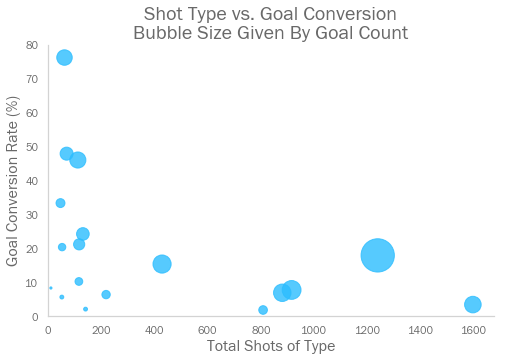

In [14]:
x = df_shots['Total']
y = df_shots['TotalXG'] * 100
s = df_shots['Goals'] * 5

plt.figure(figsize=(8,5))
plt.scatter(x,y,s,alpha=0.8)

plt.xlim(0)
plt.ylim(0)

plt.title('Shot Type vs. Goal Conversion\nBubble Size Given By Goal Count')
plt.xlabel('Total Shots of Type')
plt.ylabel('Goal Conversion Rate (%)');

We can also note the impact of getting a shot on target...

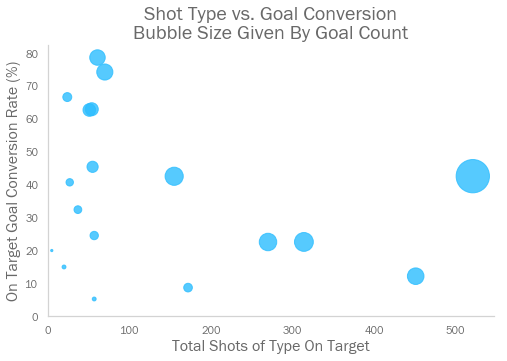

In [15]:
x = df_shots['OnTarget']
y = df_shots['OnTargetXG'] * 100
s = df_shots['Goals'] * 5

plt.figure(figsize=(8,5))
plt.scatter(x,y,s,alpha=0.8)

plt.xlim(0)
plt.ylim(0)

plt.title('Shot Type vs. Goal Conversion\nBubble Size Given By Goal Count')
plt.xlabel('Total Shots of Type On Target')
plt.ylabel('On Target Goal Conversion Rate (%)');

So having calculated the expected success of each shot, we can put this information into our dataframe.

In [16]:
xg_column = []

for row in df.itertuples():
    row_outcome = row.ShotOutcome
    row_class = row.ShotClass
    
    if row_outcome in ['Goal', 'Saved']:
        row_xg = df_shots.loc[row_class, 'OnTargetXG']
    else:
        row_xg = df_shots.loc[row_class, 'TotalXG']
        
    xg_column.append(row_xg)
    
df['XG'] = xg_column

We can then work out the expected goals for each player in each game.

In [17]:
#Let's first bring in the 'player matches' dataframe
df_pm = sql('select * from PlayerMatchesDetail', c).drop('TableIndex', axis=1)
df_pm['GoalInv'] = df_pm['Goals']+df_pm['GoalAssists']
df_pm.head(3)

Player  GameWeek  Minutes    ForTeam  \
PlayerMatchesDetailID                                                  
1                              Alisson         1       90  Liverpool   
2                      Virgil van Dijk         1       90  Liverpool   
3                         Joseph Gomez         1       90  Liverpool   

                        AgainstTeam  RelativeStrength  Goals  ShotsOnTarget  \
PlayerMatchesDetailID                                                         
1                      Norwich City                 3      0              0   
2                      Norwich City                 3      1              1   
3                      Norwich City                 3      0              0   

                       ShotsInBox  CloseShots  ...  GoalAssists  \
PlayerMatchesDetailID                          ...                
1                               0           0  ...            0   
2                               1           1  ...            0   
3                               0           0  ...            0   

                       ShotOnTargetCreated  ShotInBoxCreated  \
PlayerMatchesDetailID                                          
1                                        0                 0   
2                                        0                 0   
3                                        0                 0   

                       CloseShotCreated  TotalShotCreated  HeadersCreated  \
PlayerMatchesDetailID                                                       
1                                     0                 0               0   
2                                     0                 0               0   
3                                     0                 1               0   

                       CreatedCentre  CreatedLeft  CreatedRight  GoalInv  
PlayerMatchesDetailID                                                     
1                                  0            0             0        0  
2                                  0            0             0        1  
3                                  0            0             0        0  

[3 rows x 25 columns]

In [18]:
df_pm.tail(3)

Player  GameWeek  Minutes          ForTeam  \
PlayerMatchesDetailID                                                     
22490                  Tomas Soucek        38       90  West Ham United   
22491                  Jarrod Bowen        38       46  West Ham United   
22492                   Alfie Lewis        38        0  West Ham United   

                       AgainstTeam  RelativeStrength  Goals  ShotsOnTarget  \
PlayerMatchesDetailID                                                        
22490                  Aston Villa                 0      0              0   
22491                  Aston Villa                 0      0              0   
22492                  Aston Villa                 0      0              0   

                       ShotsInBox  CloseShots  ...  GoalAssists  \
PlayerMatchesDetailID                          ...                
22490                           0           0  ...            0   
22491                           0           0  ...            0   
22492                           0           0  ...            0   

                       ShotOnTargetCreated  ShotInBoxCreated  \
PlayerMatchesDetailID                                          
22490                                    0                 0   
22491                                    0                 0   
22492                                    0                 0   

                       CloseShotCreated  TotalShotCreated  HeadersCreated  \
PlayerMatchesDetailID                                                       
22490                                 0                 0               0   
22491                                 0                 0               0   
22492                                 0                 0               0   

                       CreatedCentre  CreatedLeft  CreatedRight  GoalInv  
PlayerMatchesDetailID                                                     
22490                              0            0             0        0  
22491                              0            0             0        0  
22492                              0            0             0        0  

[3 rows x 25 columns]

We need to associate a match ID to each row here, so that we can groupby properly.

In [19]:
def MatchIDLookup(gw, ht, at):
    '''
    Takes a gameweek, hometeam, and awayteam,
    and returns the matchID of the game
    '''
    return int(df_fixtures.loc[(df_fixtures['GameWeek']==gw)
                  &(((df_fixtures['HomeTeam']==ht)
                     &(df_fixtures['AwayTeam']==at))
                   |((df_fixtures['HomeTeam']==at)
                     &(df_fixtures['AwayTeam']==ht))),'MatchID'].item())

#Apply the function to insert the matchID
df_pm['MatchID'] = df_pm.apply(lambda x: MatchIDLookup(x['GameWeek'],
                                                       x['ForTeam'],
                                                       x['AgainstTeam']), axis=1)

#Create a multi-index
df_pm.set_index(['MatchID','Player'], inplace=True)
df_pm.head()

GameWeek  Minutes    ForTeam   AgainstTeam  \
MatchID Player                                                               
46605   Alisson                        1       90  Liverpool  Norwich City   
        Virgil van Dijk                1       90  Liverpool  Norwich City   
        Joseph Gomez                   1       90  Liverpool  Norwich City   
        Andrew Robertson               1       90  Liverpool  Norwich City   
        Trent Alexander-Arnold         1       90  Liverpool  Norwich City   

                                RelativeStrength  Goals  ShotsOnTarget  \
MatchID Player                                                           
46605   Alisson                                3      0              0   
        Virgil van Dijk                        3      1              1   
        Joseph Gomez                           3      0              0   
        Andrew Robertson                       3      0              0   
        Trent Alexander-Arnold                 3      0              1   

                                ShotsInBox  CloseShots  TotalShots  ...  \
MatchID Player                                                      ...   
46605   Alisson                          0           0           0  ...   
        Virgil van Dijk                  1           1           1  ...   
        Joseph Gomez                     0           0           0  ...   
        Andrew Robertson                 1           0           2  ...   
        Trent Alexander-Arnold           0           1           2  ...   

                                GoalAssists  ShotOnTargetCreated  \
MatchID Player                                                     
46605   Alisson                           0                    0   
        Virgil van Dijk                   0                    0   
        Joseph Gomez                      0                    0   
        Andrew Robertson                  0                    0   
        Trent Alexander-Arnold            1                    2   

                                ShotInBoxCreated  CloseShotCreated  \
MatchID Player                                                       
46605   Alisson                                0                 0   
        Virgil van Dijk                        0                 0   
        Joseph Gomez                           0                 0   
        Andrew Robertson                       1                 0   
        Trent Alexander-Arnold                 2                 3   

                                TotalShotCreated  HeadersCreated  \
MatchID Player                                                     
46605   Alisson                                0               0   
        Virgil van Dijk                        0               0   
        Joseph Gomez                           1               0   
        Andrew Robertson                       1               0   
        Trent Alexander-Arnold                 3               1   

                                CreatedCentre  CreatedLeft  CreatedRight  \
MatchID Player                                                             
46605   Alisson                             0            0             0   
        Virgil van Dijk                     0            0             0   
        Joseph Gomez                        0            0             0   
        Andrew Robertson                    0            1             0   
        Trent Alexander-Arnold              2            0             0   

                                GoalInv  
MatchID Player                           
46605   Alisson                       0  
        Virgil van Dijk               1  
        Joseph Gomez                  0  
        Andrew Robertson              0  
        Trent Alexander-Arnold        1  

[5 rows x 24 columns]

We now create columns in the player match dataframe, describing their expected goals, assists, and goal involvement.

In [20]:
#Goals
df_pm['XG'] = df.groupby(['MatchID','Player']).sum()[['XG']]
#Assists
df_pm['XA'] = df.groupby(['MatchID','AssistedBy']).sum()[['XG']]

#Fill NAs with 0s
df_pm.fillna(0, inplace=True)

#Calculate goal Involvement
df_pm['XGI'] = df_pm['XG'] + df_pm['XA']

df_pm.head()

GameWeek  Minutes    ForTeam   AgainstTeam  \
MatchID Player                                                               
46605   Alisson                        1       90  Liverpool  Norwich City   
        Virgil van Dijk                1       90  Liverpool  Norwich City   
        Joseph Gomez                   1       90  Liverpool  Norwich City   
        Andrew Robertson               1       90  Liverpool  Norwich City   
        Trent Alexander-Arnold         1       90  Liverpool  Norwich City   

                                RelativeStrength  Goals  ShotsOnTarget  \
MatchID Player                                                           
46605   Alisson                                3      0              0   
        Virgil van Dijk                        3      1              1   
        Joseph Gomez                           3      0              0   
        Andrew Robertson                       3      0              0   
        Trent Alexander-Arnold                 3      0              1   

                                ShotsInBox  CloseShots  TotalShots  ...  \
MatchID Player                                                      ...   
46605   Alisson                          0           0           0  ...   
        Virgil van Dijk                  1           1           1  ...   
        Joseph Gomez                     0           0           0  ...   
        Andrew Robertson                 1           0           2  ...   
        Trent Alexander-Arnold           0           1           2  ...   

                                CloseShotCreated  TotalShotCreated  \
MatchID Player                                                       
46605   Alisson                                0                 0   
        Virgil van Dijk                        0                 0   
        Joseph Gomez                           0                 1   
        Andrew Robertson                       0                 1   
        Trent Alexander-Arnold                 3                 3   

                                HeadersCreated  CreatedCentre  CreatedLeft  \
MatchID Player                                                               
46605   Alisson                              0              0            0   
        Virgil van Dijk                      0              0            0   
        Joseph Gomez                         0              0            0   
        Andrew Robertson                     0              0            1   
        Trent Alexander-Arnold               1              2            0   

                                CreatedRight  GoalInv        XG        XA  \
MatchID Player                                                              
46605   Alisson                            0        0  0.000000  0.000000   
        Virgil van Dijk                    0        1  0.225926  0.000000   
        Joseph Gomez                       0        0  0.000000  0.034483   
        Andrew Robertson                   0        0  0.096160  0.077596   
        Trent Alexander-Arnold             0        1  0.121692  1.112207   

                                     XGI  
MatchID Player                            
46605   Alisson                 0.000000  
        Virgil van Dijk         0.225926  
        Joseph Gomez            0.034483  
        Andrew Robertson        0.173756  
        Trent Alexander-Arnold  1.233899  

[5 rows x 27 columns]

Let's see how player gameweeks are distributed...

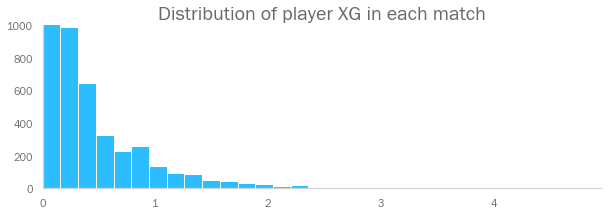

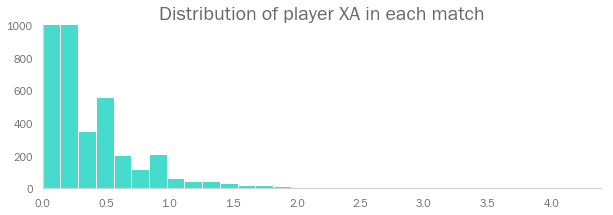

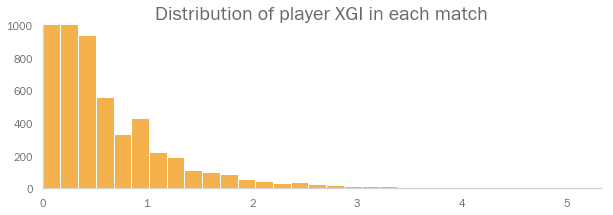

In [21]:
plt.figure(figsize=(10,3))
plt.hist(df_pm['XG'], label='XG', bins=30)

plt.xlim(0)
plt.ylim(0,1000)
plt.title('Distribution of player XG in each match')

plt.figure(figsize=(10,3))
plt.hist(df_pm['XA'], label='XGA', bins=30, color=color_list[1])

plt.xlim(0)
plt.ylim(0,1000)
plt.title('Distribution of player XA in each match')

plt.figure(figsize=(10,3))
plt.hist(df_pm['XGI'], label='XGI', bins=30, color=color_list[2])

plt.xlim(0)
plt.ylim(0,1000)
plt.title('Distribution of player XGI in each match');

Unsurprisingly, the histogram skews heavily left.

We also see that the number of predicted goalscorers is actually well under the real number.

In [22]:
print('Expected Goalscorers:', len(df_pm.loc[df_pm['XG']>=1]))
print('Actual Goalscorers:', (df_pm['Goals']>=1).sum())

Expected Goalscorers: 498
Actual Goalscorers: 896


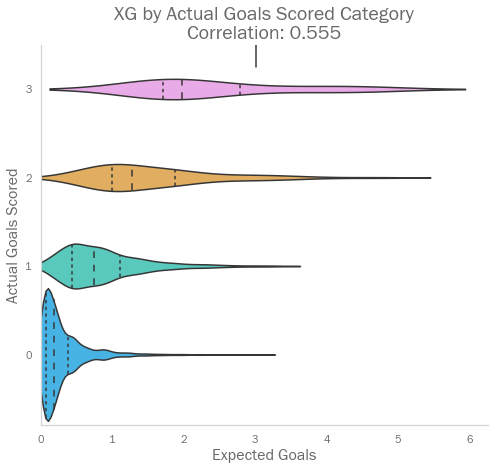

In [23]:
plt.figure(figsize=(8,7))
data = df_pm.loc[df_pm['XG']>0]
sns.violinplot('XG','Goals',data=data,
               width=1.5, inner='quartile', orient='h')

plt.xlim(0)
plt.ylim(-0.8,3.5)

corr = round(np.corrcoef(data['XG'], data['Goals'])[0][1],3)

plt.title(f'XG by Actual Goals Scored Category\nCorrelation: {corr}')
plt.xlabel('Expected Goals')
plt.ylabel('Actual Goals Scored');

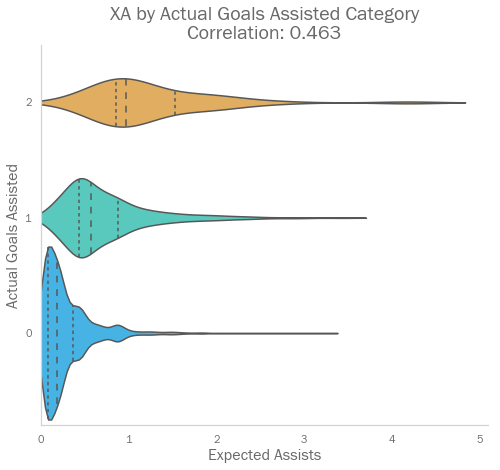

In [24]:
plt.figure(figsize=(8,7))
data = df_pm.loc[(df_pm['XA']>0)&(df_pm['GoalAssists']<3)]


sns.violinplot('XA','GoalAssists',data=data,
               width=1.5, inner='quartile', orient='h')

plt.xlim(0)
plt.ylim(-0.8,2.5)

corr = round(np.corrcoef(data['XA'], data['GoalAssists'])[0][1],3)

plt.title(f'XA by Actual Goals Assisted Category\nCorrelation: {corr}')
plt.xlabel('Expected Assists')
plt.ylabel('Actual Goals Assisted');

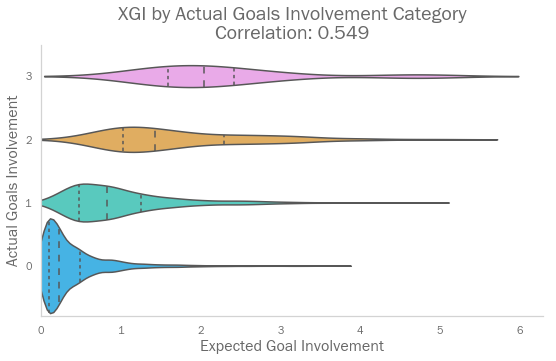

In [25]:
data = df_pm.loc[(df_pm['XGI']>0)&(df_pm['GoalInv']<4)]

plt.figure(figsize=(9,5))
sns.violinplot('XGI','GoalInv',data=data,
               width=1.5, inner='quartile', orient='h')
plt.xlim(0)
plt.ylim(-0.8,3.5)

corr = round(np.corrcoef(data['XGI'], data['GoalInv'])[0][1],3)

plt.title(f'XGI by Actual Goals Involvement Category\nCorrelation: {corr}')
plt.xlabel('Expected Goal Involvement')
plt.ylabel('Actual Goals Involvement');

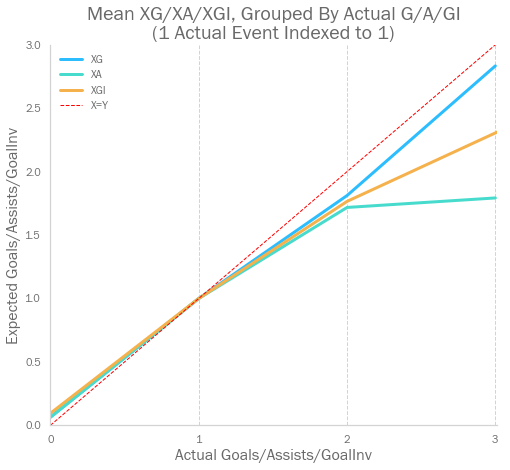

In [26]:
xg_means = [df_pm.loc[(df_pm['Goals']==i)]['XG'].mean()
          for i in [0,1,2,3]]

xa_means = [df_pm.loc[(df_pm['GoalAssists']==i)]['XA'].mean()
          for i in [0,1,2,3]]

xgi_means = [df_pm.loc[(df_pm['GoalInv']==i)]['XGI'].mean()
          for i in [0,1,2,3,4]]


plt.figure(figsize=(8,7))

x1 = np.array(xg_means) / xg_means[1]
x2 = np.array(xa_means) / xa_means[1]
x3 = np.array(xgi_means) / xgi_means[1]

plt.plot(range(4), x1, lw=3, label='XG')
plt.plot(range(4), x2, lw=3, label='XA')
plt.plot(range(5), x3, lw=3, label='XGI')

plt.plot(range(5),range(5), lw=1, color='red',
         ls='--', label='X=Y')
plt.vlines([1,2,3],0,3, color='lightgrey',
           lw=1, linestyles='--')

plt.xticks(range(0,5))

plt.xlim(0,3.01)
plt.ylim(0,3)

plt.legend(frameon=False)

plt.title('Mean XG/XA/XGI, Grouped By Actual G/A/GI\n(1 Actual Event Indexed to 1)')
plt.xlabel('Actual Goals/Assists/GoalInv')
plt.ylabel('Expected Goals/Assists/GoalInv');

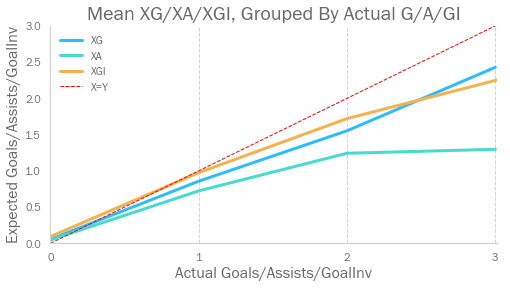

In [27]:
x1 = np.array(xg_means)
x2 = np.array(xa_means)
x3 = np.array(xgi_means)

plt.figure(figsize=(8,4))

plt.plot(range(4), x1, lw=3, label='XG')
plt.plot(range(4), x2, lw=3, label='XA')
plt.plot(range(5), x3, lw=3, label='XGI')

plt.plot(range(5),range(5), lw=1, color='red',
         ls='--', label='X=Y')
plt.vlines([1,2,3],0,3, color='lightgrey',
           lw=1, linestyles='--')

plt.xticks(range(0,5))

plt.xlim(0,3.01)
plt.ylim(0,3)

plt.legend(frameon=False)

plt.title('Mean XG/XA/XGI, Grouped By Actual G/A/GI')
plt.xlabel('Actual Goals/Assists/GoalInv')
plt.ylabel('Expected Goals/Assists/GoalInv');

So we can see that this 'expected' measure is a pretty decent measure of how many goals we would expect a player to score - players scoring two goals had a twice as high XG on average as those that scored one, and those scoring three goals had a mean XG nearly a 3 times higher.

## Modelling XG -> Actual Goals

Out of interest, could we fit a linear model between XG and actual goals?

We can do something a bit quick and dirty to see.

In [28]:
#Create a train test split
X_train, X_test, y_train, y_test = train_test_split(df_pm[['Goals']],
                                                    df_pm['XG'],
                                                    random_state=24)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('Train MSE:', round(train_mse,4))
print('Test MSE:', round(test_mse,4))

print('Test r^2:', round(r2_score(y_test, y_hat_test),4))

print('Coef:', round(linreg.coef_[0],4))
print('Intercept:', round(linreg.intercept_,4))

def XG2G(xg):
    return linreg.coef_[0] * xg + linreg.intercept_

Train MSE: 0.0504
Test MSE: 0.0466
Test r^2: 0.3841
Coef: 0.8054
Intercept: 0.0563


What about goal involvement?

In [29]:
#Create a train test split
X_train, X_test, y_train, y_test = train_test_split(df_pm[['XGI']],
                                                    df_pm['GoalInv'],
                                                    random_state=26)

linreg2 = LinearRegression()
linreg2.fit(X_train, y_train)

y_hat_train = linreg2.predict(X_train)
y_hat_test = linreg2.predict(X_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('Train MSE:', round(train_mse,4))
print('Test MSE:', round(test_mse,4))

print('Test r^2:', round(r2_score(y_test, y_hat_test),4))

print('Coef:', round(linreg2.coef_[0],4))
print('Intercept:', round(linreg2.intercept_,4))

def XGI2GI(xgi):
    return linreg2.coef_[0] * xgi + linreg2.intercept_

Train MSE: 0.0575
Test MSE: 0.0565
Test r^2: 0.4327
Coef: 0.474
Intercept: 0.0005


Our linear models are always going to have a slightly difficult time when the data is technically categorical.

## Getting the data into SQL

Let's get the data into an SQL table for future use.

In [30]:
df_pmsql = df_pm[['GameWeek','ForTeam','AgainstTeam','XG','XA','XGI']]
df_pmsql.reset_index(inplace=True)
# df_pmsql.columns = ['GameWeek','Team','MatchID','GoalsConceded','XGC']
df_pmsql.head()

MatchID                  Player  GameWeek    ForTeam   AgainstTeam  \
0    46605                 Alisson         1  Liverpool  Norwich City   
1    46605         Virgil van Dijk         1  Liverpool  Norwich City   
2    46605            Joseph Gomez         1  Liverpool  Norwich City   
3    46605        Andrew Robertson         1  Liverpool  Norwich City   
4    46605  Trent Alexander-Arnold         1  Liverpool  Norwich City   

         XG        XA       XGI  
0  0.000000  0.000000  0.000000  
1  0.225926  0.000000  0.225926  
2  0.000000  0.034483  0.034483  
3  0.096160  0.077596  0.173756  
4  0.121692  1.112207  1.233899

In [31]:
create_sql_table(df_pmsql, c, table_name = 'PlayersXG', verbose=True)
conn.commit()

populate_sql_from_dataframe(df_pmsql, 'PlayersXG', c, verbose=True)
conn.commit()

CREATE TABLE PlayersXG (PlayersXGID INTEGER PRIMARY KEY, TableIndex TEXT, MatchID INTEGER, Player TEXT, GameWeek INTEGER, ForTeam TEXT, AgainstTeam TEXT, XG REAL, XA REAL, XGI REAL, unique (MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI));

Table not added - possibly already exists
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (0, 46605, "Alisson", 1, "Liverpool", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 0 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1, 46605, "Virgil van Dijk", 1, "Liverpool", "Norwich City", 0.22592592592592592, 0.0, 0.22592592592592592);
                       
Error on row 1 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
  

Error on row 50 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (51, 46606, "George Baldock", 1, "Sheffield United", "Bournemouth", 0.03712871287128713, 0.0, 0.03712871287128713);
                       
Error on row 51 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (52, 46606, "Enda Stevens", 1, "Sheffield United", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 52 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (53, 46606, "John Fleck", 1, "Sheffield United", "Bournemouth", 0.0, 0.3128679562657696, 0.3128679562657696);
                       
Error on row 53 - you may be trying to upload a dupli

Error on row 112 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (113, 46608, "Luka Milivojevic", 1, "Crystal Palace", "Everton", 0.0, 0.10256410256410256, 0.10256410256410256);
                       
Error on row 113 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (114, 46608, "Max Meyer", 1, "Crystal Palace", "Everton", 0.48303176436500367, 0.0, 0.48303176436500367);
                       
Error on row 114 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (115, 46608, "Andros Townsend", 1, "Crystal Palace", "Everton", 0.0, 0.22611464968152867, 0.22611464968152867);
                       
Error on row 115 - you may 

Error on row 177 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (178, 46609, "Patrick Cutrone", 1, "Wolverhampton Wanderers", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 178 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (179, 46609, "Adama Traore", 1, "Wolverhampton Wanderers", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 179 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (180, 46610, "Hugo Lloris", 1, "Tottenham Hotspur", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 180 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (

                       
Error on row 235 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (236, 46611, "Pascal Groß", 1, "Brighton and Hove Albion", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 236 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (237, 46611, "Glenn Murray", 1, "Brighton and Hove Albion", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 237 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (238, 46611, "Heurelho Gomes", 1, "Watford", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 238 - you may be trying to upload a duplicate row
INSERT IN

Error on row 293 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (294, 46613, "Marcus Rashford", 1, "Manchester United", "Chelsea", 1.1226407103026987, 0.0, 1.1226407103026987);
                       
Error on row 294 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (295, 46613, "Jesse Lingard", 1, "Manchester United", "Chelsea", 0.0, 0.034482758620689655, 0.034482758620689655);
                       
Error on row 295 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (296, 46613, "Andreas Pereira", 1, "Manchester United", "Chelsea", 0.0, 0.7428571428571429, 0.7428571428571429);
                       
Error on row 296 

Error on row 342 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (343, 46614, "Matteo Guendouzi", 1, "Arsenal", "Newcastle United", 0.0, 0.17932148626817448, 0.17932148626817448);
                       
Error on row 343 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (344, 46614, "Granit Xhaka", 1, "Arsenal", "Newcastle United", 0.08333333333333333, 0.1551912568306011, 0.2385245901639344);
                       
Error on row 344 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (345, 46614, "Pierre-Emerick Aubameyang", 1, "Arsenal", "Newcastle United", 0.9091354111980172, 0.0, 0.9091354111980172);
                    

Error on row 407 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (408, 46616, "Steve Cook", 2, "Bournemouth", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 408 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (409, 46616, "Nathan Ake", 2, "Bournemouth", "Aston Villa", 0.13863636363636364, 0.0, 0.13863636363636364);
                       
Error on row 409 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (410, 46616, "Charlie Daniels", 2, "Bournemouth", "Aston Villa", 0.0, 0.2241567740719804, 0.2241567740719804);
                       
Error on row 410 - you may be trying to upload a duplicate row


Error on row 476 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (477, 46618, "Pedro", 2, "Chelsea", "Leicester City", 0.1551912568306011, 0.8053030303030303, 0.9604942871336314);
                       
Error on row 477 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (478, 46618, "Olivier Giroud", 2, "Chelsea", "Leicester City", 0.45185185185185184, 1.366041523032977, 1.8178933748848287);
                       
Error on row 478 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (479, 46618, "Kasper Schmeichel", 2, "Leicester City", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 479 - you may be trying 

                       
Error on row 526 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (527, 46619, "Mason Holgate", 2, "Everton", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 527 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (528, 46619, "Alex Iwobi", 2, "Everton", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 528 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (529, 46619, "Tom Davies", 2, "Everton", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 529 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, Fo

                       
Error on row 567 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (568, 46620, "Phil Foden", 2, "Manchester City", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 568 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (569, 46620, "Paulo Gazzaniga", 2, "Tottenham Hotspur", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 569 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (570, 46620, "Jan Vertonghen", 2, "Tottenham Hotspur", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 570 - you may be trying to upload a duplicate row
INSE

INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (613, 46622, "Jack O'Connell", 2, "Sheffield United", "Crystal Palace", 0.5729639924106806, 0.0, 0.5729639924106806);
                       
Error on row 613 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (614, 46622, "Chris Basham", 2, "Sheffield United", "Crystal Palace", 0.0, 0.32432432432432434, 0.32432432432432434);
                       
Error on row 614 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (615, 46622, "John Egan", 2, "Sheffield United", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 615 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, Matc

Error on row 658 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (659, 46623, "Adrian", 2, "Liverpool", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 659 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (660, 46623, "Virgil van Dijk", 2, "Liverpool", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 660 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (661, 46623, "Andrew Robertson", 2, "Liverpool", "Southampton", 0.45222929936305734, 0.06896551724137931, 0.5211948166044367);
                       
Error on row 661 - you may be trying to upload a duplicate row
INSERT INTO Players

                       
Error on row 703 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (704, 46624, "Scott McTominay", 2, "Manchester United", "Wolverhampton Wanderers", 0.20760188087774295, 0.0, 0.20760188087774295);
                       
Error on row 704 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (705, 46624, "Anthony Martial", 2, "Manchester United", "Wolverhampton Wanderers", 0.8522072936660269, 0.0, 0.8522072936660269);
                       
Error on row 705 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (706, 46624, "John Ruddy", 2, "Wolverhampton Wanderers", "Manchester United", 0.0, 0.0, 0.0);
    

                       
Error on row 748 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (749, 46625, "Maarten Stekelenburg", 3, "Everton", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 749 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (750, 46625, "Mason Holgate", 3, "Everton", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 750 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (751, 46625, "Djibril Sidibe", 3, "Everton", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 751 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, Mat

Error on row 793 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (794, 46627, "Lewis Dunk", 3, "Brighton and Hove Albion", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 794 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (795, 46627, "Dan Burn", 3, "Brighton and Hove Albion", "Southampton", 0.0, 0.45222929936305734, 0.45222929936305734);
                       
Error on row 795 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (796, 46627, "Dale Stephens", 3, "Brighton and Hove Albion", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 796 - you may be trying to upload a duplicate

Error on row 856 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (857, 46628, "Emiliano Martinez", 3, "Arsenal", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 857 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (858, 46628, "Calum Chambers", 3, "Arsenal", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 858 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (859, 46628, "Sead Kolasinac", 3, "Arsenal", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 859 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam,

Error on row 922 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (923, 46630, "Sam Byram", 3, "Norwich City", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 923 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (924, 46630, "Timm Klose", 3, "Norwich City", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 924 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (925, 46630, "Mario Vrancic", 3, "Norwich City", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 925 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, Aga

                       
Error on row 974 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (975, 46627, "Kyle Walker-Peters", 3, "Southampton", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 975 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (976, 46632, "Son Heung-Min", 3, "Tottenham Hotspur", "Newcastle United", 0.4995226835100161, 0.06896551724137931, 0.5684882007513954);
                       
Error on row 976 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (977, 46632, "Harry Winks", 3, "Tottenham Hotspur", "Newcastle United", 0.0, 0.034482758620689655, 0.034482758620689655);
   

Error on row 1013 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1014, 46633, "Will Hughes", 3, "Watford", "West Ham United", 0.9893194995422643, 1.2631015712624638, 2.2524210708047283);
                       
Error on row 1014 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1015, 46633, "Etienne Capoue", 3, "Watford", "West Ham United", 0.03712871287128713, 0.0, 0.03712871287128713);
                       
Error on row 1015 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1016, 46633, "Gerard Deulofeu", 3, "Watford", "West Ham United", 1.3876650807593496, 0.4972793361727126, 1.8849444169320622);
                

Error on row 1078 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1079, 46635, "Bernd Leno", 4, "Arsenal", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 1079 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1080, 46635, "Sokratis", 4, "Arsenal", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 1080 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1081, 46635, "Ainsley Maitland-Niles", 4, "Arsenal", "Tottenham Hotspur", 0.018564356435643563, 0.7739807922711345, 0.7925451487067781);
                       
Error on row 1081 - you may be trying to upload a duplicate r

Error on row 1147 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1148, 46636, "Adam Lallana", 4, "Liverpool", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 1148 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1149, 46636, "Xherdan Shaqiri", 4, "Liverpool", "Burnley", 0.034482758620689655, 0.0, 0.034482758620689655);
                       
Error on row 1149 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1150, 46636, "Divock Origi", 4, "Liverpool", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 1150 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, 

Error on row 1217 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1218, 46638, "Ahmed El Mohamady", 4, "Aston Villa", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 1218 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1219, 46638, "Henri Lansbury", 4, "Aston Villa", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 1219 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1220, 46638, "Conor Hourihane", 4, "Aston Villa", "Crystal Palace", 0.0, 0.06896551724137931, 0.06896551724137931);
                       
Error on row 1220 - you may be trying to upload a duplicate row
INS

Error on row 1286 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1287, 46640, "Ayoze Perez", 4, "Leicester City", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 1287 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1288, 46640, "Artur Boruc", 4, "Bournemouth", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 1288 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1289, 46640, "Jack Stacey", 4, "Bournemouth", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 1289 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Play

                       
Error on row 1350 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1351, 46642, "Will Hughes", 4, "Watford", "Newcastle United", 0.4258064516129032, 0.07759562841530054, 0.5034020800282037);
                       
Error on row 1351 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1352, 46642, "Roberto Pereyra", 4, "Watford", "Newcastle United", 0.12195121951219512, 0.2482870035095538, 0.3702382230217489);
                       
Error on row 1352 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1353, 46642, "Karl Darlow", 4, "Newcastle United", "Watford", 0.0, 0.0, 0.0);
                      

Error on row 1409 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1410, 46644, "Manuel Lanzini", 4, "West Ham United", "Norwich City", 1.0028147940900891, 0.41520376175548596, 1.4180185558455751);
                       
Error on row 1410 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1411, 46644, "Mark Noble", 4, "West Ham United", "Norwich City", 0.0, 0.1551912568306011, 0.1551912568306011);
                       
Error on row 1411 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1412, 46644, "Declan Rice", 4, "West Ham United", "Norwich City", 0.06896551724137931, 0.0, 0.06896551724137931);
                    

                       
Error on row 1452 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1453, 46645, "Ryan Fredericks", 5, "West Ham United", "Aston Villa", 0.0, 0.4276084897777283, 0.4276084897777283);
                       
Error on row 1453 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1454, 46645, "Arthur Masuaku", 5, "West Ham United", "Aston Villa", 0.06896551724137931, 0.13863636363636364, 0.20760188087774295);
                       
Error on row 1454 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1455, 46645, "Andriy Yarmolenko", 5, "West Ham United", "Aston Villa", 0.22415677407198042, 0.06896551724

INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1499, 46646, "Chris Mepham", 5, "Bournemouth", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 1499 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1500, 46646, "Andrew Surman", 5, "Bournemouth", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 1500 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1501, 46646, "Jefferson Lerma", 5, "Bournemouth", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 1501 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES

Error on row 1550 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1551, 46648, "Trent Alexander-Arnold", 5, "Liverpool", "Newcastle United", 0.47873522578038186, 0.6292921917497949, 1.1080274175301768);
                       
Error on row 1551 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1552, 46648, "Fabinho", 5, "Liverpool", "Newcastle United", 0.0, 0.034482758620689655, 0.034482758620689655);
                       
Error on row 1552 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1553, 46648, "Georginio Wijnaldum", 5, "Liverpool", "Newcastle United", 0.16480493074088193, 0.0, 0.16480493074088193);
         

Error on row 1601 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1602, 46649, "Hamza Choudhury", 5, "Leicester City", "Manchester United", 0.49122807017543857, 0.0, 0.49122807017543857);
                       
Error on row 1602 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1603, 46649, "Wilfred Ndidi", 5, "Leicester City", "Manchester United", 0.16498259414982594, 0.0, 0.16498259414982594);
                       
Error on row 1603 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1604, 46649, "Jamie Vardy", 5, "Leicester City", "Manchester United", 0.0, 0.06896551724137931, 0.06896551724137931);
                

Error on row 1652 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1653, 46650, "Riyad Mahrez", 5, "Manchester City", "Norwich City", 0.0, 0.06931818181818182, 0.06931818181818182);
                       
Error on row 1653 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1654, 46650, "Phil Foden", 5, "Manchester City", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 1654 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1655, 46651, "Dean Henderson", 5, "Sheffield United", "Southampton", 0.13863636363636364, 0.0, 0.13863636363636364);
                       
Error on row 1655 - you may be trying t

Error on row 1711 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1712, 46652, "Jordan Ayew", 5, "Crystal Palace", "Tottenham Hotspur", 0.6517323775388291, 0.12195121951219512, 0.7736835970510242);
                       
Error on row 1712 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1713, 46652, "Paulo Gazzaniga", 5, "Tottenham Hotspur", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 1713 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1714, 46652, "Ben Davies", 5, "Tottenham Hotspur", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 1714 - you may be trying to uplo

Error on row 1779 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1780, 46654, "Mateo Kovacic", 5, "Chelsea", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 1780 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1781, 46654, "Cesar Azpilicueta", 5, "Chelsea", "Wolverhampton Wanderers", 0.0, 0.1551912568306011, 0.1551912568306011);
                       
Error on row 1781 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1782, 46654, "Willian", 5, "Chelsea", "Wolverhampton Wanderers", 0.1551912568306011, 0.0, 0.1551912568306011);
                       
Error on row 1782 - you may be tr

Error on row 1847 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1848, 46656, "Jamal Lewis", 6, "Norwich City", "Burnley", 0.0, 0.10380094043887148, 0.10380094043887148);
                       
Error on row 1848 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1849, 46656, "Ibrahim Amadou", 6, "Norwich City", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 1849 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1850, 46656, "Ben Godfrey", 6, "Norwich City", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 1850 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableInd

Error on row 1917 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1918, 46658, "Rui Patricio", 6, "Wolverhampton Wanderers", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 1918 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1919, 46658, "Willy Boly", 6, "Wolverhampton Wanderers", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 1919 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1920, 46658, "Conor Coady", 6, "Wolverhampton Wanderers", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 1920 - you may be trying to upload a duplicate row
INSERT INTO 

Error on row 1986 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1987, 46660, "Ayoze Perez", 6, "Leicester City", "Tottenham Hotspur", 0.45222929936305734, 0.1551912568306011, 0.6074205561936584);
                       
Error on row 1987 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1988, 46660, "Wilfred Ndidi", 6, "Leicester City", "Tottenham Hotspur", 0.03712871287128713, 0.0, 0.03712871287128713);
                       
Error on row 1988 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (1989, 46660, "Jamie Vardy", 6, "Leicester City", "Tottenham Hotspur", 1.1619954168870086, 0.06896551724137931, 1.23096093412

Error on row 2043 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2044, 46661, "Heurelho Gomes", 6, "Watford", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 2044 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2045, 46661, "Daryl Janmaat", 6, "Watford", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 2045 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2046, 46661, "Christian Kabasele", 6, "Watford", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 2046 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, P

                       
Error on row 2090 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2091, 46663, "Kevin Danso", 6, "Southampton", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 2091 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2092, 46663, "Oriol Romeu", 6, "Southampton", "Bournemouth", 0.0, 0.5567703952901598, 0.5567703952901598);
                       
Error on row 2092 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2093, 46663, "James Ward-Prowse", 6, "Southampton", "Bournemouth", 2.856595961136463, 0.2765673981191223, 3.133163359255585);
                       
Error on row 2093 

Error on row 2137 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2138, 46664, "Aaron Wan-Bissaka", 6, "Manchester United", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 2138 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2139, 46664, "Juan Mata", 6, "Manchester United", "West Ham United", 0.9893194995422643, 0.10526315789473684, 1.0945826574370012);
                       
Error on row 2139 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2140, 46664, "Andreas Pereira", 6, "Manchester United", "West Ham United", 0.13793103448275862, 0.9203539823008849, 1.0582850167836435);
               

Error on row 2184 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2185, 46665, "Trezeguet", 7, "Aston Villa", "Burnley", 0.0, 0.22611464968152867, 0.22611464968152867);
                       
Error on row 2185 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2186, 46665, "Jota", 7, "Aston Villa", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 2186 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2187, 46665, "Keinan Davis", 7, "Aston Villa", "Burnley", 0.0, 0.034482758620689655, 0.034482758620689655);
                       
Error on row 2187 - you may be trying to upload a duplicate row
INSERT INTO

Error on row 2234 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2235, 46667, "Fikayo Tomori", 7, "Chelsea", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 2235 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2236, 46667, "Jorginho", 7, "Chelsea", "Brighton and Hove Albion", 1.6427360090446579, 1.6630795655654333, 3.305815574610091);
                       
Error on row 2236 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2237, 46667, "Ross Barkley", 7, "Chelsea", "Brighton and Hove Albion", 1.2978306358410931, 0.6961317383874476, 1.9939623742285408);
                       
Error

Error on row 2294 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2295, 46668, "Christian Benteke", 7, "Crystal Palace", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 2295 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2296, 46668, "Michael McGovern", 7, "Norwich City", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 2296 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2297, 46668, "Sam Byram", 7, "Norwich City", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 2297 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, M

                       
Error on row 2344 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2345, 46670, "Harvey Barnes", 7, "Leicester City", "Newcastle United", 0.06896551724137931, 1.3044365930290842, 1.3734021102704634);
                       
Error on row 2345 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2346, 46670, "Ayoze Perez", 7, "Leicester City", "Newcastle United", 0.8522072936660269, 0.04225352112676056, 0.8944608147927875);
                       
Error on row 2346 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2347, 46670, "Wilfred Ndidi", 7, "Leicester City", "Newcastle United", 0.852207293666026

Error on row 2395 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2396, 46671, "Bukayo Saka", 7, "Arsenal", "Manchester United", 0.6051279378810777, 0.4605864054537031, 1.0657143433347809);
                       
Error on row 2396 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2397, 46671, "Sergio Romero", 7, "Manchester United", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 2397 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2398, 46671, "Marcos Rojo", 7, "Manchester United", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 2398 - you may be trying to upload a duplicate row
INSE

Error on row 2453 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2454, 46673, "Moussa Sissoko", 7, "Tottenham Hotspur", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 2454 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2455, 46673, "Christian Eriksen", 7, "Tottenham Hotspur", "Southampton", 0.06896551724137931, 1.7044145873320538, 1.773380104573433);
                       
Error on row 2455 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2456, 46673, "Tanguy Ndombele", 7, "Tottenham Hotspur", "Southampton", 1.210850266202376, 0.6666666666666666, 1.8775169328690424);
                       
E

Error on row 2520 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2521, 46675, "David Luiz", 8, "Arsenal", "Bournemouth", 0.45185185185185184, 0.0, 0.45185185185185184);
                       
Error on row 2521 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2522, 46675, "Sead Kolasinac", 8, "Arsenal", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 2522 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2523, 46675, "Dani Ceballos", 8, "Arsenal", "Bournemouth", 0.0, 0.6478855876313024, 0.6478855876313024);
                       
Error on row 2523 - you may be trying to upload a duplicate row
INS

Error on row 2584 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2585, 46676, "Juan Foyth", 8, "Tottenham Hotspur", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 2585 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2586, 46676, "Harry Winks", 8, "Tottenham Hotspur", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 2586 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2587, 46676, "Dele Alli", 8, "Tottenham Hotspur", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 2587 - you may be trying to upload a duplicate row
INS

                       
Error on row 2630 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2631, 46678, "Fabinho", 8, "Liverpool", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 2631 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2632, 46678, "Georginio Wijnaldum", 8, "Liverpool", "Leicester City", 0.8522072936660269, 0.0, 0.8522072936660269);
                       
Error on row 2632 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2633, 46678, "James Milner", 8, "Liverpool", "Leicester City", 2.001378981581007, 1.096109732690417, 3.097488714271424);
                       
Error on row 2633

Error on row 2675 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2676, 46679, "Romain Saiss", 8, "Wolverhampton Wanderers", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 2676 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2677, 46679, "Ruben Neves", 8, "Wolverhampton Wanderers", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 2677 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2678, 46679, "Joao Moutinho", 8, "Wolverhampton Wanderers", "Manchester City", 0.0, 0.13863636363636364, 0.13863636363636364);
                       
Error on row 2678 - you may be trying 

                       
Error on row 2723 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2724, 46680, "Christian Atsu", 8, "Newcastle United", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 2724 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2725, 46680, "Andy Carroll", 8, "Newcastle United", "Manchester United", 0.06931818181818182, 0.0, 0.06931818181818182);
                       
Error on row 2725 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2726, 46680, "Dwight Gayle", 8, "Newcastle United", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 2726 - you may

Error on row 2780 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2781, 46682, "Kepa Arrizabalaga", 8, "Chelsea", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 2781 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2782, 46682, "Kurt Zouma", 8, "Chelsea", "Southampton", 0.13863636363636364, 0.0, 0.13863636363636364);
                       
Error on row 2782 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2783, 46682, "Marcos Alonso", 8, "Chelsea", "Southampton", 0.0, 0.24390243902439024, 0.24390243902439024);
                       
Error on row 2783 - you may be trying to upload a duplicate ro

                       
Error on row 2840 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2841, 46683, "Lys Mousset", 8, "Sheffield United", "Watford", 0.034482758620689655, 0.0, 0.034482758620689655);
                       
Error on row 2841 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2842, 46684, "Roberto Jimenez", 8, "West Ham United", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 2842 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2843, 46684, "Aaron Cresswell", 8, "West Ham United", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 2843 - you may be trying to

                       
Error on row 2892 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2893, 46685, "Dan Burn", 9, "Brighton and Hove Albion", "Aston Villa", 0.0, 0.22415677407198042, 0.22415677407198042);
                       
Error on row 2893 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2894, 46685, "Dale Stephens", 9, "Brighton and Hove Albion", "Aston Villa", 0.03712871287128713, 0.3990936958549913, 0.43622240872627843);
                       
Error on row 2894 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2895, 46685, "Pascal Groß", 9, "Brighton and Hove Albion", "Aston Villa", 0.890823440738647, 1

Error on row 2944 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2945, 46686, "Tom Trybull", 9, "Norwich City", "Bournemouth", 0.06896551724137931, 0.0, 0.06896551724137931);
                       
Error on row 2945 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2946, 46686, "Onel Hernandez", 9, "Norwich City", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 2946 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (2947, 46686, "Marco Stiepermann", 9, "Norwich City", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 2947 - you may be trying to upload a duplicate row
INSERT INTO P

Error on row 3008 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3009, 46688, "Scott Dann", 9, "Crystal Palace", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 3009 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3010, 46688, "James McCarthy", 9, "Crystal Palace", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 3010 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3011, 46688, "Max Meyer", 9, "Crystal Palace", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 3011 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, M

Error on row 3074 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3075, 46690, "Robbie Brady", 9, "Burnley", "Leicester City", 0.03712871287128713, 0.4276084897777283, 0.4647372026490154);
                       
Error on row 3075 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3076, 46690, "Jeff Hendrick", 9, "Burnley", "Leicester City", 0.4864968538148877, 0.0, 0.4864968538148877);
                       
Error on row 3076 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3077, 46690, "Ashley Westwood", 9, "Burnley", "Leicester City", 0.03712871287128713, 0.06896551724137931, 0.10609423011266644);
                 

Error on row 3122 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3123, 46691, "Adrian", 9, "Liverpool", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 3123 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3124, 46691, "Dejan Lovren", 9, "Liverpool", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 3124 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3125, 46691, "Joseph Gomez", 9, "Liverpool", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 3125 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Play

Error on row 3170 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3171, 46693, "Harry Winks", 9, "Tottenham Hotspur", "Watford", 0.0, 0.034482758620689655, 0.034482758620689655);
                       
Error on row 3171 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3172, 46693, "Moussa Sissoko", 9, "Tottenham Hotspur", "Watford", 0.034482758620689655, 0.17932148626817448, 0.21380424488886413);
                       
Error on row 3172 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3173, 46693, "Serge Aurier", 9, "Tottenham Hotspur", "Watford", 0.06931818181818182, 0.17932148626817448, 0.2486396680863563);
     

Error on row 3229 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3230, 46694, "Diogo Jota", 9, "Wolverhampton Wanderers", "Southampton", 0.0, 0.034482758620689655, 0.034482758620689655);
                       
Error on row 3230 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3231, 46694, "Alex McCarthy", 9, "Southampton", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 3231 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3232, 46694, "Jack Stephens", 9, "Southampton", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 3232 - you may be trying to upload 

                       
Error on row 3278 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3279, 46696, "Dale Stephens", 10, "Brighton and Hove Albion", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 3279 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3280, 46696, "Pascal Groß", 10, "Brighton and Hove Albion", "Everton", 1.3333333333333333, 0.0, 1.3333333333333333);
                       
Error on row 3280 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3281, 46696, "Davy Propper", 10, "Brighton and Hove Albion", "Everton", 0.0, 0.1551912568306011, 0.1551912568306011);
                       
Erro

INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3324, 46697, "Cesar Azpilicueta", 10, "Chelsea", "Burnley", 0.0, 0.034482758620689655, 0.034482758620689655);
                       
Error on row 3324 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3325, 46697, "Fikayo Tomori", 10, "Chelsea", "Burnley", 0.0, 0.034482758620689655, 0.034482758620689655);
                       
Error on row 3325 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3326, 46697, "Christian Pulisic", 10, "Chelsea", "Burnley", 1.589210252633688, 0.3381930367175189, 1.927403289351207);
                       
Error on row 3326 - you may be trying to upload a duplicate row
INSERT INTO Playe

                       
Error on row 3372 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3373, 46698, "Adam Lallana", 10, "Liverpool", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 3373 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3374, 46698, "Divock Origi", 10, "Liverpool", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 3374 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3375, 46698, "Brandon Austin", 10, "Tottenham Hotspur", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 3375 - you may be trying to upload a duplicate row
INSERT INTO P

                       
Error on row 3421 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3422, 46700, "Federico Fernandez", 10, "Newcastle United", "Wolverhampton Wanderers", 0.0, 1.2549019607843137, 1.2549019607843137);
                       
Error on row 3422 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3423, 46700, "DeAndre Yedlin", 10, "Newcastle United", "Wolverhampton Wanderers", 0.0, 0.45185185185185184, 0.45185185185185184);
                       
Error on row 3423 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3424, 46700, "Matthew Longstaff", 10, "Newcastle United", "Wolverhampton Wanderers", 0.0, 

                       
Error on row 3471 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3472, 46701, "Fred", 10, "Manchester United", "Norwich City", 0.12433801519686853, 0.0, 0.12433801519686853);
                       
Error on row 3472 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3473, 46701, "Daniel James", 10, "Manchester United", "Norwich City", 0.0, 0.4954218286511953, 0.4954218286511953);
                       
Error on row 3473 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3474, 46701, "Scott McTominay", 10, "Manchester United", "Norwich City", 0.46028921023359287, 0.0, 0.46028921023359287);
     

                       
Error on row 3519 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3520, 46702, "James Justin", 10, "Leicester City", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 3520 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3521, 46702, "Wes Morgan", 10, "Leicester City", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 3521 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3522, 46702, "Demarai Gray", 10, "Leicester City", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 3522 - you may be trying to upload a duplicate row
INSERT INTO PlayersX

Error on row 3576 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3577, 46704, "George Baldock", 10, "Sheffield United", "West Ham United", 0.3103825136612022, 0.0, 0.3103825136612022);
                       
Error on row 3577 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3578, 46704, "Enda Stevens", 10, "Sheffield United", "West Ham United", 0.1551912568306011, 0.45222929936305734, 0.6074205561936584);
                       
Error on row 3578 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3579, 46704, "John Fleck", 10, "Sheffield United", "West Ham United", 0.0, 0.7456794723188166, 0.7456794723188166);
      

Error on row 3644 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3645, 46706, "Alisson", 11, "Liverpool", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 3645 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3646, 46706, "Virgil van Dijk", 11, "Liverpool", "Aston Villa", 0.0, 0.05263157894736842, 0.05263157894736842);
                       
Error on row 3646 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3647, 46706, "Dejan Lovren", 11, "Liverpool", "Aston Villa", 0.06931818181818182, 0.0, 0.06931818181818182);
                       
Error on row 3647 - you may be trying to upload a duplicate

                       
Error on row 3703 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3704, 46707, "James Garner", 11, "Manchester United", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 3704 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3705, 46707, "Mason Greenwood", 11, "Manchester United", "Bournemouth", 0.423728813559322, 0.0, 0.423728813559322);
                       
Error on row 3705 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3706, 46708, "Mat Ryan", 11, "Brighton and Hove Albion", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 3706 - you may be trying 

                       
Error on row 3748 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3749, 46709, "Wilfried Zaha", 11, "Crystal Palace", "Leicester City", 0.34482102056359487, 0.3128679562657696, 0.6576889768293644);
                       
Error on row 3749 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3750, 46709, "Jeffrey Schlupp", 11, "Crystal Palace", "Leicester City", 0.21154731752244993, 0.4276084897777283, 0.6391558073001782);
                       
Error on row 3750 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3751, 46709, "James McArthur", 11, "Crystal Palace", "Leicester City", 0.0689655172413

Error on row 3800 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3801, 46710, "Michael Keane", 11, "Everton", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 3801 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3802, 46710, "Seamus Coleman", 11, "Everton", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 3802 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3803, 46710, "Gylfi Sigurdsson", 11, "Everton", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 3803 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, Mat

                       
Error on row 3852 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3853, 46712, "John Egan", 11, "Sheffield United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 3853 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3854, 46712, "George Baldock", 11, "Sheffield United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 3854 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3855, 46712, "Enda Stevens", 11, "Sheffield United", "Burnley", 0.15384615384615385, 0.21380424488886413, 0.367650398735018);
                       
Error on row 3855 - you may be trying to up

Error on row 3913 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3914, 46713, "Isaac Success", 11, "Watford", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 3914 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3915, 46713, "Willy Caballero", 11, "Chelsea", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 3915 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3916, 46713, "Marcos Alonso", 11, "Chelsea", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 3916 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam,

Error on row 3965 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3966, 46715, "Ashley Westwood", 12, "Burnley", "West Ham United", 0.0, 0.24390243902439024, 0.24390243902439024);
                       
Error on row 3966 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3967, 46715, "Chris Wood", 12, "Burnley", "West Ham United", 2.977019874693026, 0.0, 2.977019874693026);
                       
Error on row 3967 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (3968, 46715, "Ashley Barnes", 12, "Burnley", "West Ham United", 1.4857142857142858, 0.0, 1.4857142857142858);
                       
Error on row 3968 - you

Error on row 4027 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4028, 46716, "Jairo Riedewald", 12, "Crystal Palace", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 4028 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4029, 46716, "Christian Benteke", 12, "Crystal Palace", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 4029 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4030, 46717, "Kasper Schmeichel", 12, "Leicester City", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 4030 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchI

Error on row 4094 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4095, 46718, "Scott Carson", 12, "Manchester City", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 4095 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4096, 46718, "Joao Cancelo", 12, "Manchester City", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 4096 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4097, 46718, "Nicolas Otamendi", 12, "Manchester City", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 4097 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchI

Error on row 4164 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4165, 46720, "Andy Carroll", 12, "Newcastle United", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 4165 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4166, 46720, "Dwight Gayle", 12, "Newcastle United", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 4166 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4167, 46720, "Artur Boruc", 12, "Bournemouth", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 4167 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, Ma

                       
Error on row 4233 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4234, 46722, "Yan Valery", 12, "Southampton", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 4234 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4235, 46722, "Sofiane Boufal", 12, "Southampton", "Everton", 0.24390243902439024, 0.0, 0.24390243902439024);
                       
Error on row 4235 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4236, 46722, "Kevin Danso", 12, "Southampton", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 4236 - you may be trying to upload a duplicate row
INSERT I

Error on row 4300 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4301, 46724, "Wesley", 12, "Aston Villa", "Wolverhampton Wanderers", 0.5208173690932312, 0.0, 0.5208173690932312);
                       
Error on row 4301 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4302, 46724, "Trezeguet", 12, "Aston Villa", "Wolverhampton Wanderers", 0.4551912568306011, 0.45185185185185184, 0.9070431086824529);
                       
Error on row 4302 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4303, 46724, "Anwar El Ghazi", 12, "Aston Villa", "Wolverhampton Wanderers", 0.1744186046511628, 0.4276084897777283, 0.60202709

Error on row 4366 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4367, 46726, "Paul Dummett", 13, "Newcastle United", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 4367 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4368, 46726, "Jetro Willems", 13, "Newcastle United", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 4368 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4369, 46726, "Federico Fernandez", 13, "Newcastle United", "Aston Villa", 0.22592592592592592, 0.07759562841530054, 0.30352155434122646);
                       
Error on row 4369 - you may be trying to uplo

Error on row 4434 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4435, 46728, "Leandro Trossard", 13, "Brighton and Hove Albion", "Leicester City", 0.0, 0.034482758620689655, 0.034482758620689655);
                       
Error on row 4435 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4436, 46728, "Aaron Mooy", 13, "Brighton and Hove Albion", "Leicester City", 0.0, 0.6010672149605913, 0.6010672149605913);
                       
Error on row 4436 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4437, 46728, "Kasper Schmeichel", 13, "Leicester City", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                    

Error on row 4503 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4504, 46730, "Gylfi Sigurdsson", 13, "Everton", "Norwich City", 0.7459407090490267, 0.07759562841530054, 0.8235363374643272);
                       
Error on row 4504 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4505, 46730, "Theo Walcott", 13, "Everton", "Norwich City", 0.0639269406392694, 0.0, 0.0639269406392694);
                       
Error on row 4505 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4506, 46730, "Morgan Schneiderlin", 13, "Everton", "Norwich City", 0.15384615384615385, 0.0, 0.15384615384615385);
                       
Error

Error on row 4571 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4572, 46732, "Chris Basham", 13, "Sheffield United", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 4572 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4573, 46732, "Phil Jagielka", 13, "Sheffield United", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 4573 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4574, 46732, "George Baldock", 13, "Sheffield United", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 4574 - you may be trying to upload a duplicate row
INSERT INTO Pla

Error on row 4640 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4641, 46733, "Jay Rodriguez", 13, "Burnley", "Watford", 0.034482758620689655, 0.0, 0.034482758620689655);
                       
Error on row 4641 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4642, 46734, "Roberto Jimenez", 13, "West Ham United", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 4642 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4643, 46734, "Aaron Cresswell", 13, "West Ham United", "Tottenham Hotspur", 0.03712871287128713, 0.06896551724137931, 0.10609423011266644);
                       
Error on row 4

Error on row 4709 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4710, 46735, "Victor Camarasa", 14, "Crystal Palace", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 4710 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4711, 46735, "James McCarthy", 14, "Crystal Palace", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 4711 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4712, 46735, "Jairo Riedewald", 14, "Crystal Palace", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 4712 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Pl

Error on row 4779 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4780, 46737, "Leighton Baines", 14, "Everton", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 4780 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4781, 46737, "Morgan Schneiderlin", 14, "Everton", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 4781 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4782, 46735, "Cenk Tosun", 14, "Crystal Palace", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 4782 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Pl

Error on row 4848 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4849, 46739, "James Garner", 14, "Manchester United", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 4849 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4850, 46739, "Mason Greenwood", 14, "Manchester United", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 4850 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4851, 46739, "Ørjan Nyland", 14, "Aston Villa", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 4851 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIn

Error on row 4918 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4919, 46741, "Mario Vrancic", 14, "Norwich City", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 4919 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4920, 46741, "Emiliano Buendia", 14, "Norwich City", "Arsenal", 0.0, 0.7046611517063077, 0.7046611517063077);
                       
Error on row 4920 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4921, 46741, "Marco Stiepermann", 14, "Norwich City", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 4921 - you may be trying to upload a duplicate row
INSERT INTO PlayersX

Error on row 4987 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4988, 46743, "Alfie Whiteman", 14, "Tottenham Hotspur", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 4988 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4989, 46740, "Danny Rose", 14, "Newcastle United", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 4989 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (4990, 46742, "Kyle Walker-Peters", 14, "Southampton", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 4990 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex,

Error on row 5055 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5056, 46745, "Aaron Mooy", 15, "Brighton and Hove Albion", "Arsenal", 0.7090052589204653, 2.2962091101024864, 3.005214369022952);
                       
Error on row 5056 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5057, 46745, "Davy Propper", 15, "Brighton and Hove Albion", "Arsenal", 0.24390243902439024, 0.0, 0.24390243902439024);
                       
Error on row 5057 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5058, 46745, "Neal Maupay", 15, "Brighton and Hove Albion", "Arsenal", 2.653319096296688, 0.06896551724137931, 2.7222846135380

Error on row 5119 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5120, 46747, "Jamie Vardy", 15, "Leicester City", "Watford", 1.7289617486338797, 0.0, 1.7289617486338797);
                       
Error on row 5120 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5121, 46747, "Ben Foster", 15, "Watford", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 5121 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5122, 46747, "Adrian Mariappa", 15, "Watford", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 5122 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (T

                       
Error on row 5181 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5182, 46749, "Dean Henderson", 15, "Sheffield United", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 5182 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5183, 46749, "Jack O'Connell", 15, "Sheffield United", "Newcastle United", 0.4074074074074074, 0.0, 0.4074074074074074);
                       
Error on row 5183 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5184, 46749, "Chris Basham", 15, "Sheffield United", "Newcastle United", 0.0, 0.22592592592592592, 0.22592592592592592);
                   

Error on row 5244 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5245, 46750, "Patrick Cutrone", 15, "Wolverhampton Wanderers", "West Ham United", 0.8522072936660269, 0.0, 0.8522072936660269);
                       
Error on row 5245 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5246, 46750, "Benny Ashley-Seal", 15, "Wolverhampton Wanderers", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 5246 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5247, 46750, "Roberto Jimenez", 15, "West Ham United", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 5247 - you ma

                       
Error on row 5303 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5304, 46752, "Diego Rico", 15, "Bournemouth", "Crystal Palace", 0.0, 0.13863636363636364, 0.13863636363636364);
                       
Error on row 5304 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5305, 46752, "Chris Mepham", 15, "Bournemouth", "Crystal Palace", 0.8516129032258064, 0.0, 0.8516129032258064);
                       
Error on row 5305 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5306, 46752, "Jefferson Lerma", 15, "Bournemouth", "Crystal Palace", 0.3128679562657696, 0.0, 0.3128679562657696);
             

                       
Error on row 5358 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5359, 46752, "Cenk Tosun", 15, "Crystal Palace", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 5359 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5360, 46753, "Bernard", 15, "Everton", "Liverpool", 0.0, 0.42610364683301344, 0.42610364683301344);
                       
Error on row 5360 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5361, 46753, "Moise Kean", 15, "Everton", "Liverpool", 0.034482758620689655, 0.0, 0.034482758620689655);
                       
Error on row 5361 - you may be trying to up

                       
Error on row 5407 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5408, 46755, "Wesley", 16, "Aston Villa", "Leicester City", 0.13863636363636364, 0.4276084897777283, 0.5662448534140919);
                       
Error on row 5408 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5409, 46755, "Kasper Schmeichel", 16, "Leicester City", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 5409 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5410, 46755, "Ben Chilwell", 16, "Leicester City", "Aston Villa", 0.0, 0.29382762046696476, 0.29382762046696476);
                       
Error

Error on row 5454 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5455, 46756, "Alex Oxlade-Chamberlain", 16, "Liverpool", "Bournemouth", 0.9211728109074061, 0.0, 0.9211728109074061);
                       
Error on row 5455 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5456, 46756, "Artur Boruc", 16, "Bournemouth", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 5456 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5457, 46756, "Jack Stacey", 16, "Bournemouth", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 5457 - you may be trying to upload a duplicate row
INSERT INTO Player

Error on row 5510 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5511, 46758, "Gylfi Sigurdsson", 16, "Everton", "Chelsea", 0.0, 0.06931818181818182, 0.06931818181818182);
                       
Error on row 5511 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5512, 46758, "Theo Walcott", 16, "Everton", "Chelsea", 0.3222746345324728, 0.22611464968152867, 0.5483892842140015);
                       
Error on row 5512 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5513, 46758, "Alex Iwobi", 16, "Everton", "Chelsea", 0.0, 0.22611464968152867, 0.22611464968152867);
                       
Error on row 5513 - you may

                       
Error on row 5573 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5574, 46759, "Brandon Williams", 16, "Manchester United", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 5574 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5575, 46759, "Juan Mata", 16, "Manchester United", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 5575 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5576, 46759, "Andreas Pereira", 16, "Manchester United", "Manchester City", 0.07759562841530054, 0.42610364683301344, 0.503699275248314);
                       
Error on ro

                       
Error on row 5635 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5636, 46761, "Ralf Fahrmann", 16, "Norwich City", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 5636 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5637, 46761, "Jamal Lewis", 16, "Norwich City", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 5637 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5638, 46761, "Tom Trybull", 16, "Norwich City", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 5638 - you may be trying to upload a duplicate row
INSERT INT

Error on row 5699 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5700, 46763, "Jeffrey Schlupp", 16, "Crystal Palace", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 5700 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5701, 46763, "Martin Kelly", 16, "Crystal Palace", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 5701 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5702, 46763, "Luka Milivojevic", 16, "Crystal Palace", "Watford", 0.0, 0.07759562841530054, 0.07759562841530054);
                       
Error on row 5702 - you may be trying to upload a duplicate row
INSERT INTO Pla

Error on row 5769 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5770, 46765, "Kyle Walker", 17, "Manchester City", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 5770 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5771, 46765, "Benjamin Mendy", 17, "Manchester City", "Arsenal", 0.0, 0.06931818181818182, 0.06931818181818182);
                       
Error on row 5771 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5772, 46765, "Fernandinho", 17, "Manchester City", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 5772 - you may be trying to upload a duplicate row
INSERT INTO Players

Error on row 5836 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5837, 46767, "Mason Mount", 17, "Chelsea", "Bournemouth", 0.9090909090909091, 0.0, 0.9090909090909091);
                       
Error on row 5837 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5838, 46767, "Christian Pulisic", 17, "Chelsea", "Bournemouth", 0.6514568764568764, 0.0, 0.6514568764568764);
                       
Error on row 5838 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5839, 46767, "Willian", 17, "Chelsea", "Bournemouth", 0.34751122653248934, 0.4824009324009324, 0.8299121589334217);
                       
Error on row 5839 - yo

Error on row 5899 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5900, 46768, "Glenn Murray", 17, "Brighton and Hove Albion", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 5900 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5901, 46768, "Steven Alzate", 17, "Brighton and Hove Albion", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 5901 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5902, 46769, "Kasper Schmeichel", 17, "Leicester City", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 5902 - you may be trying to upload a duplicate row
INSERT IN

Error on row 5967 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5968, 46770, "Dimitri Foulquier", 17, "Watford", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 5968 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5969, 46770, "Craig Dawson", 17, "Watford", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 5969 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (5970, 46770, "Nathaniel Chalobah", 17, "Watford", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 5970 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWe

Error on row 6036 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6037, 46772, "Oliver McBurnie", 17, "Sheffield United", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 6037 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6038, 46772, "Billy Sharp", 17, "Sheffield United", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 6038 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6039, 46772, "Ørjan Nyland", 17, "Aston Villa", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 6039 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex,

Error on row 6105 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6106, 46774, "Ruben Vinagre", 17, "Wolverhampton Wanderers", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 6106 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6107, 46774, "Maximilian Kilman", 17, "Wolverhampton Wanderers", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 6107 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6108, 46774, "Pedro Neto", 17, "Wolverhampton Wanderers", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 6108 - you may be trying to upload a duplica

Error on row 6174 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6175, 46776, "Ashley Barnes", 18, "Burnley", "Bournemouth", 0.03712871287128713, 0.0, 0.03712871287128713);
                       
Error on row 6175 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6176, 46776, "Artur Boruc", 18, "Bournemouth", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 6176 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6177, 46776, "Jack Simpson", 18, "Bournemouth", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 6177 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableInd

                       
Error on row 6243 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6244, 46778, "Granit Xhaka", 18, "Arsenal", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 6244 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6245, 46778, "Gabriel Martinelli", 18, "Arsenal", "Everton", 0.1120783870359902, 0.0, 0.1120783870359902);
                       
Error on row 6245 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6246, 46778, "Emile Smith Rowe", 18, "Arsenal", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 6246 - you may be trying to upload a duplicate row
INSERT INTO

Error on row 6312 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6313, 46780, "Martin Kelly", 18, "Crystal Palace", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 6313 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6314, 46780, "James McCarthy", 18, "Crystal Palace", "Newcastle United", 0.02112676056338028, 0.0, 0.02112676056338028);
                       
Error on row 6314 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6315, 46780, "Luka Milivojevic", 18, "Crystal Palace", "Newcastle United", 0.07161147149197679, 0.21380424488886413, 0.2854157163808409);
                       
Error 

                       
Error on row 6381 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6382, 46782, "Kurt Zouma", 18, "Chelsea", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 6382 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6383, 46782, "Antonio Rudiger", 18, "Chelsea", "Tottenham Hotspur", 0.034482758620689655, 0.0, 0.034482758620689655);
                       
Error on row 6383 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6384, 46782, "Fikayo Tomori", 18, "Chelsea", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 6384 - you may be trying to upload a

Error on row 6451 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6452, 46785, "Wesley", 19, "Aston Villa", "Norwich City", 0.0, 0.1551912568306011, 0.1551912568306011);
                       
Error on row 6452 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6453, 46785, "Tim Krul", 19, "Norwich City", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 6453 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6454, 46785, "Max Aarons", 19, "Norwich City", "Aston Villa", 0.0, 0.5979859312152979, 0.5979859312152979);
                       
Error on row 6454 - you may be trying to upload a duplicate row


Error on row 6521 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6522, 46787, "Willian", 19, "Chelsea", "Southampton", 0.0, 0.11121903836813987, 0.11121903836813987);
                       
Error on row 6522 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6523, 46787, "Tammy Abraham", 19, "Chelsea", "Southampton", 0.04225352112676056, 0.0, 0.04225352112676056);
                       
Error on row 6523 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6524, 46787, "Callum Hudson-Odoi", 19, "Chelsea", "Southampton", 0.2931222913133597, 0.45185185185185184, 0.7449741431652115);
                       
Error on row 65

Error on row 6590 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6591, 46789, "Gylfi Sigurdsson", 19, "Everton", "Burnley", 0.05304711505633322, 0.4338804713804714, 0.48692758643680467);
                       
Error on row 6591 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6592, 46789, "Lucas Digne", 19, "Everton", "Burnley", 0.05304711505633322, 0.10380094043887148, 0.1568480554952047);
                       
Error on row 6592 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6593, 46789, "Djibril Sidibe", 19, "Everton", "Burnley", 0.24467900611717222, 0.29489144316730526, 0.5395704492844775);
                 

Error on row 6658 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6659, 46791, "Victor Lindelof", 19, "Manchester United", "Newcastle United", 0.07759562841530054, 0.0, 0.07759562841530054);
                       
Error on row 6659 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6660, 46791, "Harry Maguire", 19, "Manchester United", "Newcastle United", 0.19126940133037695, 0.0, 0.19126940133037695);
                       
Error on row 6660 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6661, 46791, "Luke Shaw", 19, "Manchester United", "Newcastle United", 0.26059740830221834, 0.0, 0.26059740830221834);
         

Error on row 6725 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6726, 46792, "Tom Dele-Bashiru", 19, "Watford", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 6726 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6727, 46792, "Roberto Pereyra", 19, "Watford", "Sheffield United", 0.0, 0.07759562841530054, 0.07759562841530054);
                       
Error on row 6727 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6728, 46792, "Andre Gray", 19, "Watford", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 6728 - you may be trying to upload a duplicate row
INSERT INTO

Error on row 6791 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6792, 46794, "Maximilian Kilman", 19, "Wolverhampton Wanderers", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 6792 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6793, 46794, "Pedro Neto", 19, "Wolverhampton Wanderers", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 6793 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6794, 46794, "Patrick Cutrone", 19, "Wolverhampton Wanderers", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 6794 - you may be trying to upload a duplicate r

Error on row 6857 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6858, 46796, "Joshua King", 20, "Bournemouth", "Brighton and Hove Albion", 0.22611464968152867, 0.17932148626817448, 0.4054361359497032);
                       
Error on row 6858 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6859, 46796, "Dominic Solanke", 20, "Bournemouth", "Brighton and Hove Albion", 0.19788584270381804, 0.034482758620689655, 0.2323686013245077);
                       
Error on row 6859 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6860, 46796, "David Button", 20, "Brighton and Hove Albion", "Bournemouth", 0.0, 0.0, 0.0);
   

Error on row 6925 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6926, 46798, "Jonny", 20, "Wolverhampton Wanderers", "Liverpool", 0.0, 0.06896551724137931, 0.06896551724137931);
                       
Error on row 6926 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6927, 46798, "Joao Moutinho", 20, "Wolverhampton Wanderers", "Liverpool", 0.2433841218925421, 0.13863636363636364, 0.3820204855289058);
                       
Error on row 6927 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6928, 46798, "Ruben Vinagre", 20, "Wolverhampton Wanderers", "Liverpool", 0.1551912568306011, 0.0, 0.1551912568306011);
      

Error on row 6995 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6996, 46800, "Michael Keane", 20, "Everton", "Newcastle United", 0.24242424242424243, 0.22611464968152867, 0.4685388921057711);
                       
Error on row 6996 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6997, 46800, "Djibril Sidibe", 20, "Everton", "Newcastle United", 0.06896551724137931, 0.13863636363636364, 0.20760188087774295);
                       
Error on row 6997 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (6998, 46800, "Richarlison", 20, "Everton", "Newcastle United", 0.5825376249658982, 1.2034435483108459, 1.7859811732767

Error on row 7064 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7065, 46802, "Vicente Guaita", 20, "Crystal Palace", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 7065 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7066, 46802, "James Tomkins", 20, "Crystal Palace", "Southampton", 0.9037037037037037, 0.0, 0.9037037037037037);
                       
Error on row 7066 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7067, 46802, "Mamadou Sakho", 20, "Crystal Palace", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 7067 - you may be trying to upload a duplicate row
INSERT I

Error on row 7134 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7135, 46804, "Declan Rice", 20, "West Ham United", "Leicester City", 0.42610364683301344, 0.10380094043887148, 0.5299045872718849);
                       
Error on row 7135 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7136, 46804, "Sebastien Haller", 20, "West Ham United", "Leicester City", 0.5193690509222362, 0.12195121951219512, 0.6413202704344313);
                       
Error on row 7136 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7137, 46804, "Kasper Schmeichel", 20, "Leicester City", "West Ham United", 0.0, 0.0, 0.0);
                 

Error on row 7204 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7205, 46806, "Davy Propper", 21, "Brighton and Hove Albion", "Chelsea", 0.06896551724137931, 0.0, 0.06896551724137931);
                       
Error on row 7205 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7206, 46806, "Steven Alzate", 21, "Brighton and Hove Albion", "Chelsea", 0.5045117062122259, 0.0, 0.5045117062122259);
                       
Error on row 7206 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7207, 46806, "Neal Maupay", 21, "Brighton and Hove Albion", "Chelsea", 0.8522072936660269, 0.8522072936660269, 1.7044145873320538);
     

Error on row 7274 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7275, 46808, "Georginio Wijnaldum", 21, "Liverpool", "Sheffield United", 0.17932148626817448, 0.0, 0.17932148626817448);
                       
Error on row 7275 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7276, 46808, "James Milner", 21, "Liverpool", "Sheffield United", 0.0, 0.034482758620689655, 0.034482758620689655);
                       
Error on row 7276 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7277, 46808, "Jordan Henderson", 21, "Liverpool", "Sheffield United", 0.034482758620689655, 0.7092260735400594, 0.743708832160749);
       

Error on row 7343 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7344, 46810, "Federico Fernandez", 21, "Newcastle United", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 7344 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7345, 46810, "Florian Lejeune", 21, "Newcastle United", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 7345 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7346, 46810, "Jonjo Shelvey", 21, "Newcastle United", "Leicester City", 0.0, 1.2347460963267807, 1.2347460963267807);
                       
Error on row 7346 - you may be trying to upload a d

Error on row 7412 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7413, 46811, "James Daly", 21, "Crystal Palace", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 7413 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7414, 46812, "Alex McCarthy", 21, "Southampton", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 7414 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7415, 46805, "Cedric Soares", 21, "Arsenal", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 7415 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, Matc

Error on row 7481 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7482, 46813, "Ruben Neves", 21, "Wolverhampton Wanderers", "Watford", 0.14322294298395358, 0.0, 0.14322294298395358);
                       
Error on row 7482 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7483, 46813, "Owen Otasowie", 21, "Wolverhampton Wanderers", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 7483 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7484, 46813, "Patrick Cutrone", 21, "Wolverhampton Wanderers", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 7484 - you may be trying to upload a duplic

Error on row 7551 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7552, 46815, "Kyle Walker", 22, "Manchester City", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 7552 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7553, 46815, "Nicolas Otamendi", 22, "Manchester City", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 7553 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7554, 46815, "Ilkay Gundogan", 22, "Manchester City", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 7554 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex,

                       
Error on row 7621 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7622, 46817, "Michy Batshuayi", 22, "Chelsea", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 7622 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7623, 46817, "Joe Hart", 22, "Burnley", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 7623 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7624, 46817, "Ben Gibson", 22, "Burnley", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 7624 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, Ga

Error on row 7690 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7691, 46819, "Seamus Coleman", 22, "Everton", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 7691 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7692, 46819, "Fabian Delph", 22, "Everton", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 7692 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7693, 46819, "Morgan Schneiderlin", 22, "Everton", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 7693 - you may be trying to upload a duplicate row
INSERT INTO Pla

Error on row 7760 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7761, 46821, "Phil Jones", 22, "Manchester United", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 7761 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7762, 46821, "Diogo Dalot", 22, "Manchester United", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 7762 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7763, 46821, "Daniel James", 22, "Manchester United", "Norwich City", 0.07759562841530054, 0.0, 0.07759562841530054);
                       
Error on row 7763 - you may be trying to upload a duplicate row
I

Error on row 7830 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7831, 46823, "Mohamed Salah", 22, "Liverpool", "Tottenham Hotspur", 0.15384615384615385, 0.9298029220813274, 1.0836490759274813);
                       
Error on row 7831 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7832, 46823, "Michel Vorm", 22, "Tottenham Hotspur", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 7832 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7833, 46823, "Jan Vertonghen", 22, "Tottenham Hotspur", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 7833 - you may be trying to upload a dupli

Error on row 7899 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7900, 46825, "John Lundstram", 23, "Sheffield United", "Arsenal", 0.15384615384615385, 0.0, 0.15384615384615385);
                       
Error on row 7900 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7901, 46825, "Oliver Norwood", 23, "Sheffield United", "Arsenal", 0.018564356435643563, 0.22592592592592592, 0.24449028236156947);
                       
Error on row 7901 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7902, 46825, "Oliver McBurnie", 23, "Sheffield United", "Arsenal", 0.6476716546183428, 0.0, 0.6476716546183428);
                  

Error on row 7969 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7970, 46827, "James Maddison", 23, "Leicester City", "Burnley", 1.0272670410200724, 1.1446796650892852, 2.171946706109358);
                       
Error on row 7970 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7971, 46827, "Harvey Barnes", 23, "Leicester City", "Burnley", 2.156643886695111, 1.3734021102704637, 3.5300459969655744);
                       
Error on row 7971 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (7972, 46827, "Ayoze Perez", 23, "Leicester City", "Burnley", 0.8434914573848338, 0.8522072936660269, 1.6956987510508608);
       

Error on row 8039 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8040, 46829, "Martin Kelly", 23, "Crystal Palace", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 8040 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8041, 46829, "Jairo Riedewald", 23, "Crystal Palace", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 8041 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8042, 46829, "James McCarthy", 23, "Crystal Palace", "Manchester City", 0.0, 0.10256410256410256, 0.10256410256410256);
                       
Error on row 8042 - you may be trying to upload a duplica

Error on row 8108 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8109, 46831, "Aaron Ramsdale", 23, "Bournemouth", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 8109 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8110, 46831, "Steve Cook", 23, "Bournemouth", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 8110 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8111, 46831, "Nathan Ake", 23, "Bournemouth", "Norwich City", 1.4095983307250912, 0.0, 1.4095983307250912);
                       
Error on row 8111 - you may be trying to upload a duplicate row
INSERT INTO PlayersX

Error on row 8177 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8178, 46833, "Ismaila Sarr", 23, "Watford", "Tottenham Hotspur", 0.43623860095164946, 0.46015141028921486, 0.8963900112408643);
                       
Error on row 8178 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8179, 46833, "Etienne Capoue", 23, "Watford", "Tottenham Hotspur", 0.05304711505633322, 0.0, 0.05304711505633322);
                       
Error on row 8179 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8180, 46833, "Troy Deeney", 23, "Watford", "Tottenham Hotspur", 1.4235744403571942, 0.20044824683155477, 1.6240226871887489);
       

Error on row 8247 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8248, 46835, "Matt Targett", 24, "Aston Villa", "Watford", 0.6781552252889833, 0.10380094043887148, 0.7819561657278548);
                       
Error on row 8248 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8249, 46835, "Frederic Guilbert", 24, "Aston Villa", "Watford", 0.0, 0.22592592592592592, 0.22592592592592592);
                       
Error on row 8249 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8250, 46835, "Jack Grealish", 24, "Aston Villa", "Watford", 0.17932148626817448, 0.7091464140465324, 0.8884679003147069);
                     

Error on row 8317 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8318, 46837, "Djibril Sidibe", 24, "Everton", "Newcastle United", 0.0872093023255814, 0.034482758620689655, 0.12169206094627105);
                       
Error on row 8318 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8319, 46837, "Fabian Delph", 24, "Everton", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 8319 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8320, 46837, "Theo Walcott", 24, "Everton", "Newcastle United", 0.03712871287128713, 0.40383680834447216, 0.44096552121575927);
                       
Error on row 8

Error on row 8388 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8389, 46839, "Aaron Wan-Bissaka", 24, "Manchester United", "Burnley", 0.0, 1.0205767115491955, 1.0205767115491955);
                       
Error on row 8389 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8390, 46839, "Brandon Williams", 24, "Manchester United", "Burnley", 0.0, 0.034482758620689655, 0.034482758620689655);
                       
Error on row 8390 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8391, 46839, "Juan Mata", 24, "Manchester United", "Burnley", 0.05304711505633322, 0.4861608444976822, 0.5392079595540155);
                 

Error on row 8459 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8460, 46841, "Romain Saiss", 24, "Wolverhampton Wanderers", "Liverpool", 0.0, 0.13793103448275862, 0.13793103448275862);
                       
Error on row 8460 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8461, 46841, "Leander Dendoncker", 24, "Wolverhampton Wanderers", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 8461 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8462, 46841, "Matt Doherty", 24, "Wolverhampton Wanderers", "Liverpool", 0.13863636363636364, 0.0, 0.13863636363636364);
                       
Error on row 84

Error on row 8530 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8531, 46801, "Ben Godfrey", 20, "Norwich City", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 8531 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8532, 46811, "Ben Godfrey", 21, "Norwich City", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 8532 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8533, 46821, "Ben Godfrey", 22, "Norwich City", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 8533 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, M

                       
Error on row 8596 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8597, 46781, "Patrick Roberts", 18, "Norwich City", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 8597 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8598, 46785, "Patrick Roberts", 19, "Norwich City", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 8598 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8599, 46801, "Patrick Roberts", 20, "Norwich City", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 8599 - you may be trying to upload a duplicate r

                       
Error on row 8657 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8658, 46720, "Jefferson Lerma", 12, "Bournemouth", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 8658 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8659, 46646, "Adam Smith", 5, "Bournemouth", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 8659 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8660, 46663, "Adam Smith", 6, "Bournemouth", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 8660 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableI

Error on row 8725 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8726, 46727, "Andrew Surman", 13, "Bournemouth", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 8726 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8727, 46743, "Andrew Surman", 14, "Bournemouth", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 8727 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8728, 46752, "Andrew Surman", 15, "Bournemouth", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 8728 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Tabl

Error on row 8794 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8795, 46762, "Ashley Westwood", 16, "Burnley", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 8795 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8796, 46697, "Chris Wood", 10, "Burnley", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 8796 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8797, 46712, "Chris Wood", 11, "Burnley", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 8797 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameW

Error on row 8864 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8865, 46675, "Cedric Soares", 8, "Arsenal", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 8865 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8866, 46692, "Cedric Soares", 9, "Arsenal", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 8866 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8867, 46695, "Cedric Soares", 10, "Arsenal", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 8867 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, Ga

Error on row 8934 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8935, 46818, "Christian Benteke", 22, "Crystal Palace", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 8935 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8936, 46829, "Christian Benteke", 23, "Crystal Palace", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 8936 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (8937, 46834, "Michael Keane", 23, "Everton", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 8937 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex,

Error on row 9004 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9005, 46716, "Connor Wickham", 12, "Crystal Palace", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 9005 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9006, 46729, "Connor Wickham", 13, "Crystal Palace", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 9006 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9007, 46735, "Connor Wickham", 14, "Crystal Palace", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 9007 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Pl

Error on row 9070 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9071, 46649, "Ryan Bennett", 5, "Leicester City", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 9071 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9072, 46660, "Ryan Bennett", 6, "Leicester City", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 9072 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9073, 46702, "Ryan Bennett", 10, "Leicester City", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 9073 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableInde

Error on row 9139 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9140, 46734, "Hugo Lloris", 13, "Tottenham Hotspur", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 9140 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9141, 46743, "Hugo Lloris", 14, "Tottenham Hotspur", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 9141 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9142, 46748, "Hugo Lloris", 15, "Tottenham Hotspur", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 9142 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Tab

Error on row 9207 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9208, 46826, "Tom Heaton", 23, "Aston Villa", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 9208 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9209, 46835, "Tom Heaton", 24, "Aston Villa", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 9209 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9210, 46726, "Neil Taylor", 13, "Aston Villa", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 9210 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID

Error on row 9264 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9265, 46801, "Victor Wanyama", 20, "Tottenham Hotspur", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 9265 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9266, 46812, "Victor Wanyama", 21, "Tottenham Hotspur", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 9266 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9267, 46823, "Victor Wanyama", 22, "Tottenham Hotspur", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 9267 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Table

Error on row 9333 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9334, 46775, "Jota", 18, "Aston Villa", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 9334 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9335, 46807, "Jota", 21, "Aston Villa", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 9335 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9336, 46815, "Jota", 22, "Aston Villa", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 9336 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, Agai

Error on row 9403 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9404, 46793, "Solly March", 19, "Brighton and Hove Albion", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 9404 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9405, 46796, "Solly March", 20, "Brighton and Hove Albion", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 9405 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9406, 46806, "Solly March", 21, "Brighton and Hove Albion", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 9406 - you may be trying to upload a duplicate row
INSERT INTO P

Error on row 9472 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9473, 46713, "Ken Sema", 11, "Watford", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 9473 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9474, 46721, "Ken Sema", 12, "Watford", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 9474 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9475, 46733, "Ken Sema", 13, "Watford", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 9475 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam

Error on row 9541 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9542, 46836, "Florin Andone", 24, "Brighton and Hove Albion", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 9542 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9543, 46684, "Lukasz Fabianski", 8, "West Ham United", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 9543 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9544, 46689, "Lukasz Fabianski", 9, "West Ham United", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 9544 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (T

Error on row 9569 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9570, 46834, "Felipe Anderson", 23, "West Ham United", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 9570 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9571, 46838, "Felipe Anderson", 24, "West Ham United", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 9571 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9572, 46664, "Manuel Lanzini", 6, "West Ham United", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 9572 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Tabl

Error on row 9610 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9611, 46688, "Kyle Walker", 9, "Manchester City", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 9611 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9612, 46620, "John Stones", 2, "Manchester City", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 9612 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9613, 46626, "John Stones", 3, "Manchester City", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 9613 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, M

Error on row 9639 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9640, 46688, "Aymeric Laporte", 9, "Manchester City", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 9640 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9641, 46699, "Aymeric Laporte", 10, "Manchester City", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 9641 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9642, 46711, "Aymeric Laporte", 11, "Manchester City", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 9642 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Table

Error on row 9680 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9681, 46666, "Chicharito", 7, "West Ham United", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 9681 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9682, 46684, "Chicharito", 8, "West Ham United", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 9682 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9683, 46689, "Chicharito", 9, "West Ham United", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 9683 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Playe

Error on row 9709 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9710, 46649, "Luke Shaw", 5, "Manchester United", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 9710 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9711, 46664, "Luke Shaw", 6, "Manchester United", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 9711 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9712, 46671, "Luke Shaw", 7, "Manchester United", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 9712 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID

Error on row 9750 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9751, 46839, "Scott McTominay", 24, "Manchester United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 9751 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9752, 46643, "Anthony Martial", 4, "Manchester United", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 9752 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9753, 46649, "Anthony Martial", 5, "Manchester United", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 9753 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Tabl

Error on row 9779 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9780, 46682, "Pedro", 8, "Chelsea", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 9780 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9781, 46687, "Pedro", 9, "Chelsea", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 9781 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9782, 46713, "Pedro", 11, "Chelsea", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 9782 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, X

Error on row 9819 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9820, 46716, "Marcos Alonso", 12, "Chelsea", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 9820 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9821, 46731, "Marcos Alonso", 13, "Chelsea", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 9821 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9822, 46736, "Marcos Alonso", 14, "Chelsea", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 9822 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Playe

Error on row 9848 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9849, 46657, "Kenedy", 6, "Chelsea", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 9849 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9850, 46667, "Kenedy", 7, "Chelsea", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 9850 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9851, 46682, "Kenedy", 8, "Chelsea", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 9851 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, Ag

Error on row 9888 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9889, 46749, "Jamaal Lascelles", 15, "Newcastle United", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 9889 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9890, 46760, "Jamaal Lascelles", 16, "Newcastle United", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 9890 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9891, 46766, "Jamaal Lascelles", 17, "Newcastle United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 9891 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (

Error on row 9917 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9918, 46680, "Isaac Hayden", 8, "Newcastle United", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 9918 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9919, 46687, "Isaac Hayden", 9, "Newcastle United", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 9919 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9920, 46700, "Isaac Hayden", 10, "Newcastle United", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 9920 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (T

Error on row 9958 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9959, 46778, "Nacho Monreal", 18, "Arsenal", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 9959 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9960, 46786, "Nacho Monreal", 19, "Arsenal", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 9960 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9961, 46795, "Nacho Monreal", 20, "Arsenal", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 9961 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTea

Error on row 9987 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9988, 46675, "Reiss Nelson", 8, "Arsenal", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 9988 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9989, 46692, "Reiss Nelson", 9, "Arsenal", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 9989 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (9990, 46695, "Reiss Nelson", 10, "Arsenal", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 9990 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameW

Error on row 10028 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10029, 46680, "Yoshinori Muto", 8, "Newcastle United", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 10029 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10030, 46687, "Yoshinori Muto", 9, "Newcastle United", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 10030 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10031, 46714, "Yoshinori Muto", 11, "Newcastle United", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 10031 - you may be trying to upload a duplicate row
INSERT INTO Players

Error on row 10056 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10057, 46805, "Gabriel Martinelli", 21, "Arsenal", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 10057 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10058, 46653, "Alexandre Lacazette", 5, "Arsenal", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 10058 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10059, 46655, "Alexandre Lacazette", 6, "Arsenal", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 10059 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, M

Error on row 10098 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10099, 46664, "Arthur Masuaku", 6, "West Ham United", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 10099 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10100, 46666, "Arthur Masuaku", 7, "West Ham United", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 10100 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10101, 46684, "Arthur Masuaku", 8, "West Ham United", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 10101 - you may be trying to upload a duplicate row
INSERT INTO PlayersX

Error on row 10126 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10127, 46737, "Christian Fuchs", 14, "Leicester City", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 10127 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10128, 46755, "Christian Fuchs", 16, "Leicester City", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 10128 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10129, 46769, "Christian Fuchs", 17, "Leicester City", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 10129 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableI

Error on row 10167 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10168, 46816, "Danny Welbeck", 22, "Watford", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 10168 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10169, 46833, "Danny Welbeck", 23, "Watford", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 10169 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10170, 46835, "Danny Welbeck", 24, "Watford", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 10170 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Pla

Error on row 10195 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10196, 46687, "Ki Sung-yueng", 9, "Newcastle United", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 10196 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10197, 46700, "Ki Sung-yueng", 10, "Newcastle United", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 10197 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10198, 46714, "Ki Sung-yueng", 11, "Newcastle United", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 10198 - you may be trying to upload a duplicate row
INSERT INTO Pla

Error on row 10237 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10238, 46711, "Fraser Forster", 11, "Southampton", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 10238 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10239, 46722, "Fraser Forster", 12, "Southampton", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 10239 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10240, 46725, "Fraser Forster", 13, "Southampton", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 10240 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID

Error on row 10265 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10266, 46605, "Andy Lonergan", 1, "Liverpool", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 10266 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10267, 46628, "Andy Lonergan", 3, "Liverpool", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 10267 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10268, 46636, "Andy Lonergan", 4, "Liverpool", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 10268 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameW

Error on row 10306 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10307, 46608, "Djibril Sidibe", 1, "Everton", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 10307 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10308, 46619, "Djibril Sidibe", 2, "Everton", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 10308 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10309, 46659, "Djibril Sidibe", 6, "Everton", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 10309 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Playe

Error on row 10334 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10335, 46841, "Caoimhin Kelleher", 24, "Liverpool", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 10335 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10336, 46605, "Timm Klose", 1, "Norwich City", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 10336 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10337, 46621, "Timm Klose", 2, "Norwich City", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 10337 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIn

Error on row 10376 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10377, 46799, "Ravel Morrison", 20, "Sheffield United", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 10377 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10378, 46808, "Ravel Morrison", 21, "Sheffield United", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 10378 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10379, 46822, "Ravel Morrison", 22, "Sheffield United", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 10379 - you may be trying to upload a duplicate row
INSERT INTO Playe

Error on row 10404 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10405, 46820, "Nampalys Mendy", 22, "Leicester City", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 10405 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10406, 46610, "Son Heung-Min", 1, "Tottenham Hotspur", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 10406 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10407, 46620, "Son Heung-Min", 2, "Tottenham Hotspur", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 10407 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (

Error on row 10447 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10448, 46671, "Mesut Ozil", 7, "Arsenal", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 10448 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10449, 46675, "Mesut Ozil", 8, "Arsenal", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 10449 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10450, 46692, "Mesut Ozil", 9, "Arsenal", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 10450 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, Ga

Error on row 10516 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10517, 46629, "Mamadou Sakho", 3, "Crystal Palace", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 10517 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10518, 46668, "Mamadou Sakho", 7, "Crystal Palace", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 10518 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10519, 46684, "Mamadou Sakho", 8, "Crystal Palace", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 10519 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (T

Error on row 10586 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10587, 46787, "Daniel N'Lundulu", 19, "Southampton", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 10587 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10588, 46802, "Daniel N'Lundulu", 20, "Southampton", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 10588 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10589, 46812, "Daniel N'Lundulu", 21, "Southampton", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 10589 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Tabl

Error on row 10653 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10654, 46626, "Lewis Cook", 3, "Bournemouth", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 10654 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10655, 46640, "Lewis Cook", 4, "Bournemouth", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 10655 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10656, 46611, "Gaetan Bong", 1, "Brighton and Hove Albion", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 10656 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, M

                       
Error on row 10716 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10717, 46642, "Matthew Longstaff", 4, "Newcastle United", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 10717 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10718, 46662, "Matthew Longstaff", 6, "Newcastle United", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 10718 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10719, 46670, "Matthew Longstaff", 7, "Newcastle United", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 10719 - you may be trying to uplo

                       
Error on row 10779 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10780, 46681, "Philip Heise", 8, "Norwich City", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 10780 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10781, 46686, "Philip Heise", 9, "Norwich City", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 10781 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10782, 46701, "Philip Heise", 10, "Norwich City", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 10782 - you may be trying to upload a duplicate row
INSERT INTO P

                       
Error on row 10840 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10841, 46816, "Dimitri Foulquier", 22, "Watford", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 10841 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10842, 46833, "Dimitri Foulquier", 23, "Watford", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 10842 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10843, 46835, "Dimitri Foulquier", 24, "Watford", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 10843 - you may be trying to upload a duplicate row
INSERT INTO

                       
Error on row 10902 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10903, 46637, "Kieron Freeman", 4, "Sheffield United", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 10903 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10904, 46651, "Kieron Freeman", 5, "Sheffield United", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 10904 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10905, 46672, "Kieron Freeman", 7, "Sheffield United", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 10905 - you may be trying to upload a duplicate row
INSERT I

                       
Error on row 10966 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10967, 46700, "Andy Carroll", 10, "Newcastle United", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 10967 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10968, 46740, "Andy Carroll", 14, "Newcastle United", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 10968 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (10969, 46830, "Andy Carroll", 23, "Newcastle United", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 10969 - you may be trying to upload a duplica

                       
Error on row 11029 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11030, 46617, "Ezequiel Schelotto", 2, "Brighton and Hove Albion", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 11030 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11031, 46627, "Ezequiel Schelotto", 3, "Brighton and Hove Albion", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 11031 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11032, 46641, "Ezequiel Schelotto", 4, "Brighton and Hove Albion", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 11032 - yo

                       
Error on row 11092 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11093, 46772, "Leon Clarke", 17, "Sheffield United", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 11093 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11094, 46777, "Leon Clarke", 18, "Sheffield United", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 11094 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11095, 46792, "Leon Clarke", 19, "Sheffield United", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 11095 - you may be trying to upload a duplicate row

Error on row 11156 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11157, 46720, "Lloyd Kelly", 12, "Bournemouth", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 11157 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11158, 46727, "Lloyd Kelly", 13, "Bournemouth", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 11158 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11159, 46743, "Lloyd Kelly", 14, "Bournemouth", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 11159 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (T

Error on row 11223 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11224, 46643, "Diogo Dalot", 4, "Manchester United", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 11224 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11225, 46649, "Diogo Dalot", 5, "Manchester United", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 11225 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11226, 46664, "Diogo Dalot", 6, "Manchester United", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 11226 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Ta

Error on row 11252 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11253, 46644, "Archie Mair", 4, "Norwich City", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 11253 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11254, 46650, "Archie Mair", 5, "Norwich City", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 11254 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11255, 46656, "Archie Mair", 6, "Norwich City", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 11255 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID,

Error on row 11293 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11294, 46611, "Sebastian Prodl", 1, "Watford", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 11294 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11295, 46619, "Sebastian Prodl", 2, "Watford", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 11295 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11296, 46633, "Sebastian Prodl", 3, "Watford", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 11296 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, Ma

Error on row 11321 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11322, 46666, "David Martin", 7, "West Ham United", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 11322 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11323, 46788, "David Martin", 19, "West Ham United", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 11323 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11324, 46804, "David Martin", 20, "West Ham United", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 11324 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Tabl

Error on row 11362 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11363, 46659, "Beni Baningime", 6, "Everton", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 11363 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11364, 46669, "Beni Baningime", 7, "Everton", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 11364 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11365, 46677, "Beni Baningime", 8, "Everton", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 11365 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Play

Error on row 11391 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11392, 46797, "James Garner", 20, "Manchester United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 11392 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11393, 46805, "James Garner", 21, "Manchester United", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 11393 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11394, 46821, "James Garner", 22, "Manchester United", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 11394 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex

Error on row 11433 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11434, 46624, "Benny Ashley-Seal", 2, "Wolverhampton Wanderers", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 11434 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11435, 46634, "Benny Ashley-Seal", 3, "Wolverhampton Wanderers", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 11435 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11436, 46639, "Benny Ashley-Seal", 4, "Wolverhampton Wanderers", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 11436 - you may be trying to upload a duplicate ro

Error on row 11501 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11502, 46620, "Troy Parrott", 2, "Tottenham Hotspur", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 11502 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11503, 46632, "Troy Parrott", 3, "Tottenham Hotspur", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 11503 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11504, 46635, "Troy Parrott", 4, "Tottenham Hotspur", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 11504 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (T

Error on row 11528 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11529, 46679, "Scott Carson", 8, "Manchester City", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 11529 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11530, 46688, "Scott Carson", 9, "Manchester City", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 11530 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11531, 46699, "Scott Carson", 10, "Manchester City", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 11531 - you may be trying to upload a duplicate row
INSERT INTO Players

Error on row 11571 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11572, 46610, "Ørjan Nyland", 1, "Aston Villa", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 11572 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11573, 46616, "Ørjan Nyland", 2, "Aston Villa", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 11573 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11574, 46625, "Ørjan Nyland", 3, "Aston Villa", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 11574 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, P

Error on row 11640 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11641, 46692, "Michael Verrips", 9, "Sheffield United", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 11641 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11642, 46704, "Michael Verrips", 10, "Sheffield United", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 11642 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11643, 46712, "Michael Verrips", 11, "Sheffield United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 11643 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Ta

Error on row 11668 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11669, 46828, "Lee Grant", 23, "Manchester United", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 11669 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11670, 46839, "Lee Grant", 24, "Manchester United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 11670 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11671, 46611, "Tom Dele-Bashiru", 1, "Watford", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 11671 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableInde

Error on row 11710 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11711, 46606, "Christian Saydee", 1, "Bournemouth", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 11711 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11712, 46616, "Christian Saydee", 2, "Bournemouth", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 11712 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11713, 46626, "Christian Saydee", 3, "Bournemouth", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 11713 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Tab

Error on row 11779 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11780, 46633, "Nathan Holland", 3, "West Ham United", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 11780 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11781, 46644, "Nathan Holland", 4, "West Ham United", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 11781 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11782, 46645, "Nathan Holland", 5, "West Ham United", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 11782 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableInde

Error on row 11848 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11849, 46735, "Anthony Driscoll-Glennon", 14, "Burnley", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 11849 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11850, 46746, "Anthony Driscoll-Glennon", 15, "Burnley", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 11850 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11851, 46766, "Anthony Driscoll-Glennon", 17, "Burnley", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 11851 - you may be trying to upload a duplicate row
INSERT I

Error on row 11918 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11919, 46810, "Robert Elliot", 21, "Newcastle United", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 11919 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11920, 46824, "Robert Elliot", 22, "Newcastle United", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 11920 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11921, 46830, "Robert Elliot", 23, "Newcastle United", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 11921 - you may be trying to upload a duplicate row
INSERT INTO Pla

Error on row 11988 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11989, 46695, "Sam Woods", 10, "Crystal Palace", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 11989 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11990, 46709, "Sam Woods", 11, "Crystal Palace", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 11990 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (11991, 46716, "Sam Woods", 12, "Crystal Palace", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 11991 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Playe

Error on row 12057 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12058, 46614, "Konstantinos Mavropanos", 1, "Arsenal", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 12058 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12059, 46615, "Konstantinos Mavropanos", 2, "Arsenal", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 12059 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12060, 46628, "Konstantinos Mavropanos", 3, "Arsenal", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 12060 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Tabl

Error on row 12128 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12129, 46750, "Joseph Anang", 15, "West Ham United", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 12129 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12130, 46764, "Joseph Anang", 16, "West Ham United", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 12130 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12131, 46773, "Joseph Anang", 17, "West Ham United", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 12131 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (T

Error on row 12197 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12198, 46836, "Tariq Lamptey", 24, "Brighton and Hove Albion", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 12198 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12199, 46609, "Oskar Buur", 1, "Wolverhampton Wanderers", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 12199 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12200, 46624, "Oskar Buur", 2, "Wolverhampton Wanderers", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 12200 - you may be trying to upload a duplicate row
INS

Error on row 12224 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12225, 46663, "William Smallbone", 6, "Southampton", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 12225 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12226, 46673, "William Smallbone", 7, "Southampton", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 12226 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12227, 46682, "William Smallbone", 8, "Southampton", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 12227 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIn

Error on row 12267 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12268, 46672, "Nathaniel Phillips", 7, "Liverpool", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 12268 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12269, 46678, "Nathaniel Phillips", 8, "Liverpool", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 12269 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12270, 46691, "Nathaniel Phillips", 9, "Liverpool", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 12270 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG

Error on row 12335 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12336, 46699, "Indiana Vassilev", 10, "Aston Villa", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 12336 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12337, 46706, "Indiana Vassilev", 11, "Aston Villa", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 12337 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12338, 46724, "Indiana Vassilev", 12, "Aston Villa", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 12338 - you may be trying to upload a duplicate row
INSERT INTO Player

Error on row 12405 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12406, 46746, "Ali Koiki", 15, "Burnley", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 12406 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12407, 46762, "Ali Koiki", 16, "Burnley", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 12407 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12408, 46766, "Ali Koiki", 17, "Burnley", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 12408 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player

Error on row 12475 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12476, 46764, "Goncalo Cardoso", 16, "West Ham United", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 12476 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12477, 46773, "Goncalo Cardoso", 17, "West Ham United", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 12477 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12478, 46788, "Goncalo Cardoso", 19, "West Ham United", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 12478 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (T

                       
Error on row 12543 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12544, 46808, "Takumi Minamino", 21, "Liverpool", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 12544 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12545, 46614, "Kelland Watts", 1, "Newcastle United", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 12545 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12546, 46621, "Kelland Watts", 2, "Newcastle United", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 12546 - you may be trying to upload a duplicate row
INSERT 

                       
Error on row 12607 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12608, 46786, "Eddie Nketiah", 19, "Arsenal", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 12608 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12609, 46795, "Eddie Nketiah", 20, "Arsenal", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 12609 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12610, 46805, "Eddie Nketiah", 21, "Arsenal", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 12610 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Tabl

Error on row 12674 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12675, 46802, "Giovanni McGregor", 20, "Crystal Palace", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 12675 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12676, 46811, "Giovanni McGregor", 21, "Crystal Palace", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 12676 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12677, 46818, "Giovanni McGregor", 22, "Crystal Palace", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 12677 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (

Error on row 12744 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12745, 46609, "Ryan Giles", 1, "Wolverhampton Wanderers", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 12745 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12746, 46624, "Ryan Giles", 2, "Wolverhampton Wanderers", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 12746 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12747, 46634, "Ryan Giles", 3, "Wolverhampton Wanderers", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 12747 - you may be trying to upload a duplicate row
INSERT INTO 

Error on row 12814 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12815, 46645, "Darren Randolph", 5, "West Ham United", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 12815 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12816, 46664, "Darren Randolph", 6, "West Ham United", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 12816 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12817, 46666, "Darren Randolph", 7, "West Ham United", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 12817 - you may be trying to upload a duplicate row
INSERT INTO PlayersX

Error on row 12882 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12883, 46662, "Liam Gibson", 6, "Newcastle United", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 12883 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12884, 46670, "Liam Gibson", 7, "Newcastle United", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 12884 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12885, 46680, "Liam Gibson", 8, "Newcastle United", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 12885 - you may be trying to upload a duplicate row
INSERT INTO P

Error on row 12945 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12946, 46842, "Ruben Loftus-Cheek", 24, "Chelsea", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 12946 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12947, 46842, "Callum Hudson-Odoi", 24, "Chelsea", "Arsenal", 0.12195121951219512, 0.4954218286511953, 0.6173730481633903);
                       
Error on row 12947 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12948, 46842, "Ross Barkley", 24, "Chelsea", "Arsenal", 0.27897304098225917, 0.0, 0.27897304098225917);
                       
Error on row 12948 - you may be trying to u

Error on row 12973 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12974, 46843, "Luka Milivojevic", 24, "Crystal Palace", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 12974 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12975, 46843, "Andros Townsend", 24, "Crystal Palace", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 12975 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (12976, 46843, "Max Meyer", 24, "Crystal Palace", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 12976 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableInd

Error on row 13014 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13015, 46843, "Tyreke Johnson", 24, "Southampton", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 13015 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13016, 46843, "Callum Slattery", 24, "Southampton", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 13016 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13017, 46843, "Oriol Romeu", 24, "Southampton", "Crystal Palace", 0.0, 0.06896551724137931, 0.06896551724137931);
                       
Error on row 13017 - you may be trying to upload a duplicate row

Error on row 13042 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13043, 46844, "Moritz Leitner", 24, "Norwich City", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 13043 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13044, 46844, "Alexander Tettey", 24, "Norwich City", "Tottenham Hotspur", 0.12195121951219512, 0.034482758620689655, 0.1564339781328848);
                       
Error on row 13044 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13045, 46844, "Tom Trybull", 24, "Norwich City", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 13045 - you may be try

Error on row 13085 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13086, 46844, "Brandon Austin", 24, "Tottenham Hotspur", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 13086 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13087, 46844, "Japhet Tanganga", 24, "Tottenham Hotspur", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 13087 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13088, 46844, "Gedson Fernandes", 24, "Tottenham Hotspur", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 13088 - you may be trying to upload a duplicate row
INSERT INTO Pl

Error on row 13112 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13113, 46845, "Frederic Guilbert", 25, "Aston Villa", "Bournemouth", 0.17932148626817448, 0.22592592592592592, 0.40524741219410043);
                       
Error on row 13113 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13114, 46845, "Trezeguet", 25, "Aston Villa", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 13114 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13115, 46845, "Douglas Luiz", 25, "Aston Villa", "Bournemouth", 0.0, 0.1551912568306011, 0.1551912568306011);
                       
Error on row 13115 - you may 

Error on row 13155 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13156, 46846, "Sead Kolasinac", 25, "Arsenal", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 13156 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13157, 46846, "Ainsley Maitland-Niles", 25, "Arsenal", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 13157 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13158, 46846, "Sokratis", 25, "Arsenal", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 13158 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek

Error on row 13224 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13225, 46847, "Wilfried Zaha", 25, "Crystal Palace", "Sheffield United", 0.1120783870359902, 0.8866900522867165, 0.9987684393227066);
                       
Error on row 13225 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13226, 46847, "Luka Milivojevic", 25, "Crystal Palace", "Sheffield United", 0.018564356435643563, 0.14691381023348238, 0.16547816666912593);
                       
Error on row 13226 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13227, 46847, "Andros Townsend", 25, "Crystal Palace", "Sheffield United", 0.0, 0.0, 0.0);
       

Error on row 13250 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13251, 46847, "John Egan", 25, "Sheffield United", "Crystal Palace", 0.15384615384615385, 0.0, 0.15384615384615385);
                       
Error on row 13251 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13252, 46847, "Richard Stearman", 25, "Sheffield United", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 13252 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13253, 46847, "John Lundstram", 25, "Sheffield United", "Crystal Palace", 0.034482758620689655, 0.07759562841530054, 0.1120783870359902);
                       
Er

Error on row 13294 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13295, 46848, "Mateo Kovacic", 25, "Chelsea", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 13295 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13296, 46848, "Kurt Zouma", 25, "Chelsea", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 13296 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13297, 46848, "Tammy Abraham", 25, "Chelsea", "Leicester City", 0.0, 0.07759562841530054, 0.07759562841530054);
                       
Error on row 13297 - you may be trying to upload a duplicate row
INSERT INTO Pla

Error on row 13364 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13365, 46849, "Ryan Bertrand", 25, "Southampton", "Liverpool", 0.0, 0.07759562841530054, 0.07759562841530054);
                       
Error on row 13365 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13366, 46849, "Yan Valery", 25, "Southampton", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 13366 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13367, 46849, "Jan Bednarek", 25, "Southampton", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 13367 - you may be trying to upload a duplicate row
INSERT INTO Players

Error on row 13431 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13432, 46850, "Jonny", 25, "Wolverhampton Wanderers", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 13432 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13433, 46850, "Conor Coady", 25, "Wolverhampton Wanderers", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 13433 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13434, 46850, "Willy Boly", 25, "Wolverhampton Wanderers", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 13434 - you may be trying to upload a duplicate row


Error on row 13458 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13459, 46850, "Bruno Jordao", 25, "Wolverhampton Wanderers", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 13459 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13460, 46850, "Daniel Podence", 25, "Wolverhampton Wanderers", "Manchester United", 0.17932148626817448, 0.211864406779661, 0.39118589304783546);
                       
Error on row 13460 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13461, 46851, "Matt Ritchie", 25, "Newcastle United", "Norwich City", 0.05304711505633322, 0.5965168135244774, 0.6495639285808106

Error on row 13502 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13503, 46851, "Grant Hanley", 25, "Norwich City", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 13503 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13504, 46851, "Teemu Pukki", 25, "Norwich City", "Newcastle United", 0.9495515501102444, 0.0, 0.9495515501102444);
                       
Error on row 13504 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13505, 46851, "Dennis Srbeny", 25, "Norwich City", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 13505 - you may be trying to upload a duplicate 

Error on row 13572 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13573, 46852, "Luke Amos", 25, "Tottenham Hotspur", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 13573 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13574, 46852, "Oliver Skipp", 25, "Tottenham Hotspur", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 13574 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13575, 46852, "Tanguy Ndombele", 25, "Tottenham Hotspur", "Manchester City", 0.0, 0.42610364683301344, 0.42610364683301344);
                       
Error on row 13575 - you may be trying to uploa

Error on row 13641 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13642, 46853, "Ismaila Sarr", 25, "Watford", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 13642 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13643, 46853, "Dimitri Foulquier", 25, "Watford", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 13643 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13644, 46853, "Tom Dele-Bashiru", 25, "Watford", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 13644 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWee

Error on row 13711 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13712, 46854, "Bernardo Rosa", 25, "West Ham United", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 13712 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13713, 46854, "Darren Randolph", 25, "West Ham United", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 13713 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13714, 46854, "Tomas Soucek", 25, "West Ham United", "Brighton and Hove Albion", 0.40524741219410043, 0.17932148626817448, 0.5845688984622749);
                       
Error o

Error on row 13782 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13783, 46855, "Kelland Watts", 26, "Newcastle United", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 13783 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13784, 46855, "Liam Gibson", 26, "Newcastle United", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 13784 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13785, 46855, "Nabil Bentaleb", 26, "Newcastle United", "Arsenal", 0.0, 0.3333333333333333, 0.3333333333333333);
                       
Error on row 13785 - you may be trying to upload a duplicate row
INSERT IN

Error on row 13852 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13853, 46857, "Martin Montoya", 26, "Brighton and Hove Albion", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 13853 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13854, 46857, "Bernardo", 26, "Brighton and Hove Albion", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 13854 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13855, 46857, "Leon Balogun", 26, "Brighton and Hove Albion", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 13855 - you may be trying to upload a duplicate row
INSERT INTO Players

Error on row 13922 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13923, 46858, "Willy Caballero", 26, "Chelsea", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 13923 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13924, 46858, "Willian", 26, "Chelsea", "Manchester United", 0.07759562841530054, 0.42610364683301344, 0.503699275248314);
                       
Error on row 13924 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13925, 46858, "Pedro", 26, "Chelsea", "Manchester United", 0.2953687229007238, 0.18967401545129076, 0.48504273835201456);
                       
Error on row 13925 

Error on row 13991 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13992, 46859, "James McArthur", 26, "Crystal Palace", "Everton", 0.07759562841530054, 0.07759562841530054, 0.1551912568306011);
                       
Error on row 13992 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13993, 46859, "Cheikhou Kouyate", 26, "Crystal Palace", "Everton", 0.0, 0.17932148626817448, 0.17932148626817448);
                       
Error on row 13993 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (13994, 46859, "Luke Dreher", 26, "Crystal Palace", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 13994 - you may

Error on row 14060 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14061, 46860, "Eric Garcia", 26, "Manchester City", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 14061 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14062, 46860, "Scott Carson", 26, "Manchester City", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 14062 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14063, 46860, "Aaron Cresswell", 26, "West Ham United", "Manchester City", 0.0, 0.034482758620689655, 0.034482758620689655);
                       
Error on row 14063 - you may be trying to upload 

Error on row 14130 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14131, 46861, "Timm Klose", 26, "Norwich City", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 14131 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14132, 46861, "Ben Godfrey", 26, "Norwich City", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 14132 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14133, 46861, "Max Aarons", 26, "Norwich City", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 14133 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, 

Error on row 14200 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14201, 46862, "Billy Sharp", 26, "Sheffield United", "Bournemouth", 1.0676086860908192, 0.0, 1.0676086860908192);
                       
Error on row 14201 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14202, 46862, "Jake Eastwood", 26, "Sheffield United", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 14202 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14203, 46862, "Mark Duffy", 26, "Sheffield United", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 14203 - you may be trying to upload a duplicate row
I

Error on row 14271 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14272, 46863, "Tyreke Johnson", 26, "Southampton", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 14272 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14273, 46863, "Callum Slattery", 26, "Southampton", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 14273 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14274, 46863, "Oriol Romeu", 26, "Southampton", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 14274 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, 

Error on row 14337 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14338, 46864, "Oskar Buur", 26, "Wolverhampton Wanderers", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 14338 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14339, 46864, "Ryan Giles", 26, "Wolverhampton Wanderers", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 14339 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14340, 46864, "Bruno Jordao", 26, "Wolverhampton Wanderers", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 14340 - you may be trying to upload a duplicate row
INS

Error on row 14406 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14407, 46866, "Nathan Ake", 27, "Bournemouth", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 14407 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14408, 46866, "Charlie Daniels", 27, "Bournemouth", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 14408 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14409, 46866, "Chris Mepham", 27, "Bournemouth", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 14409 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, Gam

Error on row 14475 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14476, 46867, "Ruben Loftus-Cheek", 27, "Chelsea", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 14476 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14477, 46867, "Callum Hudson-Odoi", 27, "Chelsea", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 14477 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14478, 46867, "Ross Barkley", 27, "Chelsea", "Tottenham Hotspur", 0.3185561198295125, 0.1564339781328848, 0.4749900979623973);
                       
Error on row 14478 - you may be trying to uplo

Error on row 14544 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14545, 46868, "James McCarthy", 27, "Crystal Palace", "Newcastle United", 0.018564356435643563, 0.2604086845466156, 0.27897304098225917);
                       
Error on row 14545 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14546, 46868, "Jordan Ayew", 27, "Crystal Palace", "Newcastle United", 1.5115690140301081, 0.0, 1.5115690140301081);
                       
Error on row 14546 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14547, 46868, "Gary Cahill", 27, "Crystal Palace", "Newcastle United", 0.3284900284900285, 0.0, 0.3284900284900285);
 

Error on row 14613 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14614, 46869, "Hamza Choudhury", 27, "Leicester City", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 14614 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14615, 46869, "Ayoze Perez", 27, "Leicester City", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 14615 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14616, 46869, "Ryan Bennett", 27, "Leicester City", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 14616 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG

Error on row 14682 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14683, 46870, "Issa Diop", 27, "West Ham United", "Liverpool", 0.22592592592592592, 0.0, 0.22592592592592592);
                       
Error on row 14683 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14684, 46870, "Fabian Balbuena", 27, "West Ham United", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 14684 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14685, 46870, "Winston Reid", 27, "West Ham United", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 14685 - you may be trying to upload a duplicate row
INSERT

Error on row 14751 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14752, 46871, "Adrian Mariappa", 27, "Watford", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 14752 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14753, 46871, "Kiko Femenia", 27, "Watford", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 14753 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14754, 46871, "Craig Cathcart", 27, "Watford", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 14754 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex

Error on row 14820 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14821, 46872, "Jake Eastwood", 27, "Sheffield United", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 14821 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14822, 46872, "Mark Duffy", 27, "Sheffield United", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 14822 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14823, 46872, "John Fleck", 27, "Sheffield United", "Brighton and Hove Albion", 0.1568480554952047, 0.06931818181818182, 0.22616623731338653);
                       
Error on ro

                       
Error on row 14847 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14848, 46873, "Ørjan Nyland", 27, "Aston Villa", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 14848 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14849, 46873, "Conor Hourihane", 27, "Aston Villa", "Southampton", 0.034482758620689655, 0.0, 0.034482758620689655);
                       
Error on row 14849 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14850, 46873, "Jack Grealish", 27, "Aston Villa", "Southampton", 0.07759562841530054, 0.42610364683301344, 0.503699275248314);
                       
E

Error on row 14889 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14890, 46873, "Nathan Redmond", 27, "Southampton", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 14890 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14891, 46873, "James Ward-Prowse", 27, "Southampton", "Aston Villa", 0.05660377358490566, 0.17932148626817448, 0.23592525985308016);
                       
Error on row 14891 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14892, 46873, "Mohamed Elyounoussi", 27, "Southampton", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 14892 - you may be trying to uploa

Error on row 14915 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14916, 46874, "Tim Krul", 27, "Norwich City", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 14916 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14917, 46874, "Michael McGovern", 27, "Norwich City", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 14917 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14918, 46874, "Mario Vrancic", 27, "Norwich City", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 14918 - you may be trying to upload a duplicate row
INSE

Error on row 14958 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14959, 46874, "Pedro Neto", 27, "Wolverhampton Wanderers", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 14959 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14960, 46874, "Benny Ashley-Seal", 27, "Wolverhampton Wanderers", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 14960 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (14961, 46874, "Taylor Perry", 27, "Wolverhampton Wanderers", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 14961 - you may be trying to upload a duplicate row
IN

Error on row 15026 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15027, 46876, "Marc Guehi", 28, "Chelsea", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 15027 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15028, 46877, "Shane Duffy", 28, "Brighton and Hove Albion", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 15028 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15029, 46877, "Martin Montoya", 28, "Brighton and Hove Albion", "Crystal Palace", 0.0, 1.2338617978788027, 1.2338617978788027);
                       
Error on row 15029 - you may be trying to upload a d

Error on row 15054 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15055, 46877, "Tudor Baluta", 28, "Brighton and Hove Albion", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 15055 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15056, 46877, "Steven Alzate", 28, "Brighton and Hove Albion", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 15056 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15057, 46877, "Ezequiel Schelotto", 28, "Brighton and Hove Albion", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 15057 - you may be trying to upload a dup

Error on row 15097 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15098, 46878, "Jordan Pickford", 28, "Everton", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 15098 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15099, 46878, "Maarten Stekelenburg", 28, "Everton", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 15099 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15100, 46878, "Richarlison", 28, "Everton", "Manchester United", 0.3455296325388507, 0.42610364683301344, 0.7716332793718641);
                       
Error on row 15100 - you may be trying to uploa

Error on row 15124 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15125, 46878, "Victor Lindelof", 28, "Manchester United", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 15125 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15126, 46878, "Luke Shaw", 28, "Manchester United", "Everton", 0.034482758620689655, 0.29139987330416467, 0.32588263192485434);
                       
Error on row 15126 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15127, 46878, "Marcos Rojo", 28, "Manchester United", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 15127 - you may be trying to upload a dupl

Error on row 15167 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15168, 46784, "Dejan Lovren", 24, "Liverpool", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 15168 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15169, 46784, "Roberto Firmino", 24, "Liverpool", "West Ham United", 0.5034020800282037, 0.12195121951219512, 0.6253532995403989);
                       
Error on row 15169 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15170, 46784, "Divock Origi", 24, "Liverpool", "West Ham United", 0.22611464968152867, 0.0, 0.22611464968152867);
                       
Error on row 15170 - y

Error on row 15237 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15238, 46881, "Kelechi Iheanacho", 28, "Leicester City", "Norwich City", 0.4276084897777283, 0.8522072936660269, 1.2798157834437551);
                       
Error on row 15238 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15239, 46881, "Kasper Schmeichel", 28, "Leicester City", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 15239 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15240, 46881, "Eldin Jakupovic", 28, "Leicester City", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 15240 - you may be trying 

Error on row 15306 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15307, 46882, "Moussa Sissoko", 28, "Tottenham Hotspur", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 15307 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15308, 46882, "Eric Dier", 28, "Tottenham Hotspur", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 15308 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15309, 46882, "Luke Amos", 28, "Tottenham Hotspur", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 15309 - you may be trying to upload a duplicat

Error on row 15376 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15377, 46883, "Harvey Elliott", 28, "Liverpool", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 15377 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15378, 46883, "Curtis Jones", 28, "Liverpool", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 15378 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15379, 46883, "Neco Williams", 28, "Liverpool", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 15379 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWee

Error on row 15445 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15446, 46884, "William Smallbone", 28, "Southampton", "West Ham United", 0.35864297253634897, 0.0, 0.35864297253634897);
                       
Error on row 15446 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15447, 46884, "Aaron Cresswell", 28, "West Ham United", "Southampton", 0.0, 0.13863636363636364, 0.13863636363636364);
                       
Error on row 15447 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15448, 46884, "Angelo Ogbonna", 28, "West Ham United", "Southampton", 0.35864297253634897, 0.0, 0.35864297253634897);
               

Error on row 15514 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15515, 46880, "Paul Dummett", 28, "Newcastle United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 15515 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15516, 46880, "Javier Manquillo", 28, "Newcastle United", "Burnley", 0.0, 0.17932148626817448, 0.17932148626817448);
                       
Error on row 15516 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15517, 46880, "Florian Lejeune", 28, "Newcastle United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 15517 - you may be trying to upload a duplicate row
IN

Error on row 15542 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15543, 46880, "Thomas Allan", 28, "Newcastle United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 15543 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15544, 46880, "Kelland Watts", 28, "Newcastle United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 15544 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15545, 46880, "Liam Gibson", 28, "Newcastle United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 15545 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchI

Error on row 15584 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15585, 46881, "Michael McGovern", 28, "Norwich City", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 15585 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15586, 46881, "Mario Vrancic", 28, "Norwich City", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 15586 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15587, 46881, "Emiliano Buendia", 28, "Norwich City", "Leicester City", 0.03712871287128713, 0.8522072936660269, 0.889336006537314);
                       
Error on row 15587 - you may be trying to u

Error on row 15612 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15613, 46882, "Harry Kane", 28, "Tottenham Hotspur", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 15613 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15614, 46882, "Vincent Janssen", 28, "Tottenham Hotspur", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 15614 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15615, 46882, "Hugo Lloris", 28, "Tottenham Hotspur", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 15615 - you may be trying to upload a dupl

Error on row 15653 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15654, 46882, "Adama Traore", 28, "Wolverhampton Wanderers", "Tottenham Hotspur", 0.10609423011266644, 0.1551912568306011, 0.26128548694326753);
                       
Error on row 15654 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15655, 46882, "Helder Costa", 28, "Wolverhampton Wanderers", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 15655 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15656, 46882, "Ivan Cavaleiro", 28, "Wolverhampton Wanderers", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error 

Error on row 15681 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15682, 46884, "Alex McCarthy", 28, "Southampton", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 15682 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15683, 46884, "Angus Gunn", 28, "Southampton", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 15683 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15684, 46884, "Nathan Redmond", 28, "Southampton", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 15684 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableInd

Error on row 15723 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15724, 46884, "Grady Diangana", 28, "West Ham United", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 15724 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15725, 46884, "Pablo Fornals", 28, "West Ham United", "Southampton", 0.5211948166044367, 1.761298202756936, 2.2824930193613726);
                       
Error on row 15725 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15726, 46884, "Pedro Obiang", 28, "West Ham United", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 15726 - you may be trying to upload a

Error on row 15751 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15752, 46885, "Bernd Leno", 29, "Arsenal", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 15752 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15753, 46885, "Mesut Ozil", 29, "Arsenal", "West Ham United", 0.17932148626817448, 0.42610364683301344, 0.605425133101188);
                       
Error on row 15753 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15754, 46885, "Henrikh Mkhitaryan", 29, "Arsenal", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 15754 - you may be trying to upload a duplicate 

Error on row 15792 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15793, 46885, "Mark Noble", 29, "West Ham United", "Arsenal", 0.0, 0.6173730481633903, 0.6173730481633903);
                       
Error on row 15793 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15794, 46885, "Carlos Sanchez", 29, "West Ham United", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 15794 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15795, 46885, "Grady Diangana", 29, "West Ham United", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 15795 - you may be trying to upload a duplicate row
INSERT INTO 

                       
Error on row 15820 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15821, 46886, "Joe Hart", 29, "Burnley", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 15821 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15822, 46886, "Johann Gudmundsson", 29, "Burnley", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 15822 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15823, 46886, "Dwight McNeil", 29, "Burnley", "Tottenham Hotspur", 0.1511362429648508, 0.15265151515151515, 0.30378775811636594);
                       
Error on row 15823 - you may 

Error on row 15860 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15861, 46886, "Giovani Lo Celso", 29, "Tottenham Hotspur", "Burnley", 0.05304711505633322, 0.034482758620689655, 0.08752987367702288);
                       
Error on row 15861 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15862, 46886, "Ryan Sessegnon", 29, "Tottenham Hotspur", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 15862 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15863, 46886, "Georges-Kevin Nkoudou", 29, "Tottenham Hotspur", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 15863 - you may be trying 

Error on row 15887 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15888, 46887, "Mateo Kovacic", 29, "Chelsea", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 15888 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15889, 46887, "Kurt Zouma", 29, "Chelsea", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 15889 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15890, 46887, "Tammy Abraham", 29, "Chelsea", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 15890 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTea

Error on row 15924 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15925, 46887, "Beni Baningime", 29, "Everton", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 15925 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15926, 46887, "Anthony Gordon", 29, "Everton", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 15926 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15927, 46887, "Oumar Niasse", 29, "Everton", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 15927 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, Fo

                       
Error on row 15987 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15988, 46888, "Dimitri Foulquier", 29, "Watford", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 15988 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15989, 46888, "Tom Dele-Bashiru", 29, "Watford", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 15989 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (15990, 46888, "Joao Pedro", 29, "Watford", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 15990 - you may be trying to upload a duplicate row
INSERT INTO Play

                       
Error on row 16036 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16037, 46889, "Rachid Ghezzal", 29, "Leicester City", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 16037 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16038, 46889, "Marc Albrighton", 29, "Leicester City", "Aston Villa", 0.07759562841530054, 0.5480548663452085, 0.625650494760509);
                       
Error on row 16038 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16039, 46889, "Demarai Gray", 29, "Leicester City", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 16039 - you m

                       
Error on row 16064 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16065, 46890, "Asmir Begovic", 29, "Bournemouth", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 16065 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16066, 46890, "Artur Boruc", 29, "Bournemouth", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 16066 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16067, 46890, "Mark Travers", 29, "Bournemouth", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 16067 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Tab

                       
Error on row 16099 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16100, 46890, "Fabinho", 29, "Liverpool", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 16100 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16101, 46890, "Jordan Henderson", 29, "Liverpool", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 16101 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16102, 46890, "Georginio Wijnaldum", 29, "Liverpool", "Bournemouth", 0.0, 0.06896551724137931, 0.06896551724137931);
                       
Error on row 16102 - you may be trying to upload a du

                       
Error on row 16127 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16128, 46891, "Leroy Sane", 29, "Manchester City", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 16128 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16129, 46891, "Riyad Mahrez", 29, "Manchester City", "Manchester United", 0.0, 0.21380424488886413, 0.21380424488886413);
                       
Error on row 16129 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16130, 46891, "Bernardo Silva", 29, "Manchester City", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 16130 - yo

Error on row 16160 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16161, 46891, "Juan Mata", 29, "Manchester United", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 16161 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16162, 46891, "Daniel James", 29, "Manchester United", "Manchester City", 0.45222929936305734, 0.0, 0.45222929936305734);
                       
Error on row 16162 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16163, 46891, "Fred", 29, "Manchester United", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 16163 - you may be trying to upload a duplica

                       
Error on row 16191 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16192, 46892, "Tom Trybull", 29, "Norwich City", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 16192 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16193, 46892, "Josip Drmic", 29, "Norwich City", "Sheffield United", 1.3255313227326342, 0.0, 1.3255313227326342);
                       
Error on row 16193 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16194, 46892, "Patrick Roberts", 29, "Norwich City", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 16194 - you may be tryi

Error on row 16228 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16229, 46892, "Leon Clarke", 29, "Sheffield United", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 16229 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16230, 46892, "Jack Rodwell", 29, "Sheffield United", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 16230 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16231, 46892, "Jack Robinson", 29, "Sheffield United", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 16231 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Tab

                       
Error on row 16257 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16258, 46893, "Jacob Murphy", 29, "Newcastle United", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 16258 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16259, 46893, "Jetro Willems", 29, "Newcastle United", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 16259 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16260, 46893, "Rolando Aarons", 29, "Newcastle United", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 16260 - you may be trying to upload a duplicate row
IN

                       
Error on row 16291 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16292, 46893, "Pierre-Emile Højbjerg", 29, "Southampton", "Newcastle United", 0.0, 0.24724141024490895, 0.24724141024490895);
                       
Error on row 16292 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16293, 46893, "Tyreke Johnson", 29, "Southampton", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 16293 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16294, 46893, "Callum Slattery", 29, "Southampton", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 16294 - you

Error on row 16317 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16318, 46894, "Alireza Jahanbakhsh", 29, "Brighton and Hove Albion", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 16318 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16319, 46894, "Jose Heriberto Izquierdo", 29, "Brighton and Hove Albion", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 16319 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16320, 46894, "Anthony Knockaert", 29, "Brighton and Hove Albion", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on r

Error on row 16359 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16360, 46894, "Taylor Perry", 29, "Wolverhampton Wanderers", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 16360 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16361, 46894, "Owen Otasowie", 29, "Wolverhampton Wanderers", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 16361 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16362, 46894, "Luke Cundle", 29, "Wolverhampton Wanderers", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 16362 - you may be tr

Error on row 16386 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16387, 46875, "Tyrone Mings", 30, "Aston Villa", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 16387 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16388, 46875, "Ezri Konsa Ngoyo", 30, "Aston Villa", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 16388 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16389, 46875, "Bjorn Engels", 30, "Aston Villa", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 16389 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Ta

Error on row 16429 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16430, 46876, "Steve Cook", 28, "Bournemouth", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 16430 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16431, 46876, "Nathan Ake", 28, "Bournemouth", "Chelsea", 0.13863636363636364, 0.8522072936660269, 0.9908436573023905);
                       
Error on row 16431 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16432, 46876, "Charlie Daniels", 28, "Bournemouth", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 16432 - you may be trying to upload a duplicate row
INSERT INTO

Error on row 16498 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16499, 46877, "Glenn Murray", 28, "Brighton and Hove Albion", "Crystal Palace", 0.13863636363636364, 0.0, 0.13863636363636364);
                       
Error on row 16499 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16500, 46877, "Jurgen Locadia", 28, "Brighton and Hove Albion", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 16500 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16501, 46877, "Florin Andone", 28, "Brighton and Hove Albion", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 16501 - you m

Error on row 16524 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16525, 46877, "James Tomkins", 28, "Crystal Palace", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 16525 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16526, 46877, "Mamadou Sakho", 28, "Crystal Palace", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 16526 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16527, 46877, "Joel Ward", 28, "Crystal Palace", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 16527 - you may be trying to upload a duplicate r

Error on row 16566 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16567, 46879, "Rob Holding", 30, "Arsenal", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 16567 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16568, 46879, "Pierre-Emerick Aubameyang", 30, "Arsenal", "Manchester City", 0.18832891246684352, 0.0, 0.18832891246684352);
                       
Error on row 16568 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16569, 46879, "Alexandre Lacazette", 30, "Arsenal", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 16569 - you may be trying to upload a duplica

Error on row 16628 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16629, 46884, "Nathan Tella", 28, "Southampton", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 16629 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16630, 46884, "Jake Vokins", 28, "Southampton", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 16630 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16631, 46885, "Zech Medley", 29, "Arsenal", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 16631 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, Mat

Error on row 16689 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16690, 46895, "Willian", 30, "Chelsea", "Aston Villa", 0.25259396298382886, 0.32955310038993807, 0.5821470633737669);
                       
Error on row 16690 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16691, 46895, "Pedro", 30, "Chelsea", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 16691 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16692, 46895, "Ruben Loftus-Cheek", 30, "Chelsea", "Aston Villa", 0.06931818181818182, 0.0, 0.06931818181818182);
                       
Error on row 16692 - you may be trying to upload

Error on row 16716 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16717, 46896, "Lloyd Kelly", 30, "Bournemouth", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 16717 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16718, 46896, "Diego Rico", 30, "Bournemouth", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 16718 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16719, 46896, "Jack Simpson", 30, "Bournemouth", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 16719 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, Mat

Error on row 16757 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16758, 46896, "James McArthur", 30, "Crystal Palace", "Bournemouth", 0.0, 0.07759562841530054, 0.07759562841530054);
                       
Error on row 16758 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16759, 46896, "Cheikhou Kouyate", 30, "Crystal Palace", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 16759 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16760, 46896, "Luke Dreher", 30, "Crystal Palace", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 16760 - you may be trying to upload a duplicate ro

Error on row 16822 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16823, 46897, "David Button", 30, "Brighton and Hove Albion", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 16823 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16824, 46897, "Pascal Groß", 30, "Brighton and Hove Albion", "Arsenal", 0.0, 0.05263157894736842, 0.05263157894736842);
                       
Error on row 16824 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16825, 46897, "Alireza Jahanbakhsh", 30, "Brighton and Hove Albion", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 16825 - you may be trying to up

Error on row 16849 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16850, 46898, "Dominic Calvert-Lewin", 30, "Everton", "Liverpool", 0.528667749397116, 0.07759562841530054, 0.6062633778124166);
                       
Error on row 16850 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16851, 46898, "Jordan Pickford", 30, "Everton", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 16851 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16852, 46898, "Maarten Stekelenburg", 30, "Everton", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 16852 - you may be trying to upload a duplicate r

Error on row 16891 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16892, 46898, "Jordan Henderson", 30, "Liverpool", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 16892 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16893, 46898, "Georginio Wijnaldum", 30, "Liverpool", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 16893 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16894, 46898, "James Milner", 30, "Liverpool", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 16894 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player,

                       
Error on row 16953 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16954, 46899, "Phil Foden", 30, "Manchester City", "Burnley", 0.5273873554618983, 0.07759562841530054, 0.6049829838771988);
                       
Error on row 16954 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16955, 46899, "Fernandinho", 30, "Manchester City", "Burnley", 0.0, 0.22611464968152867, 0.22611464968152867);
                       
Error on row 16955 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (16956, 46899, "Ilkay Gundogan", 30, "Manchester City", "Burnley", 0.0, 0.0, 0.0);
                       
Error on

Error on row 17017 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17018, 46900, "Luke Freeman", 30, "Sheffield United", "Newcastle United", 0.034482758620689655, 0.0, 0.034482758620689655);
                       
Error on row 17018 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17019, 46900, "Phil Jagielka", 30, "Sheffield United", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 17019 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17020, 46900, "Callum Robinson", 30, "Sheffield United", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 17020 - you may be trying to

Error on row 17044 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17045, 46901, "Onel Hernandez", 30, "Norwich City", "Southampton", 0.018564356435643563, 0.0, 0.018564356435643563);
                       
Error on row 17045 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17046, 46901, "Marco Stiepermann", 30, "Norwich City", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 17046 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17047, 46901, "Kenny McLean", 30, "Norwich City", "Southampton", 0.19091673675357446, 0.06931818181818182, 0.2602349185717563);
                       
Error on row 17047

Error on row 17087 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17088, 46901, "Kyle Walker-Peters", 30, "Southampton", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 17088 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17089, 46901, "Che Adams", 30, "Southampton", "Norwich City", 0.0, 0.1120783870359902, 0.1120783870359902);
                       
Error on row 17089 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17090, 46901, "Moussa Djenepo", 30, "Southampton", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 17090 - you may be trying to upload a duplicate row
INSERT

Error on row 17114 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17115, 46902, "Lee Grant", 30, "Manchester United", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 17115 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17116, 46902, "Paul Pogba", 30, "Manchester United", "Tottenham Hotspur", 0.034482758620689655, 0.0, 0.034482758620689655);
                       
Error on row 17116 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17117, 46902, "Anthony Martial", 30, "Manchester United", "Tottenham Hotspur", 0.605425133101188, 0.034482758620689655, 0.6399078917218776);
                   

Error on row 17157 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17158, 46902, "Ryan Sessegnon", 30, "Tottenham Hotspur", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 17158 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17159, 46902, "Georges-Kevin Nkoudou", 30, "Tottenham Hotspur", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 17159 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17160, 46902, "Alfie Whiteman", 30, "Tottenham Hotspur", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 17160 - you may be trying to upload a duplicate

Error on row 17184 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17185, 46903, "Daniel Amartey", 30, "Leicester City", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 17185 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17186, 46903, "Nampalys Mendy", 30, "Leicester City", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 17186 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17187, 46903, "Hamza Choudhury", 30, "Leicester City", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 17187 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, Match

Error on row 17228 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17229, 46904, "Pablo Zabaleta", 30, "West Ham United", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 17229 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17230, 46904, "Ryan Fredericks", 30, "West Ham United", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 17230 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17231, 46904, "Issa Diop", 30, "West Ham United", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 17231 - you may be trying to upload a duplicat

                       
Error on row 17291 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17292, 46904, "Daniel Podence", 30, "Wolverhampton Wanderers", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 17292 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17293, 46905, "Ben Mee", 31, "Burnley", "Watford", 0.0, 0.02112676056338028, 0.02112676056338028);
                       
Error on row 17293 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17294, 46905, "James Tarkowski", 31, "Burnley", "Watford", 0.0, 0.034482758620689655, 0.034482758620689655);
                       
Error on row 17294 

Error on row 17358 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17359, 46906, "Andreas Christensen", 31, "Chelsea", "Manchester City", 0.6274509803921569, 0.07759562841530054, 0.7050466088074574);
                       
Error on row 17359 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17360, 46906, "Davide Zappacosta", 31, "Chelsea", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 17360 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17361, 46906, "Olivier Giroud", 31, "Chelsea", "Manchester City", 0.22592592592592592, 0.0, 0.22592592592592592);
                       
Error on row 1736

                       
Error on row 17429 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17430, 46907, "Davy Propper", 31, "Brighton and Hove Albion", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 17430 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17431, 46907, "Solly March", 31, "Brighton and Hove Albion", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 17431 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17432, 46907, "Beram Kayal", 31, "Brighton and Hove Albion", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 17432 - you may be trying 

Error on row 17497 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17498, 46908, "Sam Woods", 31, "Crystal Palace", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 17498 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17499, 46908, "Tyrick Mitchell", 31, "Crystal Palace", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 17499 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17500, 46908, "Brandon Pierrick", 31, "Crystal Palace", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 17500 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, Ma

Error on row 17566 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17567, 46909, "Brandon Williams", 31, "Manchester United", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 17567 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17568, 46909, "Bruno Fernandes", 31, "Manchester United", "Sheffield United", 0.18448275862068964, 0.12195121951219512, 0.30643397813288475);
                       
Error on row 17568 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17569, 46909, "Odion Ighalo", 31, "Manchester United", "Sheffield United", 0.24561403508771928, 0.0, 0.24561403508771928);
             

Error on row 17635 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17636, 46910, "Federico Fernandez", 31, "Newcastle United", "Aston Villa", 0.06931818181818182, 0.0, 0.06931818181818182);
                       
Error on row 17636 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17637, 46910, "Paul Dummett", 31, "Newcastle United", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 17637 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17638, 46910, "Javier Manquillo", 31, "Newcastle United", "Aston Villa", 0.0, 0.034482758620689655, 0.034482758620689655);
                       
Error on row 17638

Error on row 17698 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17699, 46911, "Joao Manuel Virginia", 31, "Everton", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 17699 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17700, 46911, "Jarrad Branthwaite", 31, "Everton", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 17700 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17701, 46911, "Timm Klose", 31, "Norwich City", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 17701 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchI

Error on row 17766 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17767, 46912, "Matt Macey", 31, "Arsenal", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 17767 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17768, 46912, "Matthew Smith", 31, "Arsenal", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 17768 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17769, 46912, "Jannik Vestergaard", 31, "Southampton", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 17769 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player,

Error on row 17836 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17837, 46913, "Harvey White", 31, "Tottenham Hotspur", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 17837 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17838, 46913, "Aaron Cresswell", 31, "West Ham United", "Tottenham Hotspur", 0.0, 0.764497841576949, 0.764497841576949);
                       
Error on row 17838 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17839, 46913, "Angelo Ogbonna", 31, "West Ham United", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 17839 - you may be trying to uplo

Error on row 17862 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17863, 46913, "Roberto Jimenez", 31, "West Ham United", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 17863 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17864, 46913, "Sebastien Haller", 31, "West Ham United", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 17864 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17865, 46913, "Albian Ajeti", 31, "West Ham United", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 17865 - you may be trying to upload a duplicate row
INSERT 

Error on row 17905 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17906, 46914, "Mihai-Alexandru Dobre", 31, "Bournemouth", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 17906 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17907, 46914, "Matt Doherty", 31, "Wolverhampton Wanderers", "Bournemouth", 0.24242424242424243, 0.07759562841530054, 0.320019870839543);
                       
Error on row 17907 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17908, 46914, "Jonny", 31, "Wolverhampton Wanderers", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 17908 - you 

Error on row 17932 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17933, 46914, "Oskar Buur", 31, "Wolverhampton Wanderers", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 17933 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17934, 46914, "Ryan Giles", 31, "Wolverhampton Wanderers", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 17934 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17935, 46914, "Bruno Jordao", 31, "Wolverhampton Wanderers", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 17935 - you may be trying to upload a duplicate row
INSERT INTO 

                       
Error on row 17974 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17975, 46915, "Matteo Guendouzi", 32, "Arsenal", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 17975 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17976, 46915, "David Luiz", 32, "Arsenal", "Norwich City", 0.0872093023255814, 0.0, 0.0872093023255814);
                       
Error on row 17976 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (17977, 46915, "Emiliano Martinez", 32, "Arsenal", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 17977 - you may be trying to upload a duplic

Error on row 18001 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18002, 46915, "Michael McGovern", 32, "Norwich City", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 18002 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18003, 46915, "Mario Vrancic", 32, "Norwich City", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 18003 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18004, 46915, "Emiliano Buendia", 32, "Norwich City", "Arsenal", 0.018564356435643563, 0.0, 0.018564356435643563);
                       
Error on row 18004 - you may be trying to upload a duplicate row
INSERT INT

Error on row 18044 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18045, 46916, "Tyrone Mings", 32, "Aston Villa", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 18045 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18046, 46916, "Ezri Konsa Ngoyo", 32, "Aston Villa", "Wolverhampton Wanderers", 0.0, 0.06931818181818182, 0.06931818181818182);
                       
Error on row 18046 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18047, 46916, "Bjorn Engels", 32, "Aston Villa", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 18047 - you may be tryin

Error on row 18072 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18073, 46916, "Helder Costa", 32, "Wolverhampton Wanderers", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 18073 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18074, 46916, "Ivan Cavaleiro", 32, "Wolverhampton Wanderers", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 18074 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18075, 46916, "Leander Dendoncker", 32, "Wolverhampton Wanderers", "Aston Villa", 0.8540648011875442, 0.07759562841530054, 0.9316604296028448);
                       
Error on row 18075 

Error on row 18115 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18116, 46917, "Christian Saydee", 32, "Bournemouth", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 18116 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18117, 46917, "Gavin Kilkenny", 32, "Bournemouth", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 18117 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18118, 46917, "Mihai-Alexandru Dobre", 32, "Bournemouth", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 18118 - you may be trying to upload a duplicate row
INSERT INTO Pl

Error on row 18142 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18143, 46917, "Jetro Willems", 32, "Newcastle United", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 18143 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18144, 46917, "Rolando Aarons", 32, "Newcastle United", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 18144 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18145, 46917, "Allan Saint-Maximin", 32, "Newcastle United", "Bournemouth", 0.10577365876122496, 1.2783109404990403, 1.3840845992602653);
                       
Error on row 18145 - you may be trying

Error on row 18185 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18186, 46918, "Tariq Lamptey", 32, "Brighton and Hove Albion", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 18186 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18187, 46918, "Alexis Mac Allister", 32, "Brighton and Hove Albion", "Manchester United", 0.0639269406392694, 0.22450943864878292, 0.2884363792880523);
                       
Error on row 18187 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18188, 46918, "Aaron Wan-Bissaka", 32, "Manchester United", "Brighton and Hove Albion", 0.0, 0.2954328314997105, 0.295432

Error on row 18212 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18213, 46918, "Andreas Pereira", 32, "Manchester United", "Brighton and Hove Albion", 0.0, 0.22611464968152867, 0.22611464968152867);
                       
Error on row 18213 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18214, 46918, "Nemanja Matic", 32, "Manchester United", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 18214 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18215, 46918, "Scott McTominay", 32, "Manchester United", "Brighton and Hove Albion", 0.0872093023255814, 0.0, 0.0872093023255814);
       

Error on row 18255 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18256, 46919, "Joel Ward", 32, "Crystal Palace", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 18256 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18257, 46919, "Scott Dann", 32, "Crystal Palace", "Burnley", 0.15384615384615385, 0.0, 0.15384615384615385);
                       
Error on row 18257 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18258, 46919, "Martin Kelly", 32, "Crystal Palace", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 18258 - you may be trying to upload a duplicate row
INSERT INTO PlayersX

                       
Error on row 18282 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18283, 46919, "Nikola Tavares", 32, "Crystal Palace", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 18283 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18284, 46920, "Alex Iwobi", 32, "Everton", "Leicester City", 0.0, 0.07759562841530054, 0.07759562841530054);
                       
Error on row 18284 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18285, 46920, "Lucas Digne", 32, "Everton", "Leicester City", 0.018564356435643563, 0.28188558883227705, 0.3004499452679206);
                       
Error on 

Error on row 18325 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18326, 46920, "Danny Ward", 32, "Leicester City", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 18326 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18327, 46920, "James Maddison", 32, "Leicester City", "Everton", 0.10344827586206896, 0.02112676056338028, 0.12457503642544925);
                       
Error on row 18327 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18328, 46920, "Harvey Barnes", 32, "Leicester City", "Everton", 0.034482758620689655, 0.0, 0.034482758620689655);
                       
Error on row 18328 - you may 

Error on row 18351 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18352, 46921, "Alisson", 32, "Liverpool", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 18352 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18353, 46921, "Simon Mignolet", 32, "Liverpool", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 18353 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18354, 46921, "Mohamed Salah", 32, "Liverpool", "Manchester City", 0.7067088417300728, 0.1551912568306011, 0.8619000985606738);
                       
Error on row 18354 - you may be trying to upload a duplicate

Error on row 18395 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18396, 46921, "Rodrigo", 32, "Manchester City", "Liverpool", 0.0, 0.12195121951219512, 0.12195121951219512);
                       
Error on row 18396 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18397, 46921, "Joao Cancelo", 32, "Manchester City", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 18397 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18398, 46921, "Eric Garcia", 32, "Manchester City", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 18398 - you may be trying to upload a duplicate row
INSERT INTO 

Error on row 18465 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18466, 46922, "Steven Bergwijn", 32, "Tottenham Hotspur", "Sheffield United", 0.0, 0.07759562841530054, 0.07759562841530054);
                       
Error on row 18466 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18467, 46922, "Harvey White", 32, "Tottenham Hotspur", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 18467 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18468, 46923, "Jannik Vestergaard", 32, "Southampton", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 18468 - you may be trying to upload a

Error on row 18535 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18536, 46924, "Marcos Alonso", 32, "Chelsea", "West Ham United", 0.37302845991501105, 0.3524406085252278, 0.7254690684402388);
                       
Error on row 18536 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18537, 46924, "Antonio Rudiger", 32, "Chelsea", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 18537 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18538, 46924, "Cesar Azpilicueta", 32, "Chelsea", "West Ham United", 0.0, 0.17932148626817448, 0.17932148626817448);
                       
Error on row 18538 - y

Error on row 18603 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18604, 46931, "Shane Duffy", 33, "Brighton and Hove Albion", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 18604 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18605, 46931, "Martin Montoya", 33, "Brighton and Hove Albion", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 18605 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18606, 46931, "Bernardo", 33, "Brighton and Hove Albion", "Norwich City", 0.034482758620689655, 0.0, 0.034482758620689655);
                       
Error on row 18606 - you may be tryi

Error on row 18629 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18630, 46931, "Aaron Connolly", 33, "Brighton and Hove Albion", "Norwich City", 0.14152256905456995, 0.0, 0.14152256905456995);
                       
Error on row 18630 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18631, 46931, "Tudor Baluta", 33, "Brighton and Hove Albion", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 18631 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18632, 46931, "Steven Alzate", 33, "Brighton and Hove Albion", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 18632 - you may be 

Error on row 18673 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18674, 46934, "Laurent Koscielny", 33, "Arsenal", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 18674 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18675, 46934, "Konstantinos Mavropanos", 33, "Arsenal", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 18675 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18676, 46934, "Carl Jenkinson", 33, "Arsenal", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 18676 - you may be trying to upload a duplicate row
IN

Error on row 18699 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18700, 46934, "Tyreece John-Jules", 33, "Arsenal", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 18700 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18701, 46934, "Pablo Mari", 33, "Arsenal", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 18701 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18702, 46934, "Zech Medley", 33, "Arsenal", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 18702 - you may be trying to upload a duplicate row
INSERT INTO Playe

Error on row 18743 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18744, 46927, "Wayne Hennessey", 33, "Crystal Palace", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 18744 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18745, 46927, "Wilfried Zaha", 33, "Crystal Palace", "Leicester City", 0.211864406779661, 0.06931818181818182, 0.28118258859784284);
                       
Error on row 18745 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18746, 46927, "Luka Milivojevic", 33, "Crystal Palace", "Leicester City", 0.018564356435643563, 0.0, 0.018564356435643563);
                       
Err

Error on row 18812 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18813, 46929, "Jordon Ibe", 33, "Bournemouth", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 18813 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18814, 46929, "Lewis Cook", 33, "Bournemouth", "Manchester United", 0.12195121951219512, 0.07759562841530054, 0.19954684792749566);
                       
Error on row 18814 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18815, 46929, "Andrew Surman", 33, "Bournemouth", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 18815 - you may be trying to uplo

Error on row 18882 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18883, 46952, "Dani Ceballos", 35, "Arsenal", "Tottenham Hotspur", 0.0, 0.06896551724137931, 0.06896551724137931);
                       
Error on row 18883 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18884, 46952, "Cedric Soares", 35, "Arsenal", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 18884 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18885, 46952, "Nicolas Pepe", 35, "Arsenal", "Tottenham Hotspur", 0.29866115014405253, 0.0, 0.29866115014405253);
                       
Error on row 18885 - you may be tryin

                       
Error on row 18952 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18953, 46953, "Jack Colback", 35, "Newcastle United", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 18953 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18954, 46953, "Jacob Murphy", 35, "Newcastle United", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 18954 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (18955, 46953, "Jetro Willems", 35, "Newcastle United", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 18955 - you may be trying to upload a duplicate row
INSERT INTO Play

Error on row 19019 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19020, 46954, "Lewis Gibson", 35, "Everton", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 19020 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19021, 46954, "Mason Holgate", 35, "Everton", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 19021 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19022, 46954, "Jonas Lossl", 35, "Everton", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 19022 - you may be trying to upload a duplicate row
INSERT INTO PlayersX

Error on row 19046 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19047, 46954, "Adama Traore", 35, "Wolverhampton Wanderers", "Everton", 0.21380424488886413, 0.0, 0.21380424488886413);
                       
Error on row 19047 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19048, 46954, "Helder Costa", 35, "Wolverhampton Wanderers", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 19048 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19049, 46954, "Ivan Cavaleiro", 35, "Wolverhampton Wanderers", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 19049 - you may be trying to upload a 

Error on row 19089 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19090, 46955, "Gabriel Martinelli", 36, "Arsenal", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 19090 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19091, 46955, "Kieran Tierney", 36, "Arsenal", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 19091 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19092, 46955, "Bukayo Saka", 36, "Arsenal", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 19092 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, Gam

Error on row 19116 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19117, 46955, "Georginio Wijnaldum", 36, "Liverpool", "Arsenal", 0.10380094043887148, 0.32588263192485434, 0.4296835723637258);
                       
Error on row 19117 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19118, 46955, "James Milner", 36, "Liverpool", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 19118 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19119, 46955, "Rafael Camacho", 36, "Liverpool", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 19119 - you may be trying to upload a duplicate row
INSERT

Error on row 19159 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19160, 46956, "Lukas Jensen", 36, "Burnley", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 19160 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19161, 46956, "Matt Doherty", 36, "Wolverhampton Wanderers", "Burnley", 0.034482758620689655, 0.0, 0.034482758620689655);
                       
Error on row 19161 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19162, 46956, "Jonny", 36, "Wolverhampton Wanderers", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 19162 - you may be trying to upload a duplica

Error on row 19186 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19187, 46956, "Oskar Buur", 36, "Wolverhampton Wanderers", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 19187 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19188, 46956, "Ryan Giles", 36, "Wolverhampton Wanderers", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 19188 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19189, 46956, "Bruno Jordao", 36, "Wolverhampton Wanderers", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 19189 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (T

                       
Error on row 19226 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19227, 46957, "Teemu Pukki", 36, "Norwich City", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 19227 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19228, 46957, "Dennis Srbeny", 36, "Norwich City", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 19228 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19229, 46957, "Tim Krul", 36, "Norwich City", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 19229 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex

                       
Error on row 19282 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19283, 46958, "Nikola Tavares", 36, "Crystal Palace", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 19283 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19284, 46958, "Aaron Wan-Bissaka", 36, "Manchester United", "Crystal Palace", 0.07759562841530054, 0.0, 0.07759562841530054);
                       
Error on row 19284 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19285, 46958, "Harry Maguire", 36, "Manchester United", "Crystal Palace", 0.20795454545454545, 0.034482758620689655, 0.2424373040752

                       
Error on row 19344 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19345, 46959, "Marvelous Nakamba", 36, "Aston Villa", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 19345 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19346, 46959, "Indiana Vassilev", 36, "Aston Villa", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 19346 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19347, 46959, "Pepe Reina", 36, "Aston Villa", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 19347 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (Ta

Error on row 19406 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19407, 46960, "Andy King", 36, "Leicester City", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 19407 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19408, 46960, "Dennis Praet", 36, "Leicester City", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 19408 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19409, 46960, "Filip Benkovic", 36, "Leicester City", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 19409 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG

Error on row 19476 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19477, 46961, "John Stones", 36, "Manchester City", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 19477 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19478, 46961, "Nicolas Otamendi", 36, "Manchester City", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 19478 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19479, 46961, "Danilo Luiz Danilo", 36, "Manchester City", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 19479 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (

INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19545, 46962, "Harry Kane", 36, "Tottenham Hotspur", "Newcastle United", 1.2549019607843137, 0.05263157894736842, 1.307533539731682);
                       
Error on row 19545 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19546, 46962, "Vincent Janssen", 36, "Tottenham Hotspur", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 19546 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19547, 46962, "Hugo Lloris", 36, "Tottenham Hotspur", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 19547 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableInd

Error on row 19611 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19612, 46964, "Ben Johnson", 36, "West Ham United", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 19612 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19613, 46964, "Marko Arnautovic", 36, "West Ham United", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 19613 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19614, 46964, "Chicharito", 36, "West Ham United", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 19614 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID,

Error on row 19674 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19675, 46925, "Kieron Freeman", 33, "Sheffield United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 19675 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19676, 46925, "Jack O'Connell", 33, "Sheffield United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 19676 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19677, 46925, "George Baldock", 33, "Sheffield United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 19677 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, 

Error on row 19744 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19745, 46926, "Andre Gray", 33, "Watford", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 19745 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19746, 46926, "Isaac Success", 33, "Watford", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 19746 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19747, 46926, "Ben Foster", 33, "Watford", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 19747 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, 

Error on row 19813 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19814, 46928, "Fabinho", 33, "Liverpool", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 19814 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19815, 46928, "Jordan Henderson", 33, "Liverpool", "Aston Villa", 0.0, 0.0, 0.0);
                       
Error on row 19815 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19816, 46928, "Georginio Wijnaldum", 33, "Liverpool", "Aston Villa", 0.0, 0.034482758620689655, 0.034482758620689655);
                       
Error on row 19816 - you may be trying to upload a duplicate row
INSERT INT

Error on row 19881 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19882, 46930, "Andriy Yarmolenko", 33, "West Ham United", "Newcastle United", 0.12195121951219512, 0.22592592592592592, 0.34787714543812104);
                       
Error on row 19882 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19883, 46930, "Robert Snodgrass", 33, "West Ham United", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 19883 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19884, 46930, "Jack Wilshere", 33, "West Ham United", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 19884 - you

                       
Error on row 19938 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19939, 46932, "Charlie Austin", 33, "Southampton", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 19939 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19940, 46932, "Danny Ings", 33, "Southampton", "Manchester City", 0.17932148626817448, 0.12195121951219512, 0.3012727057803696);
                       
Error on row 19940 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19941, 46932, "Michael Obafemi", 33, "Southampton", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 19941 - yo

                       
Error on row 19985 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19986, 46933, "Fabian Delph", 33, "Everton", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 19986 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19987, 46933, "Andre Gomes", 33, "Everton", "Tottenham Hotspur", 0.018564356435643563, 0.0, 0.018564356435643563);
                       
Error on row 19987 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (19988, 46933, "Lewis Gibson", 33, "Everton", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 19988 - you may be trying to uplo

                       
Error on row 20030 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20031, 46933, "Gedson Fernandes", 33, "Tottenham Hotspur", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 20031 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20032, 46933, "Steven Bergwijn", 33, "Tottenham Hotspur", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 20032 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20033, 46933, "Harvey White", 33, "Tottenham Hotspur", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 20033 - you may be trying to upload a duplicate row
INSERT 

Error on row 20076 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20077, 46935, "Jamie Vardy", 34, "Leicester City", "Arsenal", 0.6926344354267693, 0.605425133101188, 1.2980595685279572);
                       
Error on row 20077 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20078, 46935, "Kelechi Iheanacho", 34, "Leicester City", "Arsenal", 0.8866900522867165, 0.0, 0.8866900522867165);
                       
Error on row 20078 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20079, 46935, "Kasper Schmeichel", 34, "Leicester City", "Arsenal", 0.3333333333333333, 0.0, 0.3333333333333333);
                       

Error on row 20123 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20124, 46936, "Douglas Luiz", 34, "Aston Villa", "Manchester United", 0.018564356435643563, 0.07759562841530054, 0.09615998485094411);
                       
Error on row 20124 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20125, 46936, "Lovre Kalinic", 34, "Aston Villa", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 20125 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20126, 46936, "Marvelous Nakamba", 34, "Aston Villa", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 20126 - you may be tryi

Error on row 20170 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20171, 46937, "Lloyd Kelly", 34, "Bournemouth", "Tottenham Hotspur", 0.0, 0.35864297253634897, 0.35864297253634897);
                       
Error on row 20171 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20172, 46937, "Diego Rico", 34, "Bournemouth", "Tottenham Hotspur", 0.0, 0.10256410256410256, 0.10256410256410256);
                       
Error on row 20172 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20173, 46937, "Jack Simpson", 34, "Bournemouth", "Tottenham Hotspur", 0.0, 0.0, 0.0);
                       
Error on row 20173 - you may b

                       
Error on row 20218 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20219, 46937, "Tanguy Ndombele", 34, "Tottenham Hotspur", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 20219 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20220, 46937, "Troy Parrott", 34, "Tottenham Hotspur", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 20220 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20221, 46937, "Giovani Lo Celso", 34, "Tottenham Hotspur", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 20221 - you may be trying to upload a duplicate

                       
Error on row 20273 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20274, 46938, "Sadio Mane", 34, "Liverpool", "Brighton and Hove Albion", 0.17932148626817448, 0.034482758620689655, 0.21380424488886413);
                       
Error on row 20274 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20275, 46938, "Alex Oxlade-Chamberlain", 34, "Liverpool", "Brighton and Hove Albion", 0.17600532767525962, 0.42610364683301344, 0.602108974508273);
                       
Error on row 20275 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20276, 46938, "Xherdan Shaqiri", 34, "Liverpool", "Brighton and

                       
Error on row 20330 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20331, 46939, "Connor Wickham", 34, "Crystal Palace", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 20331 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20332, 46939, "Vicente Guaita", 34, "Crystal Palace", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 20332 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20333, 46939, "Wayne Hennessey", 34, "Crystal Palace", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 20333 - you may be trying to upload a duplicate row
INSERT INTO Play

Error on row 20397 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20398, 46940, "Sam Gallagher", 34, "Southampton", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 20398 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20399, 46940, "Fraser Forster", 34, "Southampton", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 20399 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20400, 46940, "Alex McCarthy", 34, "Southampton", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 20400 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, 

Error on row 20426 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20427, 46941, "John Stones", 34, "Manchester City", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 20427 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20428, 46941, "Nicolas Otamendi", 34, "Manchester City", "Newcastle United", 0.22592592592592592, 0.0, 0.22592592592592592);
                       
Error on row 20428 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20429, 46941, "Danilo Luiz Danilo", 34, "Manchester City", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 20429 - you may be trying to

Error on row 20467 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20468, 46941, "Jonjo Shelvey", 34, "Newcastle United", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 20468 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20469, 46941, "Sean Longstaff", 34, "Newcastle United", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 20469 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20470, 46941, "Isaac Hayden", 34, "Newcastle United", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 20470 - you may be trying to upload a duplicate row
INSERT INTO Pl

Error on row 20496 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20497, 46942, "Jake Eastwood", 34, "Sheffield United", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 20497 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20498, 46942, "Mark Duffy", 34, "Sheffield United", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 20498 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20499, 46942, "John Fleck", 34, "Sheffield United", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 20499 - you may be trying to upload a duplicate 

Error on row 20537 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20538, 46942, "Jesus Vallejo", 34, "Wolverhampton Wanderers", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 20538 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20539, 46942, "Patrick Cutrone", 34, "Wolverhampton Wanderers", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 20539 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20540, 46942, "Pedro Neto", 34, "Wolverhampton Wanderers", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 20540 - you may be trying to upload a dupli

Error on row 20566 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20567, 46943, "Tom Trybull", 34, "Norwich City", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 20567 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20568, 46943, "Josip Drmic", 34, "Norwich City", "Watford", 0.0, 0.46017699115044247, 0.46017699115044247);
                       
Error on row 20568 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20569, 46943, "Patrick Roberts", 34, "Norwich City", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 20569 - you may be trying to upload a duplicate row
INSERT INTO PlayersX

Error on row 20605 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20606, 46943, "Heurelho Gomes", 34, "Watford", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 20606 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20607, 46943, "Ismaila Sarr", 34, "Watford", "Norwich City", 0.0, 0.06931818181818182, 0.06931818181818182);
                       
Error on row 20607 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20608, 46943, "Dimitri Foulquier", 34, "Watford", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 20608 - you may be trying to upload a duplicate row
INSERT INTO Pl

Error on row 20635 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20636, 46944, "Mace Goodridge", 34, "Burnley", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 20636 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20637, 46944, "Anthony Driscoll-Glennon", 34, "Burnley", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 20637 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20638, 46944, "Ali Koiki", 34, "Burnley", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 20638 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex

Error on row 20674 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20675, 46944, "Jeremy Ngakia", 34, "West Ham United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 20675 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20676, 46944, "Goncalo Cardoso", 34, "West Ham United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 20676 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20677, 46944, "Bernardo Rosa", 34, "West Ham United", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 20677 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, Matc

Error on row 20704 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20705, 46945, "Frederic Guilbert", 35, "Aston Villa", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 20705 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20706, 46945, "Trezeguet", 35, "Aston Villa", "Crystal Palace", 1.0596257039219494, 0.0, 1.0596257039219494);
                       
Error on row 20706 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20707, 46945, "Douglas Luiz", 35, "Aston Villa", "Crystal Palace", 0.034482758620689655, 0.12195121951219512, 0.1564339781328848);
                       
Error on row 20707 -

Error on row 20744 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20745, 46946, "Steve Cook", 35, "Bournemouth", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 20745 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20746, 46946, "Nathan Ake", 35, "Bournemouth", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 20746 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20747, 46946, "Charlie Daniels", 35, "Bournemouth", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 20747 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, M

Error on row 20773 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20774, 46946, "Christian Saydee", 35, "Bournemouth", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 20774 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20775, 46946, "Gavin Kilkenny", 35, "Bournemouth", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 20775 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20776, 46946, "Mihai-Alexandru Dobre", 35, "Bournemouth", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 20776 - you may be trying to upload a duplicate row
INSERT INTO PlayersX

Error on row 20813 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20814, 46947, "Florin Andone", 35, "Brighton and Hove Albion", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 20814 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20815, 46947, "Mat Ryan", 35, "Brighton and Hove Albion", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 20815 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20816, 46947, "David Button", 35, "Brighton and Hove Albion", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 20816 - you may be trying to upload a duplicate 

                       
Error on row 20843 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20844, 46947, "Sergio Aguero", 35, "Manchester City", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 20844 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20845, 46947, "Gabriel Jesus", 35, "Manchester City", "Brighton and Hove Albion", 1.4278706563719432, 0.625650494760509, 2.0535211511324523);
                       
Error on row 20845 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20846, 46947, "Ederson", 35, "Manchester City", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                 

Error on row 20883 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20884, 46948, "Aaron Lennon", 35, "Burnley", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 20884 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20885, 46948, "Erik Pieters", 35, "Burnley", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 20885 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20886, 46948, "Jay Rodriguez", 35, "Burnley", "Liverpool", 0.5691816269085888, 0.0, 0.5691816269085888);
                       
Error on row 20886 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableInd

Error on row 20912 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20913, 46948, "Jordan Henderson", 35, "Liverpool", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 20913 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20914, 46948, "Georginio Wijnaldum", 35, "Liverpool", "Burnley", 0.15384615384615385, 0.0, 0.15384615384615385);
                       
Error on row 20914 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20915, 46948, "James Milner", 35, "Liverpool", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 20915 - you may be trying to upload a duplicate row
INSERT INTO Players

Error on row 20952 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20953, 46949, "Nemanja Matic", 35, "Manchester United", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 20953 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20954, 46949, "Scott McTominay", 35, "Manchester United", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 20954 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20955, 46949, "Tahith Chong", 35, "Manchester United", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 20955 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG 

Error on row 20981 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20982, 46949, "Tyreke Johnson", 35, "Southampton", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 20982 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20983, 46949, "Callum Slattery", 35, "Southampton", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 20983 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (20984, 46949, "Oriol Romeu", 35, "Southampton", "Manchester United", 0.0, 0.22611464968152867, 0.22611464968152867);
                       
Error on row 20984 - you may be trying to upload a dupl

Error on row 21022 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21023, 46950, "Archie Mair", 35, "Norwich City", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 21023 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21024, 46950, "Akin Famewo", 35, "Norwich City", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 21024 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21025, 46950, "Ondrej Duda", 35, "Norwich City", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 21025 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableInde

Error on row 21051 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21052, 46950, "Pablo Fornals", 35, "West Ham United", "Norwich City", 0.034482758620689655, 0.0, 0.034482758620689655);
                       
Error on row 21052 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21053, 46950, "Pedro Obiang", 35, "West Ham United", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 21053 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21054, 46950, "Roberto Jimenez", 35, "West Ham United", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 21054 - you may be trying to upload a dupli

Error on row 21091 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21092, 46951, "Fikayo Tomori", 35, "Chelsea", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 21092 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21093, 46951, "Billy Gilmour", 35, "Chelsea", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 21093 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21094, 46951, "Marc Guehi", 35, "Chelsea", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 21094 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchI

Error on row 21121 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21122, 46951, "Leon Clarke", 35, "Sheffield United", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 21122 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21123, 46951, "Jack Rodwell", 35, "Sheffield United", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 21123 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21124, 46951, "Jack Robinson", 35, "Sheffield United", "Chelsea", 0.0, 0.0, 0.0);
                       
Error on row 21124 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchI

Error on row 21160 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21161, 46963, "Ryan Bertrand", 36, "Southampton", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 21161 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21162, 46963, "Yan Valery", 36, "Southampton", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 21162 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21163, 46963, "Jan Bednarek", 36, "Southampton", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 21163 - you may be trying to upload a duplicate row
INSERT

Error on row 21190 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21191, 46963, "Harry Lewis", 36, "Southampton", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 21191 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21192, 46963, "William Smallbone", 36, "Southampton", "Brighton and Hove Albion", 0.0, 0.07759562841530054, 0.07759562841530054);
                       
Error on row 21192 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21193, 46963, "Nathan Tella", 36, "Southampton", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 21193 - you may be tr

Error on row 21230 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21231, 46972, "Harry Kane", 37, "Tottenham Hotspur", "Leicester City", 0.5643076863990475, 0.07759562841530054, 0.641903314814348);
                       
Error on row 21231 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21232, 46972, "Vincent Janssen", 37, "Tottenham Hotspur", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 21232 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21233, 46972, "Hugo Lloris", 37, "Tottenham Hotspur", "Leicester City", 0.0, 0.0, 0.0);
                       
Error on row 21233 - you may be tryin

Error on row 21261 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21262, 46973, "John Stones", 37, "Manchester City", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 21262 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21263, 46973, "Nicolas Otamendi", 37, "Manchester City", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 21263 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21264, 46973, "Danilo Luiz Danilo", 37, "Manchester City", "Watford", 0.0, 0.0, 0.0);
                       
Error on row 21264 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, 

                       
Error on row 21301 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21302, 46973, "Roberto Pereyra", 37, "Watford", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 21302 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21303, 46973, "Will Hughes", 37, "Watford", "Manchester City", 0.0639269406392694, 0.0, 0.0639269406392694);
                       
Error on row 21303 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21304, 46973, "Tom Cleverley", 37, "Watford", "Manchester City", 0.0, 0.0, 0.0);
                       
Error on row 21304 - you may be trying to upload a d

Error on row 21331 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21332, 46974, "Jeffrey Schlupp", 37, "Crystal Palace", "Wolverhampton Wanderers", 0.07759562841530054, 0.0, 0.07759562841530054);
                       
Error on row 21332 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21333, 46974, "James McArthur", 37, "Crystal Palace", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 21333 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21334, 46974, "Cheikhou Kouyate", 37, "Crystal Palace", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
Error on row 21334 - yo

Error on row 21370 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21371, 46974, "Benny Ashley-Seal", 37, "Wolverhampton Wanderers", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 21371 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21372, 46974, "Taylor Perry", 37, "Wolverhampton Wanderers", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 21372 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21373, 46974, "Owen Otasowie", 37, "Wolverhampton Wanderers", "Crystal Palace", 0.0, 0.0, 0.0);
                       
Error on row 21373 - you may be trying to upload a duplica

Error on row 21401 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21402, 46965, "Dani Ceballos", 37, "Arsenal", "Aston Villa", 0.034482758620689655, 0.034482758620689655, 0.06896551724137931);
                       
Error on row 21402 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21403, 46965, "Cedric Soares", 37, "Arsenal", "Aston Villa", 0.0, 0.034482758620689655, 0.034482758620689655);
                       
Error on row 21403 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21404, 46965, "Nicolas Pepe", 37, "Arsenal", "Aston Villa", 0.0, 0.31174242424242427, 0.31174242424242427);
                       
Err

Error on row 21439 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21440, 46965, "Trezeguet", 37, "Aston Villa", "Arsenal", 0.4520405756074546, 0.034482758620689655, 0.48652333422814426);
                       
Error on row 21440 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21441, 46965, "Douglas Luiz", 37, "Aston Villa", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 21441 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21442, 46965, "Lovre Kalinic", 37, "Aston Villa", "Arsenal", 0.0, 0.0, 0.0);
                       
Error on row 21442 - you may be trying to upload a duplicate row
INSERT INT

Error on row 21471 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21472, 46968, "Reece James", 37, "Chelsea", "Liverpool", 0.034482758620689655, 0.47456559401228227, 0.5090483526329719);
                       
Error on row 21472 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21473, 46968, "Fikayo Tomori", 37, "Chelsea", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 21473 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21474, 46968, "Billy Gilmour", 37, "Chelsea", "Liverpool", 0.0, 0.0, 0.0);
                       
Error on row 21474 - you may be trying to upload a duplicate row
INSERT INTO P

Error on row 21509 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21510, 46969, "Harry Maguire", 37, "Manchester United", "West Ham United", 0.0, 0.12195121951219512, 0.12195121951219512);
                       
Error on row 21510 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21511, 46969, "Chris Smalling", 37, "Manchester United", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 21511 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21512, 46969, "Ashley Young", 37, "Manchester United", "West Ham United", 0.0, 0.0, 0.0);
                       
Error on row 21512 - you may be trying to up

                       
Error on row 21541 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21542, 46969, "Odion Ighalo", 37, "Manchester United", "West Ham United", 0.17932148626817448, 0.0, 0.17932148626817448);
                       
Error on row 21542 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21543, 46969, "Aaron Cresswell", 37, "West Ham United", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 21543 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21544, 46969, "Angelo Ogbonna", 37, "West Ham United", "Manchester United", 0.06931818181818182, 0.0, 0.06931818181818182);
          

Error on row 21579 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21580, 46969, "Alfie Lewis", 37, "West Ham United", "Manchester United", 0.0, 0.0, 0.0);
                       
Error on row 21580 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21581, 46970, "Ben Mee", 37, "Burnley", "Norwich City", 0.0, 0.0, 0.0);
                       
Error on row 21581 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21582, 46970, "James Tarkowski", 37, "Burnley", "Norwich City", 0.06931818181818182, 0.034482758620689655, 0.10380094043887148);
                       
Error on row 21582 - you may be trying to upload a duplicat

                       
Error on row 21611 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21612, 46970, "Timm Klose", 37, "Norwich City", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 21612 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21613, 46970, "Ben Godfrey", 37, "Norwich City", "Burnley", 0.3645622895622896, 0.0, 0.3645622895622896);
                       
Error on row 21613 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21614, 46970, "Max Aarons", 37, "Norwich City", "Burnley", 0.0, 0.0, 0.0);
                       
Error on row 21614 - you may be trying to upload a duplicate row
INSE

Error on row 21649 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21650, 46971, "Cenk Tosun", 37, "Everton", "Sheffield United", 0.0, 0.0, 0.0);
                       
Error on row 21650 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21651, 46971, "Dominic Calvert-Lewin", 37, "Everton", "Sheffield United", 0.32867875224563126, 0.0, 0.32867875224563126);
                       
Error on row 21651 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21652, 46971, "Jordan Pickford", 37, "Everton", "Sheffield United", 0.0, 0.22611464968152867, 0.22611464968152867);
                       
Error on row 21652 - you may be 

Error on row 21680 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21681, 46971, "John Egan", 37, "Sheffield United", "Everton", 0.06931818181818182, 0.0, 0.06931818181818182);
                       
Error on row 21681 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21682, 46971, "Richard Stearman", 37, "Sheffield United", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 21682 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21683, 46971, "John Lundstram", 37, "Sheffield United", "Everton", 0.0, 0.0, 0.0);
                       
Error on row 21683 - you may be trying to upload a duplicate row
INSERT

Error on row 21718 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21719, 46966, "Sam Surridge", 37, "Bournemouth", "Southampton", 0.0, 0.07759562841530054, 0.07759562841530054);
                       
Error on row 21719 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21720, 46966, "Asmir Begovic", 37, "Bournemouth", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 21720 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21721, 46966, "Artur Boruc", 37, "Bournemouth", "Southampton", 0.0, 0.0, 0.0);
                       
Error on row 21721 - you may be trying to upload a duplicate row
INSERT INTO 

                       
Error on row 21748 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21749, 46966, "Shane Long", 37, "Southampton", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 21749 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21750, 46966, "Sam Gallagher", 37, "Southampton", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 21750 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21751, 46966, "Fraser Forster", 37, "Southampton", "Bournemouth", 0.0, 0.0, 0.0);
                       
Error on row 21751 - you may be trying to upload a duplicate row
INSERT INTO Players

                       
Error on row 21786 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21787, 46967, "Pascal Groß", 37, "Brighton and Hove Albion", "Newcastle United", 0.1120783870359902, 0.29524410774410775, 0.40732249478009797);
                       
Error on row 21787 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21788, 46967, "Alireza Jahanbakhsh", 37, "Brighton and Hove Albion", "Newcastle United", 0.0, 0.0, 0.0);
                       
Error on row 21788 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21789, 46967, "Jose Heriberto Izquierdo", 37, "Brighton and Hove Albion", "Newcastle United", 0.0, 0

Error on row 21816 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21817, 46967, "Jose Luis Joselu", 37, "Newcastle United", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 21817 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21818, 46967, "Martin Dubravka", 37, "Newcastle United", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 21818 - you may be trying to upload a duplicate row
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21819, 46967, "Karl Darlow", 37, "Newcastle United", "Brighton and Hove Albion", 0.0, 0.0, 0.0);
                       
Error on row 21819 - you may be trying to upload 

INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21845, 46975, "Hector Bellerin", 38, "Arsenal", "Watford", 0.0, 0.0, 0.0);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21846, 46975, "Sead Kolasinac", 38, "Arsenal", "Watford", 0.0, 0.06931818181818182, 0.06931818181818182);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21847, 46975, "Ainsley Maitland-Niles", 38, "Arsenal", "Watford", 0.42610364683301344, 0.21380424488886413, 0.6399078917218776);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21848, 46975, "Sokratis", 38, "Arsenal", "Watford", 0.0, 0.0, 0.0);
                       
INSERT INTO Pl

INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21918, 46976, "Lewis Dunk", 38, "Brighton and Hove Albion", "Burnley", 0.0, 0.034482758620689655, 0.034482758620689655);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21919, 46976, "Matthew Clarke", 38, "Brighton and Hove Albion", "Burnley", 0.0, 0.0, 0.0);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21920, 46976, "Glenn Murray", 38, "Brighton and Hove Albion", "Burnley", 0.0, 0.0, 0.0);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21921, 46976, "Jurgen Locadia", 38, "Brighton and Hove Albion", "Burnley", 0.0, 0.0, 0.0);
                       


INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21993, 46977, "Christian Pulisic", 38, "Chelsea", "Wolverhampton Wanderers", 0.07759562841530054, 0.07759562841530054, 0.1551912568306011);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21994, 46977, "Mateo Kovacic", 38, "Chelsea", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21995, 46977, "Kurt Zouma", 38, "Chelsea", "Wolverhampton Wanderers", 0.0, 0.0, 0.0);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (21996, 46977, "Tammy Abraham", 38, "Chelsea", "Wolverhampton Wanderers", 0.19126940133037695, 0.0, 0.

INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (22068, 46978, "Jan Vertonghen", 38, "Tottenham Hotspur", "Crystal Palace", 0.0, 0.0, 0.0);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (22069, 46978, "Toby Alderweireld", 38, "Tottenham Hotspur", "Crystal Palace", 0.10256410256410256, 0.0, 0.10256410256410256);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (22070, 46978, "Davinson Sanchez", 38, "Tottenham Hotspur", "Crystal Palace", 0.0, 0.0, 0.0);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (22071, 46978, "Kieran Trippier", 38, "Tottenham Hotspur", "Crystal Palace", 0.0, 0.0, 0.0);
              

INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (22143, 46979, "Richarlison", 38, "Everton", "Bournemouth", 0.2507147506723538, 0.0, 0.2507147506723538);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (22144, 46979, "Gylfi Sigurdsson", 38, "Everton", "Bournemouth", 0.034482758620689655, 0.17932148626817448, 0.21380424488886413);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (22145, 46979, "Bernard", 38, "Everton", "Bournemouth", 0.0, 0.07759562841530054, 0.07759562841530054);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (22146, 46979, "Theo Walcott", 38, "Everton", "Bournemouth", 0.22611464968152867

INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (22218, 46980, "Andreas Pereira", 38, "Manchester United", "Leicester City", 0.0, 0.0, 0.0);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (22219, 46980, "Nemanja Matic", 38, "Manchester United", "Leicester City", 0.0, 0.0, 0.0);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (22220, 46980, "Scott McTominay", 38, "Manchester United", "Leicester City", 0.0, 0.0, 0.0);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (22221, 46980, "Tahith Chong", 38, "Manchester United", "Leicester City", 0.0, 0.0, 0.0);
                       
INSERT INTO PlayersXG (TableI

INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (22293, 46982, "Roberto Firmino", 38, "Liverpool", "Newcastle United", 0.0, 0.3037102780968292, 0.3037102780968292);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (22294, 46982, "Divock Origi", 38, "Liverpool", "Newcastle United", 0.14051557594783867, 0.0, 0.14051557594783867);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (22295, 46982, "Alisson", 38, "Liverpool", "Newcastle United", 0.0, 0.0, 0.0);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (22296, 46982, "Simon Mignolet", 38, "Liverpool", "Newcastle United", 0.0, 0.0, 0.0);
                      

INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (22366, 46983, "John Fleck", 38, "Sheffield United", "Southampton", 0.0, 0.07759562841530054, 0.07759562841530054);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (22367, 46983, "Oliver Norwood", 38, "Sheffield United", "Southampton", 0.0, 0.0, 0.0);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (22368, 46983, "David McGoldrick", 38, "Sheffield United", "Southampton", 0.0, 0.0, 0.0);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (22369, 46983, "Chris Basham", 38, "Sheffield United", "Southampton", 0.0, 0.17932148626817448, 0.17932148626817448);
        

INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (22440, 46984, "Wesley", 38, "Aston Villa", "West Ham United", 0.0, 0.0, 0.0);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (22441, 46984, "Jed Steer", 38, "Aston Villa", "West Ham United", 0.0, 0.0, 0.0);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (22442, 46984, "Tyrone Mings", 38, "Aston Villa", "West Ham United", 0.0, 0.0, 0.0);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek, ForTeam, AgainstTeam, XG, XA, XGI)
                       VALUES (22443, 46984, "Ezri Konsa Ngoyo", 38, "Aston Villa", "West Ham United", 0.0, 0.0, 0.0);
                       
INSERT INTO PlayersXG (TableIndex, MatchID, Player, GameWeek,

## Expected Goals Conceded

Of course, we can flip this measure around - we can identify a team's overall goals conceded potential for each match. This can be a valuable target when we're considering which defenders to have in our team.

In [32]:
#Sum all the teams' goals against, and XG against
df_tm = df_pm.groupby(['GameWeek','AgainstTeam','MatchID']).sum()[['Goals','XG']]

df_tm.head()

Goals        XG
GameWeek AgainstTeam              MatchID                 
1        Arsenal                  46614        0  0.996303
         Aston Villa              46610        3  3.240594
         Bournemouth              46606        1  2.588459
         Brighton and Hove Albion 46611        0  2.450373
         Burnley                  46607        0  2.658945

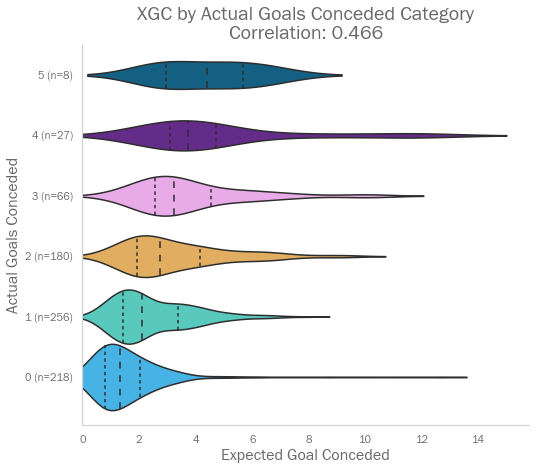

In [33]:
x = df_tm['XG']
y = df_tm['Goals']
n = [len(df_tm.loc[df_tm['Goals']==i]) for i in range(6)]

data = df_tm.loc[df_tm['Goals']<6]
corr = round(np.corrcoef(data['XG'],data['Goals'])[0][1],3)

plt.figure(figsize=(8,7))
sns.violinplot('XG','Goals', data=data,
               width=1.1, inner='quartile', orient='h')

plt.xlim(0)
plt.ylim(-0.8,5.5)

plt.yticks(range(6), [f'{i} (n={n[i]})' for i in range(6)])

plt.title(f'XGC by Actual Goals Conceded Category\nCorrelation: {corr}')
plt.xlabel('Expected Goal Conceded')
plt.ylabel('Actual Goals Conceded');

So, XGC is a pretty good indicator of goals conceded (this breaks down a bit after 3 goals, though by this point the sample sizes are small, and a clean sheet is basicallly out of the question anyway).

In [34]:
df_tm.reset_index(inplace=True)
df_tm.columns = ['GameWeek','Team','MatchID','GoalsConceded','XGC']
df_tm.head()

GameWeek                      Team  MatchID  GoalsConceded       XGC
0         1                   Arsenal    46614              0  0.996303
1         1               Aston Villa    46610              3  3.240594
2         1               Bournemouth    46606              1  2.588459
3         1  Brighton and Hove Albion    46611              0  2.450373
4         1                   Burnley    46607              0  2.658945

Let's get this data into our SQL database.

In [35]:
create_sql_table(df_tm, c, table_name = 'TeamsXGC', verbose=True)
conn.commit()

populate_sql_from_dataframe(df_tm, 'TeamsXGC', c, verbose=True)
conn.commit()

CREATE TABLE TeamsXGC (TeamsXGCID INTEGER PRIMARY KEY, TableIndex TEXT, GameWeek INTEGER, Team TEXT, MatchID INTEGER, GoalsConceded INTEGER, XGC REAL, unique (GameWeek, Team, MatchID, GoalsConceded, XGC));

Table not added - possibly already exists
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (0, 1, "Arsenal", 46614, 0, 0.9963027951445779);
                       
Error on row 0 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (1, 1, "Aston Villa", 46610, 3, 3.2405938769732603);
                       
Error on row 1 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (2, 1, "Bournemouth", 46606, 1, 2.5884591648907422);
                       
Error on row 2 - you may be trying to upload a duplicate row
INSERT INTO Te

                       
Error on row 87 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (88, 5, "Leicester City", 46649, 1, 4.405912239237607);
                       
Error on row 88 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (89, 5, "Liverpool", 46648, 1, 0.9572947510084956);
                       
Error on row 89 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (90, 5, "Manchester City", 46650, 3, 1.6379605107005089);
                       
Error on row 90 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (91, 5, "Manchester United", 46649, 0, 1.9268618272378

Error on row 174 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (175, 9, "Southampton", 46694, 1, 0.9197777037822881);
                       
Error on row 175 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (176, 9, "Tottenham Hotspur", 46693, 1, 1.5661376273226169);
                       
Error on row 176 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (177, 9, "Watford", 46693, 1, 1.2879234500355825);
                       
Error on row 177 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (178, 9, "West Ham United", 46689, 2, 7.286479295794438);
               

Error on row 268 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (269, 14, "Liverpool", 46738, 1, 3.9679273414078833);
                       
Error on row 269 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (270, 14, "Manchester City", 46740, 2, 0.7416175573493804);
                       
Error on row 270 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (271, 14, "Manchester United", 46739, 2, 1.6741585531761023);
                       
Error on row 271 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (272, 14, "Newcastle United", 46740, 2, 4.094124791408609);
    

Error on row 362 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (363, 19, "Chelsea", 46787, 2, 2.551821181662527);
                       
Error on row 363 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (364, 19, "Crystal Palace", 46788, 1, 2.4905902556154738);
                       
Error on row 364 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (365, 19, "Everton", 46789, 0, 0.29424758125679945);
                       
Error on row 365 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (366, 19, "Leicester City", 46790, 4, 7.340546980270529);
                   

Error on row 457 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (458, 24, "Arsenal", 46842, 2, 3.776162128180927);
                       
Error on row 458 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (459, 24, "Aston Villa", 46835, 1, 1.8358844493482782);
                       
Error on row 459 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (460, 24, "Bournemouth", 46836, 1, 3.655479284017127);
                       
Error on row 460 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (461, 24, "Brighton and Hove Albion", 46836, 2, 2.0586458699352623);
         

Error on row 552 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (553, 28, "Watford", 46883, 0, 0.7457002456705657);
                       
Error on row 553 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (554, 28, "West Ham United", 46884, 2, 4.413744446357347);
                       
Error on row 554 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (555, 28, "Wolverhampton Wanderers", 46882, 4, 10.424860430936242);
                       
Error on row 555 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (556, 29, "Arsenal", 46885, 0, 2.2795329670474715);
         

Error on row 644 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (645, 33, "Chelsea", 46926, 0, 0.8269476473634867);
                       
Error on row 645 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (646, 33, "Crystal Palace", 46927, 3, 2.8974514336009514);
                       
Error on row 646 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (647, 33, "Everton", 46933, 0, 0.9603336450842465);
                       
Error on row 647 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (648, 33, "Leicester City", 46927, 0, 0.7016781986346718);
                  

Error on row 739 - you may be trying to upload a duplicate row
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (740, 38, "Arsenal", 46975, 1, 3.5259402720085937);
                       
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (741, 38, "Aston Villa", 46984, 1, 0.9042624612464482);
                       
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (742, 38, "Bournemouth", 46979, 1, 2.3795963431258165);
                       
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (743, 38, "Brighton and Hove Albion", 46976, 1, 1.7058254886816968);
                       
INSERT INTO TeamsXGC (TableIndex, GameWeek, Team, MatchID, GoalsConceded, XGC)
                       VALUES (744, 38, "Burnley", 46976, 2, 1.9902344640319591);
           

In [36]:
#Sum all the teams' goals against, and XG against
df_tm_for = df_pm.groupby(['GameWeek','ForTeam','MatchID']).sum()[['XG']]
df_tm_against = df_pm.groupby(['GameWeek','AgainstTeam','MatchID']).sum()[['XG']]
df_tm_against.columns = ['XGC']
df_txg = pd.concat([df_tm_for, df_tm_against], axis=1).reset_index()
df_txg.head()

GameWeek                   ForTeam  MatchID        XG       XGC
0         1                   Arsenal    46614  1.249386  0.996303
1         1               Aston Villa    46610  1.448371  3.240594
2         1               Bournemouth    46606  4.023957  2.588459
3         1  Brighton and Hove Albion    46611  1.915772  2.450373
4         1                   Burnley    46607  3.973459  2.658945

In [37]:
create_sql_table(df_txg, c, table_name = 'TeamsXG', verbose=True)
conn.commit()

populate_sql_from_dataframe(df_txg, 'TeamsXG', c, verbose=True)
conn.commit()

CREATE TABLE TeamsXG (TeamsXGID INTEGER PRIMARY KEY, TableIndex TEXT, GameWeek INTEGER, ForTeam TEXT, MatchID INTEGER, XG REAL, XGC REAL, unique (GameWeek, ForTeam, MatchID, XG, XGC));

Table not added - possibly already exists
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (0, 1, "Arsenal", 46614, 1.2493858592148255, 0.9963027951445779);
                       
Error on row 0 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (1, 1, "Aston Villa", 46610, 1.4483714426137015, 3.2405938769732603);
                       
Error on row 1 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (2, 1, "Bournemouth", 46606, 4.023956891034905, 2.5884591648907422);
                       
Error on row 2 - you may be trying to upload a duplicate row
INSERT INTO 

                       
Error on row 93 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (94, 5, "Sheffield United", 46651, 4.919501850792921, 4.010140268327451);
                       
Error on row 94 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (95, 5, "Southampton", 46651, 4.010140268327451, 4.919501850792921);
                       
Error on row 95 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (96, 5, "Tottenham Hotspur", 46652, 2.0884271733465685, 2.207067325938144);
                       
Error on row 96 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (97, 5, "Watford", 46653, 4.753580143

Error on row 186 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (187, 10, "Everton", 46696, 3.010116999803001, 4.13308671864608);
                       
Error on row 187 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (188, 10, "Leicester City", 46702, 14.73578244458392, 2.3435703946322324);
                       
Error on row 188 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (189, 10, "Liverpool", 46698, 4.201979370915159, 1.7377112610333016);
                       
Error on row 189 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (190, 10, "Manchester City", 46699, 4.571842736774827, 2.04919461

                       
Error on row 280 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (281, 15, "Aston Villa", 46751, 1.7868688320927957, 3.338210646118963);
                       
Error on row 281 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (282, 15, "Bournemouth", 46752, 2.3105157736245676, 1.4228597571333355);
                       
Error on row 282 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (283, 15, "Brighton and Hove Albion", 46745, 6.757835207508431, 3.158112607237507);
                       
Error on row 283 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (284, 15, "Burnley", 46

Error on row 371 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (372, 19, "Sheffield United", 46792, 3.2515723506029075, 0.566953640649645);
                       
Error on row 372 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (373, 19, "Southampton", 46787, 2.551821181662527, 2.255782201454344);
                       
Error on row 373 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (374, 19, "Tottenham Hotspur", 46793, 4.585892382739006, 2.173887332036616);
                       
Error on row 374 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (375, 19, "Watford", 46792, 0.566953640649645, 3.25

Error on row 466 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (467, 24, "Liverpool", 46784, 2.2954787730714985, 1.630540398775124);
                       
Error on row 467 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (468, 24, "Liverpool", 46841, 5.2389878967694425, 3.1539977389010474);
                       
Error on row 468 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (469, 24, "Manchester City", 46840, 3.538104708237134, 1.0653049290315202);
                       
Error on row 469 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (470, 24, "Manchester United", 46839, 3.383353839288156, 0.

Error on row 562 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (563, 29, "Everton", 46887, 0.45511885962652343, 3.5229300984268943);
                       
Error on row 563 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (564, 29, "Leicester City", 46889, 3.965744215563677, 0.4991585484841876);
                       
Error on row 564 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (565, 29, "Liverpool", 46890, 2.3833695751801955, 1.4252470313940395);
                       
Error on row 565 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (566, 29, "Manchester City", 46891, 0.9792541650944935, 2.60

Error on row 659 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (660, 34, "Arsenal", 46935, 1.799340322105241, 2.533784560715781);
                       
Error on row 660 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (661, 34, "Aston Villa", 46936, 0.6401538211389377, 2.060988011177513);
                       
Error on row 661 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (662, 34, "Bournemouth", 46937, 1.4695068577457533, 0.5619798316783123);
                       
Error on row 662 - you may be trying to upload a duplicate row
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (663, 34, "Brighton and Hove Albion", 46938, 2.226709288522864, 

INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (754, 38, "Sheffield United", 46983, 1.5636698628949564, 1.6631293268822045);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (755, 38, "Southampton", 46983, 1.6631293268822045, 1.5636698628949564);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (756, 38, "Tottenham Hotspur", 46978, 1.0705773264486123, 1.3094238221490435);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (757, 38, "Watford", 46975, 3.5259402720085937, 2.4856394703242524);
                       
INSERT INTO TeamsXG (TableIndex, GameWeek, ForTeam, MatchID, XG, XGC)
                       VALUES (758, 38, "West Ham United", 46984, 0.9042624612464482, 1.5309699594528947);
                       
INSE